In [30]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
savepath = "/Users/raghav/Library/Mobile Documents/com~apple~CloudDocs/Documents/GaTech QCF/Courses/Finance & Investments/Assignments/Trading Simulation/"


### Getting Metadata for Universe (All S&P 500 Stocks)
##### 
- We are picking all S&P 500 stocks as of 13 October 13, 2023. Pairs within this universe will be identified and shortlisted based on our methodology described below.
- We intend to identify at least 30 pairs covering at least 7 industries which give 3-4 trading signals a year based our pair trading methodology.
- The metadata contains, Ticker, Company Name, GICS Sector (GICS-1) and GICS Sub-Industry (GICS-4)

In [31]:
def getmetaData():
    payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    companyMetaData = pd.DataFrame(payload[0])
    companyMetaData = companyMetaData.rename(columns = {"Symbol": "ticker",
                              "Security": "company",
                              "GICS Sector": "GICS Sector (GICS-1)",
                              "GICS Sub-Industry": "GICS Sub-Industry (GICS-4)"})[["ticker", 
                                                                                   "company", 
                                                                                   "GICS Sector (GICS-1)",
                                                                                   "GICS Sub-Industry (GICS-4)"]]
    tickers = companyMetaData["ticker"].unique().tolist()   
    companyMetaData = companyMetaData.set_index("ticker")
    return companyMetaData, tickers

### Getting 2-Year Lookback Price Series For Universe
#####
- Our correlation and cointegration tests will be conducted on price series for the last two years of S&P 500 stocks. 
- The closing price is the only column of interest for this methodology. 
- Daily returns will be calculated later for correlation analysis. 

In [32]:
def getPriceSeries2YearLookBack(tickers):
    print("Downloading pricing information.")
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=730)).strftime('%Y-%m-%d')
    data = yf.download(tickers, start_date, end_date)
    data = data.loc[:, data.columns.get_level_values(0).isin({"Adj Close", "Volume"})]
    data = data.stack(level=1)
    data.reset_index(inplace=True)
    data = data.rename(columns = {"Date": "date",
                                  "level_1": "ticker",
                                  "Adj Close": "closingPrice",
                                  "Volume": "volume"}).set_index("date")
    print("Successfully downloaded pricing information.")
    dailyCompanyData = list(data.groupby("ticker"))
    return dailyCompanyData

### Function to Calculate Daily Returns

In [33]:
def returnTask(dailyCompanyData):
    ticker, df = dailyCompanyData
    df = df.sort_index()
    df["dailyReturn"] = df["closingPrice"].pct_change()*100
    return df[["ticker", "dailyReturn"]]

### Shortlisted Pairs Based on Correlation

- Pair Trading is a market neutral trading strategy. 
- We will be going long on certain units of a stock and going short on some other units of the corresponding paired stock.
- Pairs are initially shortlisted based on correlation values and whether they belong to the same GICS 1 (broadest) industry group.
- General practice for trading pairs commands us to only pick pairs whose daily returns are correlated by more than 75%.
- From this subset we pick only those which belong to the same GICS 1 Industry. 

### Results
From the correlation shortlisting we are able to circle down on 647 pairs consisting of 249 unique stocks covering all 12 industries

### Going Long and Short on a Pair
- Here we explain the concept of **going long or short on a pair and what that means.**
- Going forward, we will model the closing price of one stock in the pair with the closing price of the other using linear regression.
- Y = $\beta$ X + C + $\epsilon$
- Here Y is the dependent stock, X is the independent stock, $\beta$ is the slope, C is the intercept and $\epsilon$ is the residual.
- Choice between independent and dependent stock will be explained later.
- When we go **long on a pair, we long 1 unit of Y and correspondingly short $\beta$ units of stock X.**
- When we **short a pair, we short 1 unit of Y and correspondingly long $\beta$ units of stock X.**
- This is a $\beta$ neutral strategy. We will attempt to also keep the strategy as dollar neutral as possible. For the strategy to be dollar neutral, the intercept term C and the residuals need to be as low as possible. More on that later.

In [34]:
def correlationShortlisting(dailyCompanyData):

    # get pairs having correlation in the top 5% percentile of all pairs
    
    dailyReturns = list(map(returnTask, dailyCompanyData))
    combined_df = pd.concat(dailyReturns).reset_index()
    pivoted_df = combined_df.pivot(index = "date", columns="ticker", values="dailyReturn")
    correlation_matrix = pivoted_df.corr()
    correlation_list = [(correlation_matrix.iloc[i, j], correlation_matrix.columns[i], correlation_matrix.columns[j])
                       for i in range(correlation_matrix.shape[0])
                       for j in range(i+1, correlation_matrix.shape[1])]
    correlation_list.sort(reverse=True)
    top_percent = 5
    threshold_index = int(len(correlation_list) * (top_percent / 100))
    top_5_percent_pairs = correlation_list[:threshold_index]
    
    # filter out pairs for whicg GICS 1 Industry is not the same
    # filter out pairs having correlation lower than 0.75
    
    shortlistedPairs = []
    shortlistedTickers = []
    for pair in top_5_percent_pairs:
        ind1 = companyMetaData.loc[pair[1], "GICS Sector (GICS-1)"]
        ind2 = companyMetaData.loc[pair[2], "GICS Sector (GICS-1)"]
        if ind1 == ind2 and pair[0]>0.75:
            shortlistedPairs.append(pair)
            shortlistedTickers.append(pair[1])
            shortlistedTickers.append(pair[2])        
    shortlistedTickers = list(set(shortlistedTickers))
    
    return shortlistedPairs, shortlistedTickers

### Signal Generation and Trading Methodology

##### Trading on Residuals

- Y = $\beta$ X + C + $\epsilon$
- Here Y is the dependent stock, X is the independent stock, $\beta$ is the slope, C is the intercept and $\epsilon$ is the residual.
- Given that the two price series are cointegrated and the residual series is stationary (more on that later), we can assume that temporary sharp peaks or troughs in the residual series will revert to mean.
- **If the residuals are experiencing a sharp rise, we can say that Y is temporarily overpriced relative to X and we short the pair.**
- **If the residuals are experiencing a steep drop, we can say that Y is temporarily underpriced relative to X and we go long on the pair.** 

##### Choice of Dependent and Independent Variable
- We need C as low as possible for a dollar neutral strategy.
- To ensure this we pick the dependent and independent variable to minimize the "Error Ratio".
- The error ratio is defined as  $\frac{\text{Standard  Error  Of  Intercept}}{ \sigma_{\text{Residual Series}} }$
- We conduct two regressions, one with stock 1 as the independent variable and the other with stock 2 as the independent variable. Whichever model thows out the lower error ratio is picked as our trading signal model going forward.

##### Cointegration Check
- A pair is suitable for pair trading only if their stock price series are cointegrated. 
- This means that the residual series from the regression needs to be stationary. 
- For a series to be stationary it needs to satisfy all three of the following conditions:
    - The mean should be within a tight range.
    - The standard deviation should be within a tight range.
    - There should be no autocorrelation within the series.
- To test the stationarity of the residual series we conduct the Augented Dickey Fuller (ADF) test. For our level of risk tolerance we need a 95% confidence interval that the two stock price series are cointegrated. **Therefore we shortlist pairs whose p-value from the ADF test is lower than 5%.**

##### Problem of Large Intercept
- We are trying to model stock price of Y with $\beta$ X as closely as possible. A large intercept value C introduces error into our $\beta$ neutral (and possibly dollar neutral) strategy. 
- Suppose Y is 10, X is 2 and $\beta$ is 1, for a zero residual example, C here would be 8. This means that 80% of the stock price of Y is explained only by the intercept. Even if we are able to establish cointegration, high correlation, same sector stocks, we will not be able employ a beta neutral strategy here. If we purchase one unit of Y and short 1 unit of X here, we cannot be sure that rise in residual will lead us to profits as simply not enough of Y is modelled by $\beta$ X.
- **To alleviate this problem, we will only stick to pairs whose intercept explains less than 20% of the 2 year average stock price of Y.**  
- **$\frac{C}{\mu_{\text{Y Closing Price}}} < 0.2$**

##### Shortlisted Pairs
- After choosing the dependent and independent stocks within pairs, selecting cointegrated pairs and filtering out pairs with relatively large intercepts (after initially choosing only highly correlated and same industry pairs), **we are left with 35 pairs covering 50 stocks that we will be tracking daily.** 
- These pairs cover 8 Industries, namely:
    1. Communication Services
    2. Consumer Discretionary
    3. Utilities
    4. Financials
    5. Energy
    6. Real Estate
    7. Industrials
    8. Information Technology

##### Trading Signals 
- As explained earlier, our trading signals will be based on steep peaks and troughs in the residuals. 
- Z-Score = $\frac{Residual_{t} - \mu_{\text{Residual Series}}}{\sigma_{\text{Residual Series}}}$   
- By definition of cointegrated closing stock price series, $\mu_{\text{Residual Series}}$ will be very close to zero.
- We will be tracking this Z-Score for each of the 35 shortlisted pairs daily.
- **A long pair trade will be triggered when the Z-score drops below -2.5 and will be closed when it reverts to -1. Stop-Loss will be set at Z-Score of -3.**
- **A short pair trade will be triggered when the Z-score goes above 2.5 and will be closed when it reverts to 1. Stop-Loss will be set at Z-Score of 3.**
- If we are unable to get enough trading opportunities based on this risk averse criteria of 99% confidence interval that Z-Score will revert to mean, we may relax our criteria.
- We may increase our risk tolerance and trigger trades at Z-Scores of +-2 and closing them at +-1 with stop loss set at +-3 respectively. This will give us a 95% confidence interval of Z-Score returning to mean.




In [35]:
def getRegressionResults(shortlistedPairs, shortlistedPriceSeries):

    regressionResults = []
    for pair in shortlistedPairs:
    
        Y = shortlistedPriceSeries[pair[1]].dropna()
        X = shortlistedPriceSeries[pair[2]].dropna()
        if len(X) != len(Y):
            continue
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        C1 = model.params[0]
        beta1 = model.params[1]   
        stdevResidualSeries1 = np.sqrt(model.scale)    
        stdevIntercept1 = model.bse["const"]    
        errorRatio1 = stdevIntercept1/stdevResidualSeries1    
        residualSeries1 = model.resid
        adfTestPValue1 = adfuller(residualSeries1)[1]   
            
        Y = shortlistedPriceSeries[pair[2]].dropna()
        X = shortlistedPriceSeries[pair[1]].dropna()
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()  
        C2 = model.params[0]
        beta2 = model.params[1]   
        stdevResidualSeries2 = np.sqrt(model.scale)    
        stdevIntercept2 = model.bse["const"]    
        errorRatio2 = stdevIntercept2/stdevResidualSeries2    
        residualSeries2 = model.resid        
        adfTestPValue2 = adfuller(residualSeries2)[1]
        
        if errorRatio2 > errorRatio1:
            if adfTestPValue1 > 0.05:
                continue
            regressionResults.append({"independent": pair[2],
                    "dependent": pair[1],
                    "intercept": C1,
                    "beta": beta1,
                    "stdevResidualSeries": stdevResidualSeries1,
                    "residualSeries": residualSeries1,
                    "adfTestPValue": adfTestPValue1})
        
        else:
            if adfTestPValue2 > 0.05:
                continue

            regressionResults.append({"independent": pair[1],
                    "dependent": pair[2],
                    "intercept": C2,
                    "beta": beta2,
                    "stdevResidualSeries": stdevResidualSeries2,
                    "residualSeries": residualSeries2,
                    "adfTestPValue": adfTestPValue2})
    return regressionResults

In [36]:
def plotResiduals(residualSeries, stdevResidualSeries, companyX, companyY, tickerX, tickerY):
    residualSeries = residualSeries.to_frame().rename(columns = {0: "residuals"})
    meanResidualSeries = residualSeries["residuals"].mean()
    residualSeries["zscore"] = (residualSeries["residuals"] - meanResidualSeries)/stdevResidualSeries

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(residualSeries.index, residualSeries["zscore"], color='blue')
    ax.set_facecolor('white')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Residual Z-Score', fontsize=14)
    months = mdates.MonthLocator()
    months_fmt = mdates.DateFormatter('%b %y')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.axhline(1, color='red', linestyle='--')
    ax.axhline(-1, color='red', linestyle='--')
    ax.axhline(2.5, color='darkgreen', linestyle='--')
    ax.axhline(-2.5, color='darkgreen', linestyle='--')
    ax.axhline(2, color='darkgoldenrod', linestyle='--')
    ax.axhline(-2, color='darkgoldenrod', linestyle='--')
    ax.axhline(0, color='lightblue', linestyle='--')    
    #ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation = 45)
    plt.title('Residual Z-Scores for the Past 2 Years\nX: {} ({})\nY: {} ({})'.format(companyX, tickerX, companyY, tickerY), fontsize=16)
    plt.savefig(savepath + "Backtesting/" + "{}_{}_residualZscores.png".format(tickerX, tickerY), bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

In [37]:
def plotRecentResiduals(residualSeries, stdevResidualSeries, companyX, companyY, tickerX, tickerY):
    residualSeries = residualSeries.to_frame().rename(columns = {0: "residuals"})
    meanResidualSeries = residualSeries["residuals"].mean()
    residualSeries["zscore"] = (residualSeries["residuals"] - meanResidualSeries)/stdevResidualSeries
    residualSeries = residualSeries.tail(30)
    
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(residualSeries.index, residualSeries["zscore"], color='blue')
    ax.set_facecolor('white')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Residual Z-Score', fontsize=14)    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    date_fmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(date_fmt)
    ax.axhline(1, color='red', linestyle='--')
    ax.axhline(-1, color='red', linestyle='--')
    ax.axhline(2.5, color='darkgreen', linestyle='--')
    ax.axhline(-2.5, color='darkgreen', linestyle='--')
    ax.axhline(2, color='darkgoldenrod', linestyle='--')
    ax.axhline(-2, color='darkgoldenrod', linestyle='--')
    ax.axhline(0, color='lightblue', linestyle='--')    
    #ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation = 45)
    plt.title('Residual Z-Scores for the Past 2 Years\nX: {} ({})\nY: {} ({})'.format(companyX, tickerX, companyY, tickerY), fontsize=16)
    plt.savefig(savepath + "LastMonthResiduals/" + "{}_{}_residualZscores.png".format(tickerX, tickerY), bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

In [38]:
companyMetaData, tickers = getmetaData()

In [39]:
dailyCompanyData = getPriceSeries2YearLookBack(tickers)

[*********************100%%**********************]  502 of 502 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-10-15 -> 2023-10-15)')



Successfully downloaded pricing information.


In [40]:
shortlistedPairs, shortlistedTickers = correlationShortlisting(dailyCompanyData)
shortlistedPriceSeries = {}
for series in dailyCompanyData:
    if series[0] in shortlistedTickers:
        shortlistedPriceSeries[series[0]] = series[1][["ticker", "closingPrice"]]

shortlistedPriceSeries = pd.concat(list(shortlistedPriceSeries.values())).reset_index()        
shortlistedPriceSeries = shortlistedPriceSeries.pivot(index = "date", columns="ticker", values="closingPrice")        

In [41]:
regressionResults = getRegressionResults(shortlistedPairs, shortlistedPriceSeries)
regressionResults = pd.DataFrame(regressionResults)
regressionResults["industry"] = regressionResults["dependent"].apply(lambda x: companyMetaData.loc[x]["GICS Sector (GICS-1)"])
regressionResults["explainedY"] = regressionResults.apply(lambda x: (1-(x["intercept"]/shortlistedPriceSeries[x["dependent"]].mean()))*100, axis = 1)
regressionResults = regressionResults[regressionResults["explainedY"]>80]
regressionResults["companyY"] = regressionResults["dependent"].apply(lambda x: companyMetaData.loc[x]["company"])
regressionResults["GICS4companyY"] = regressionResults["dependent"].apply(lambda x: companyMetaData.loc[x]["GICS Sub-Industry (GICS-4)"])
regressionResults["companyX"] = regressionResults["independent"].apply(lambda x: companyMetaData.loc[x]["company"])
regressionResults["GICS4companyX"] = regressionResults["independent"].apply(lambda x: companyMetaData.loc[x]["GICS Sub-Industry (GICS-4)"])

### Backtesting 
##### Z-Scores of Residuals of Shortlisted Pairs  
- Z-scores of the residuals are plotted for the 35 pairs for the last two years of data.
- It is clear that each pair may deliver 2-3 trading signals in a two year period for our 99% confidence interval criterion.
- For our 95% confidence interval criterion, we may be able to generate more trading signals in the coming two months. 

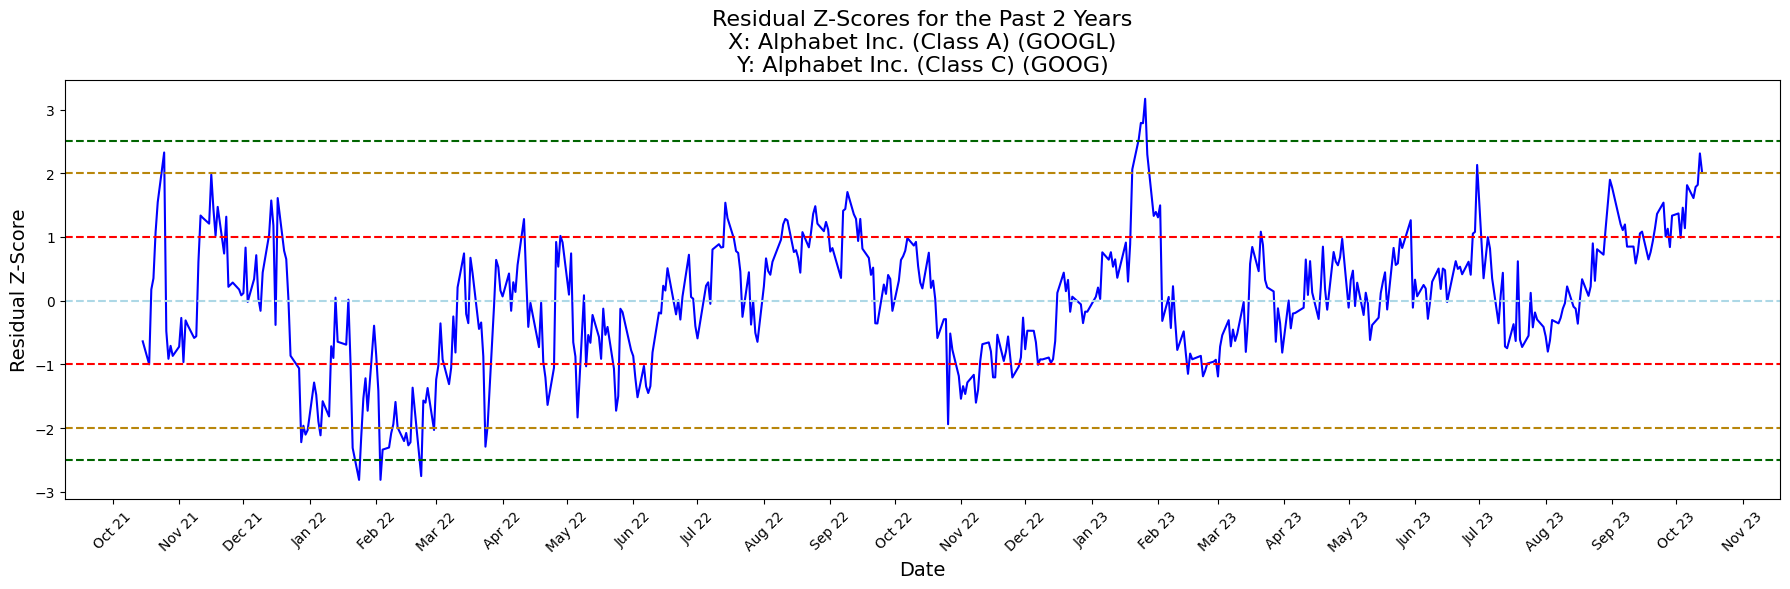

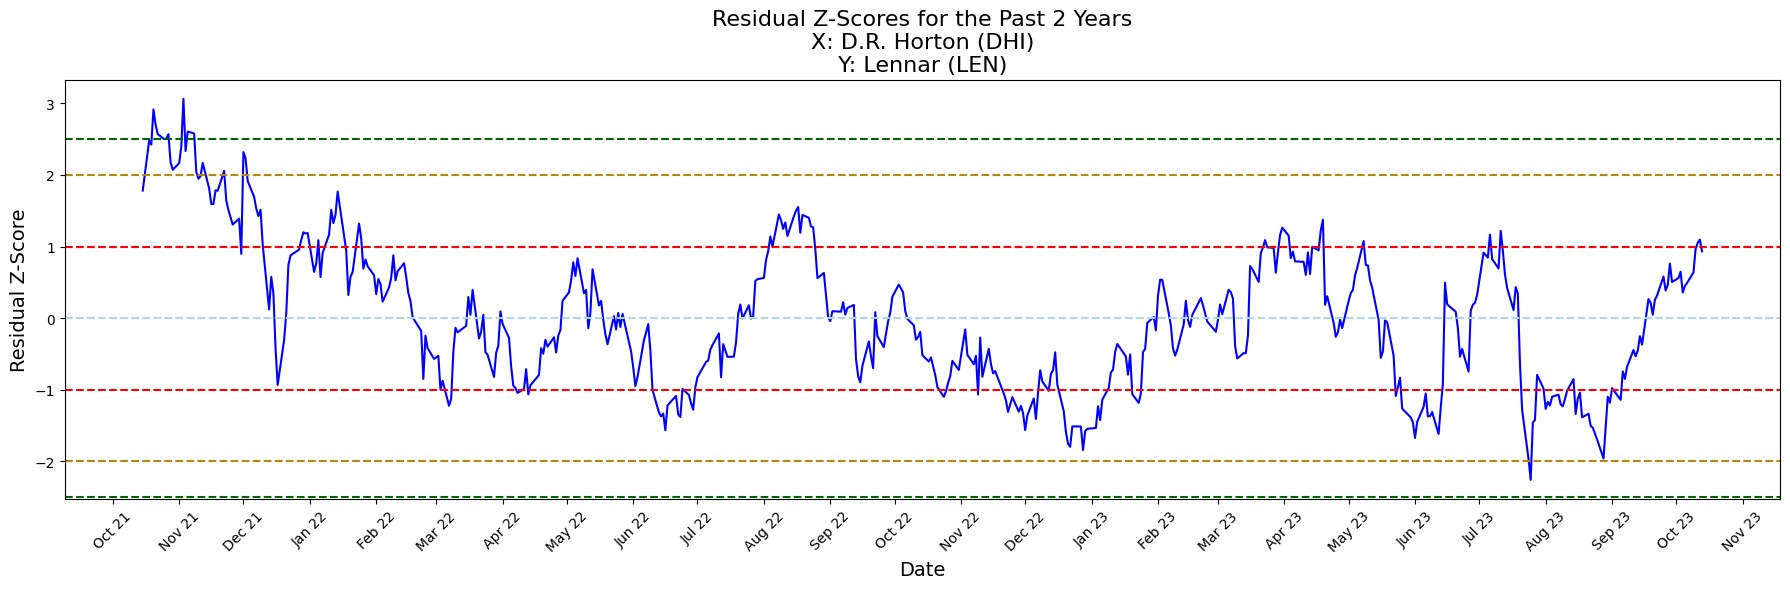

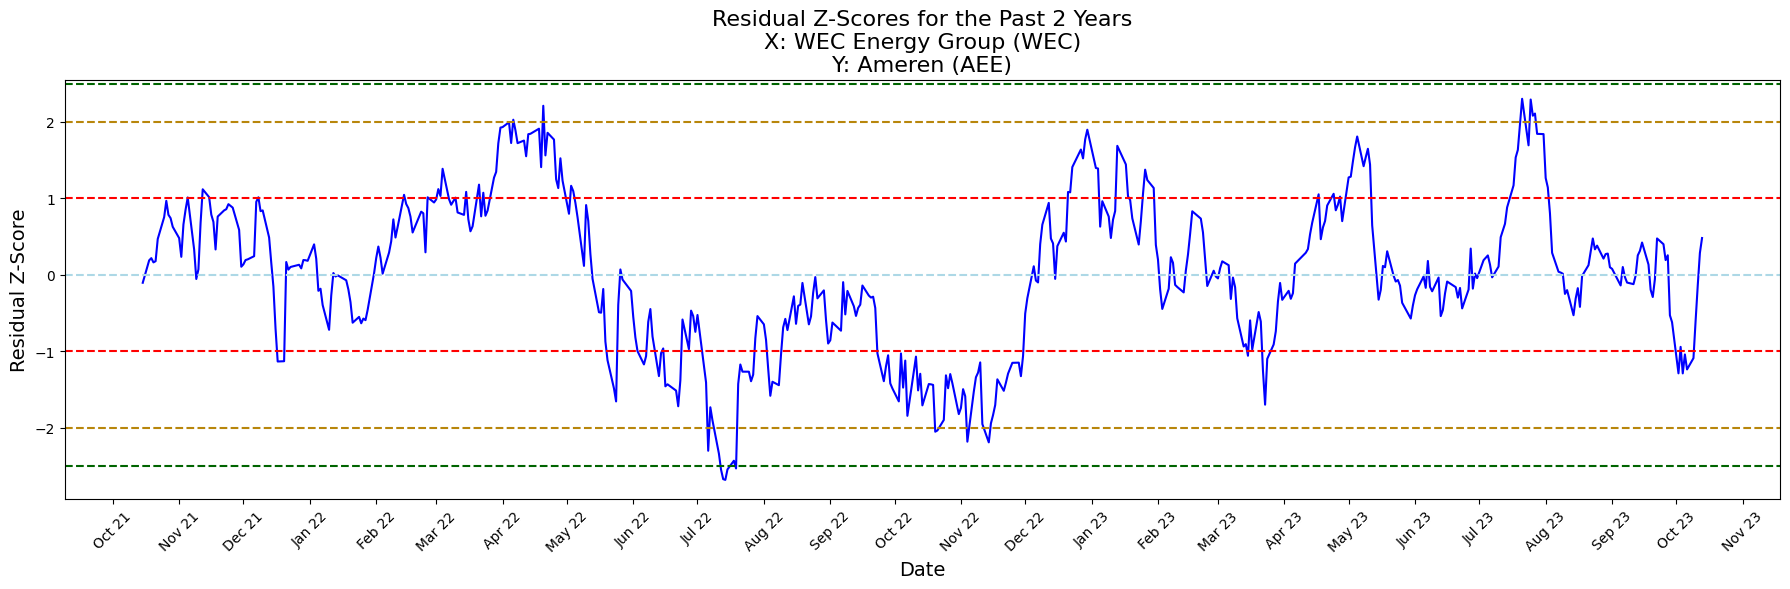

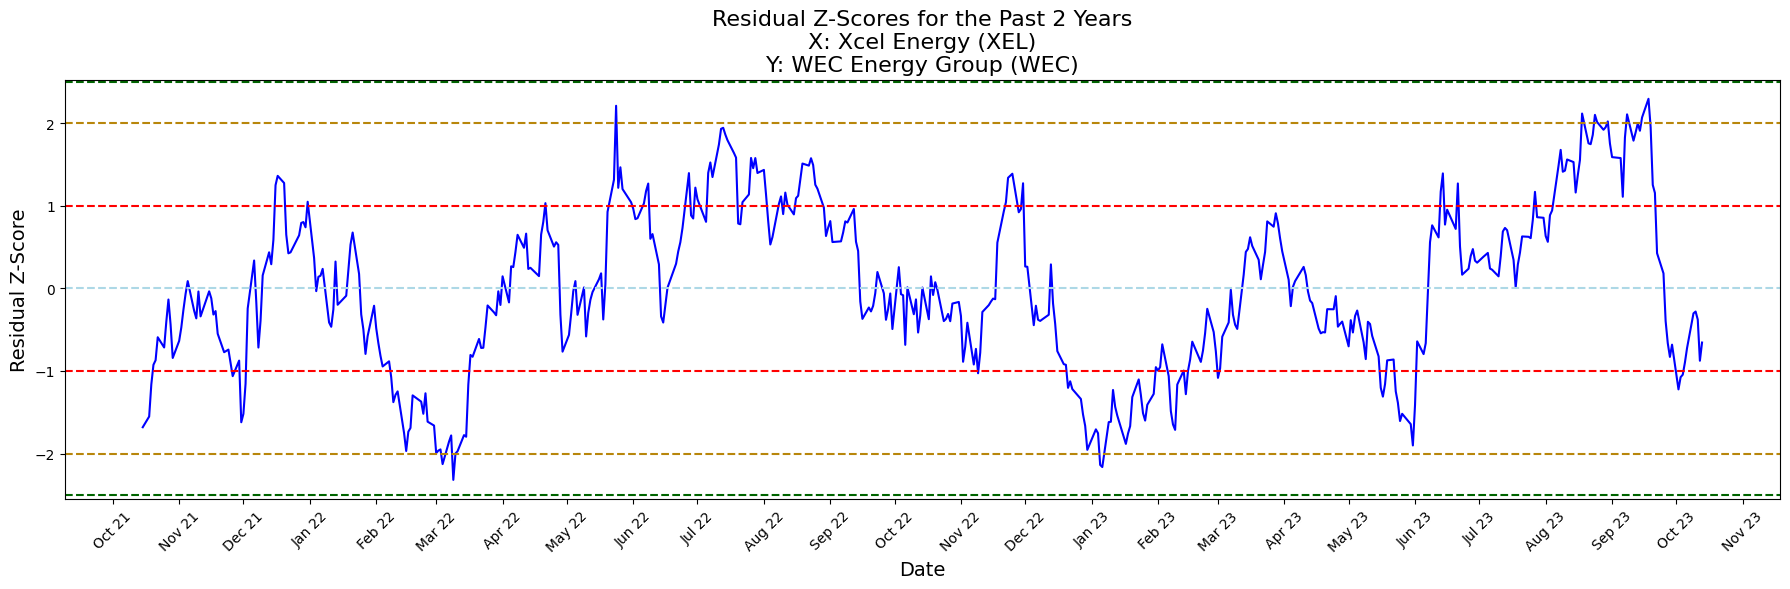

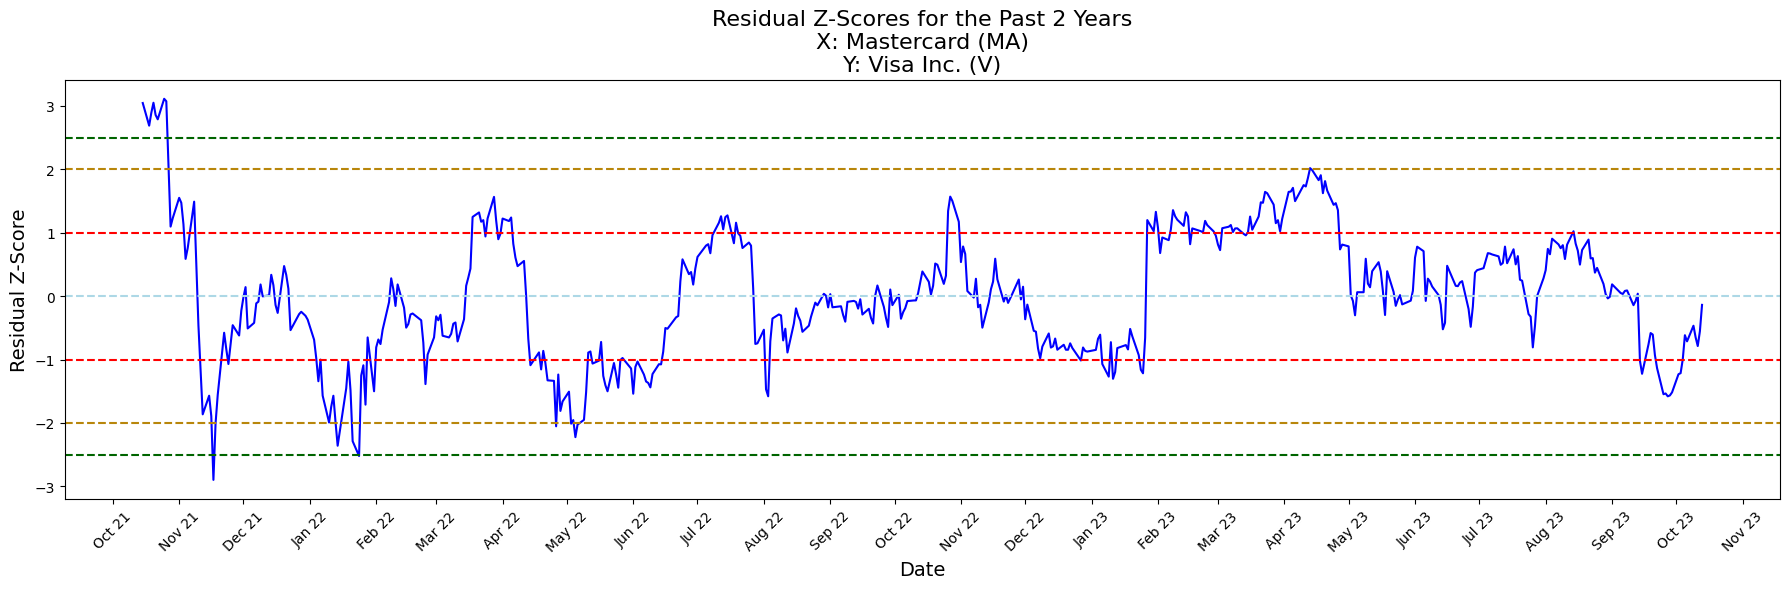

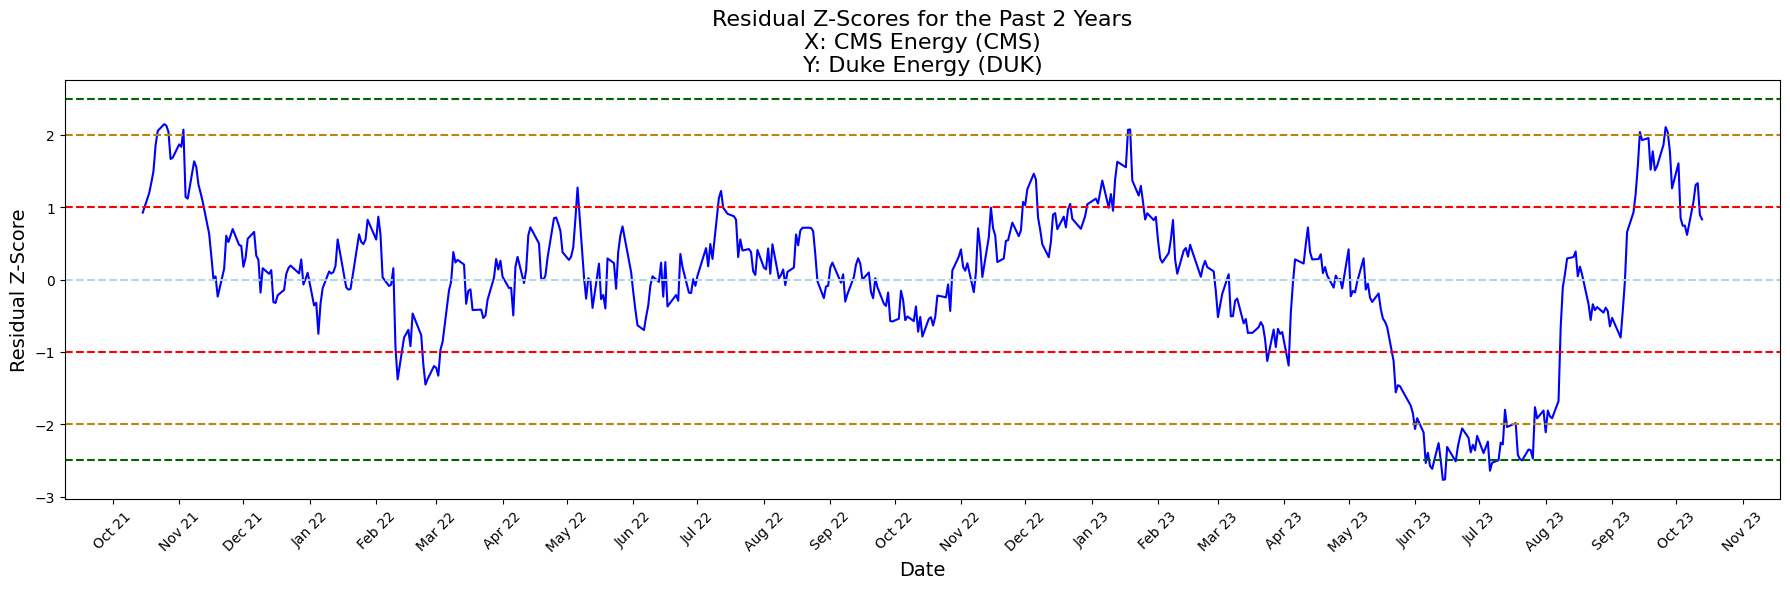

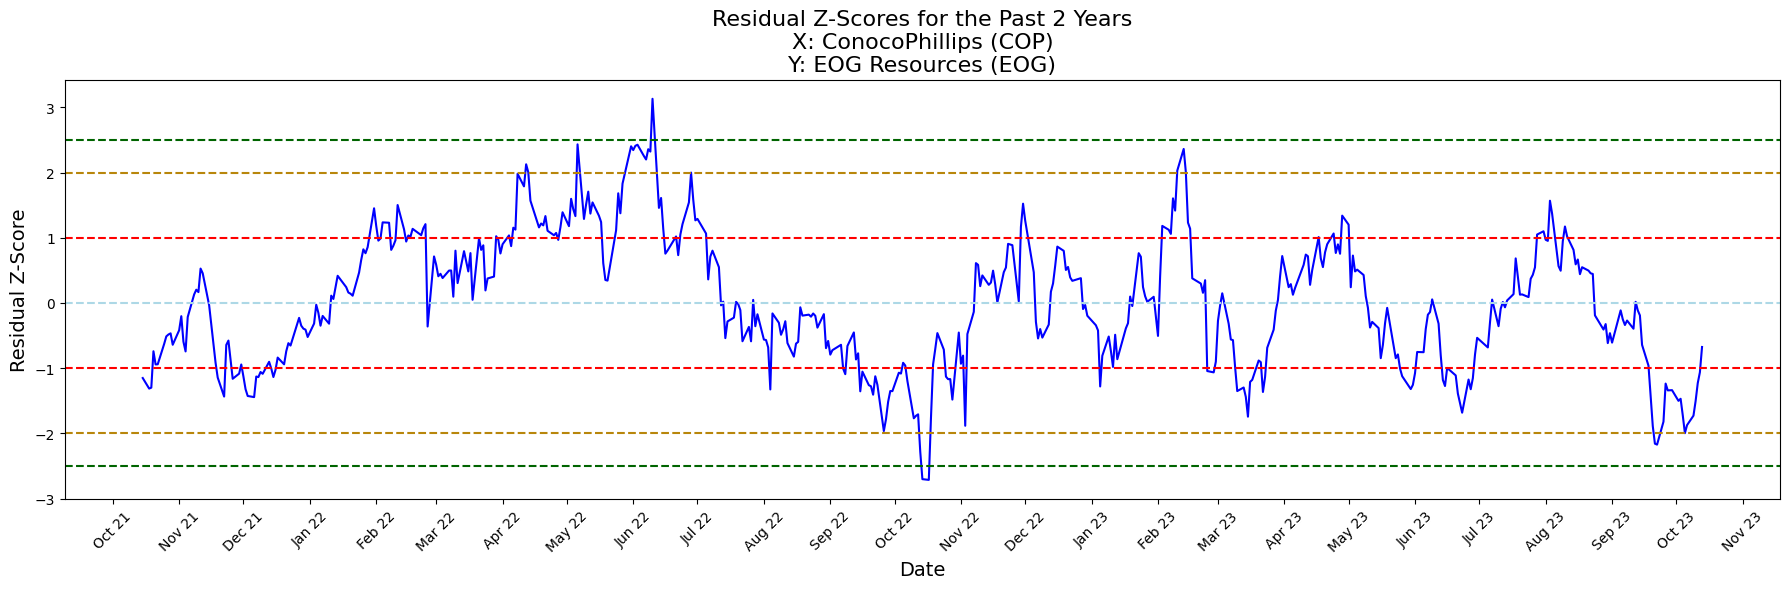

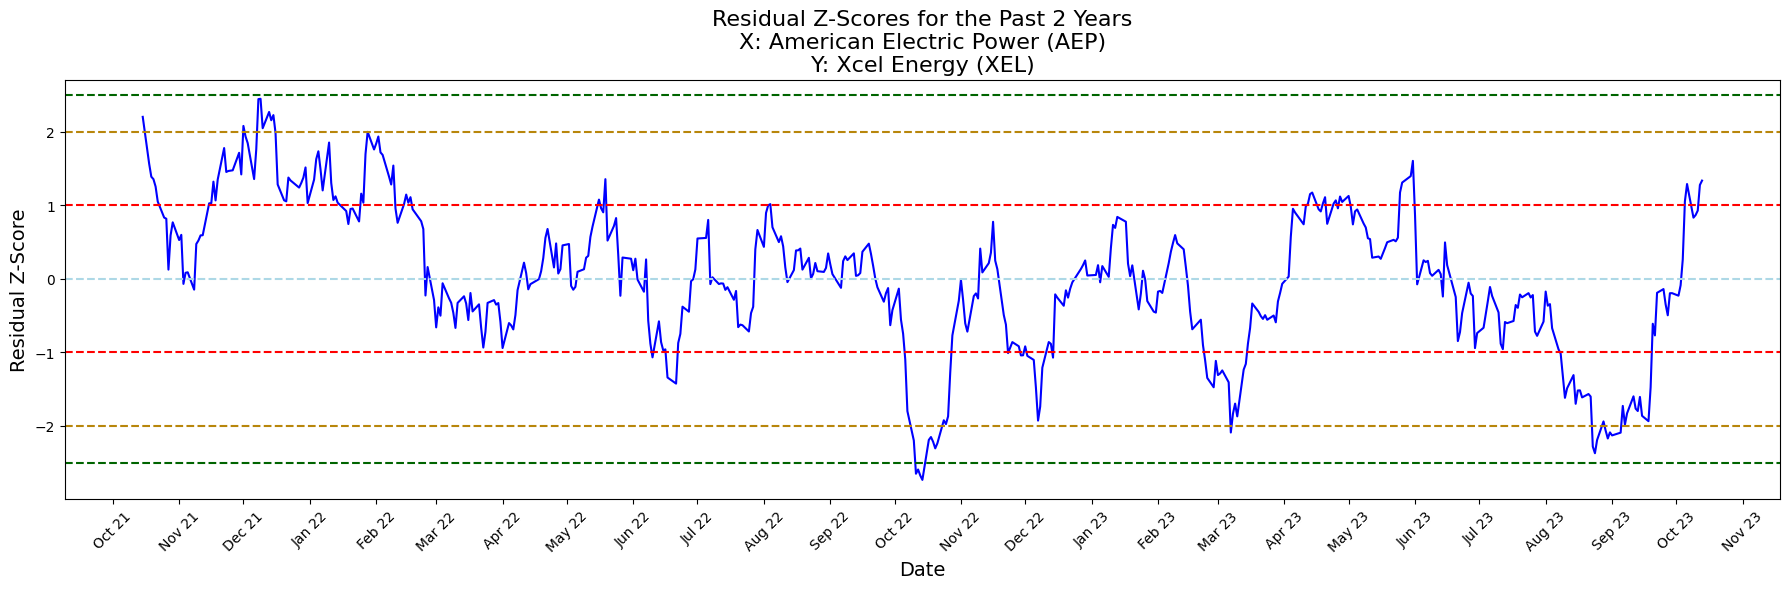

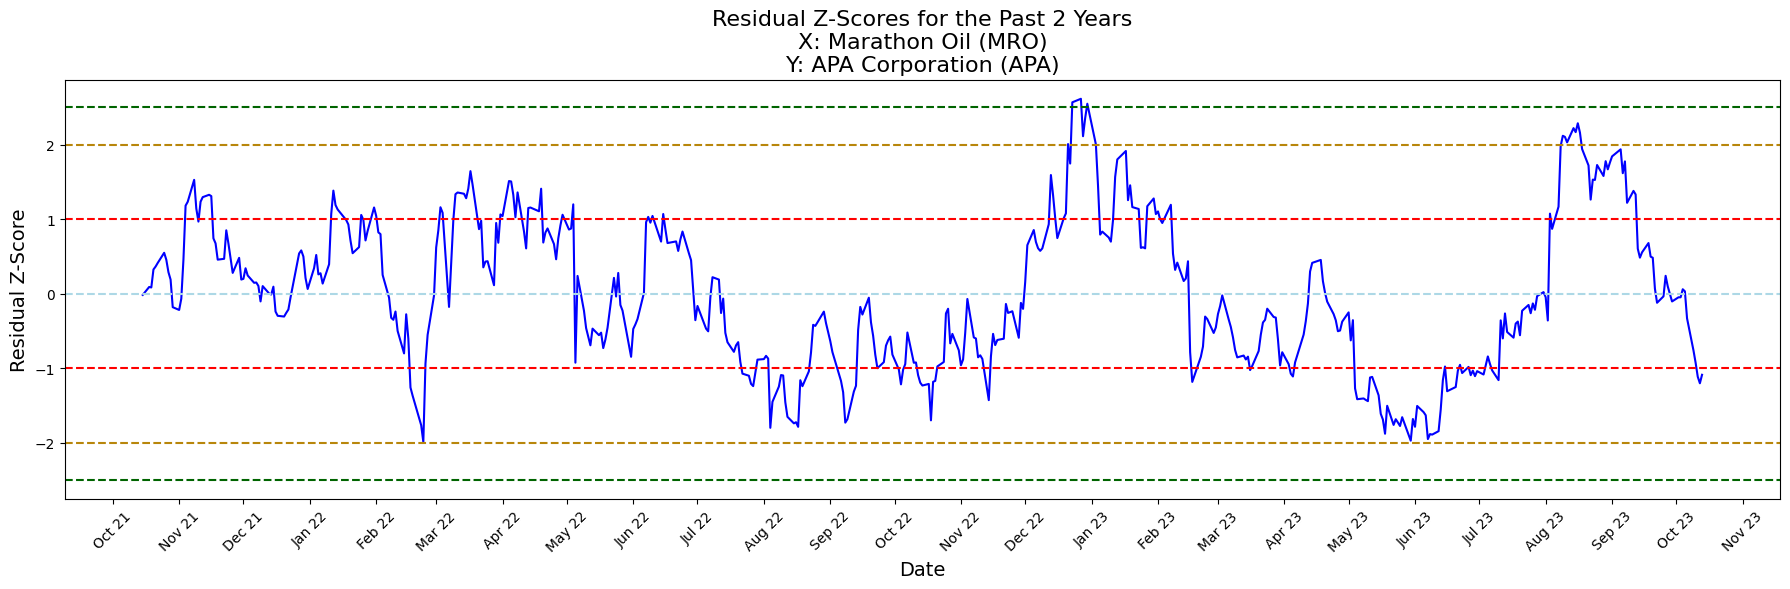

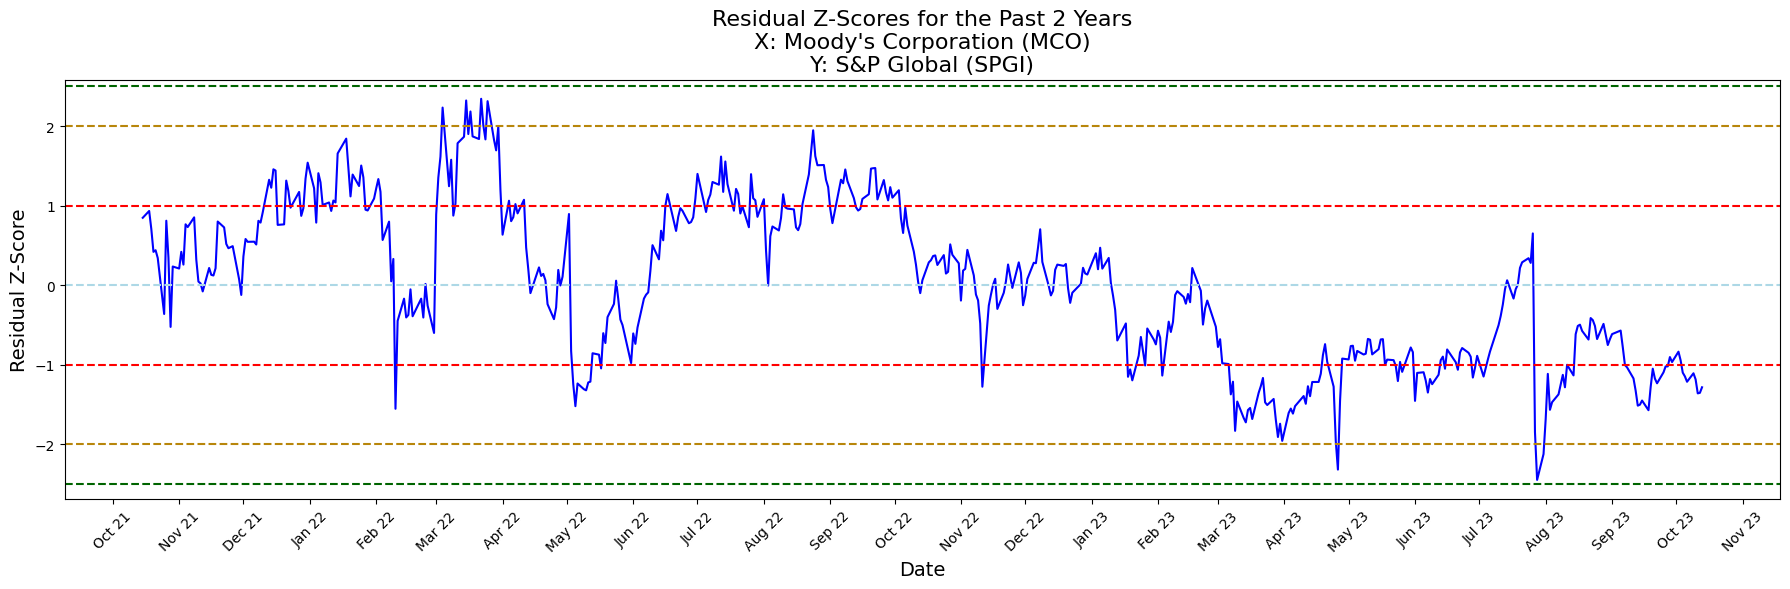

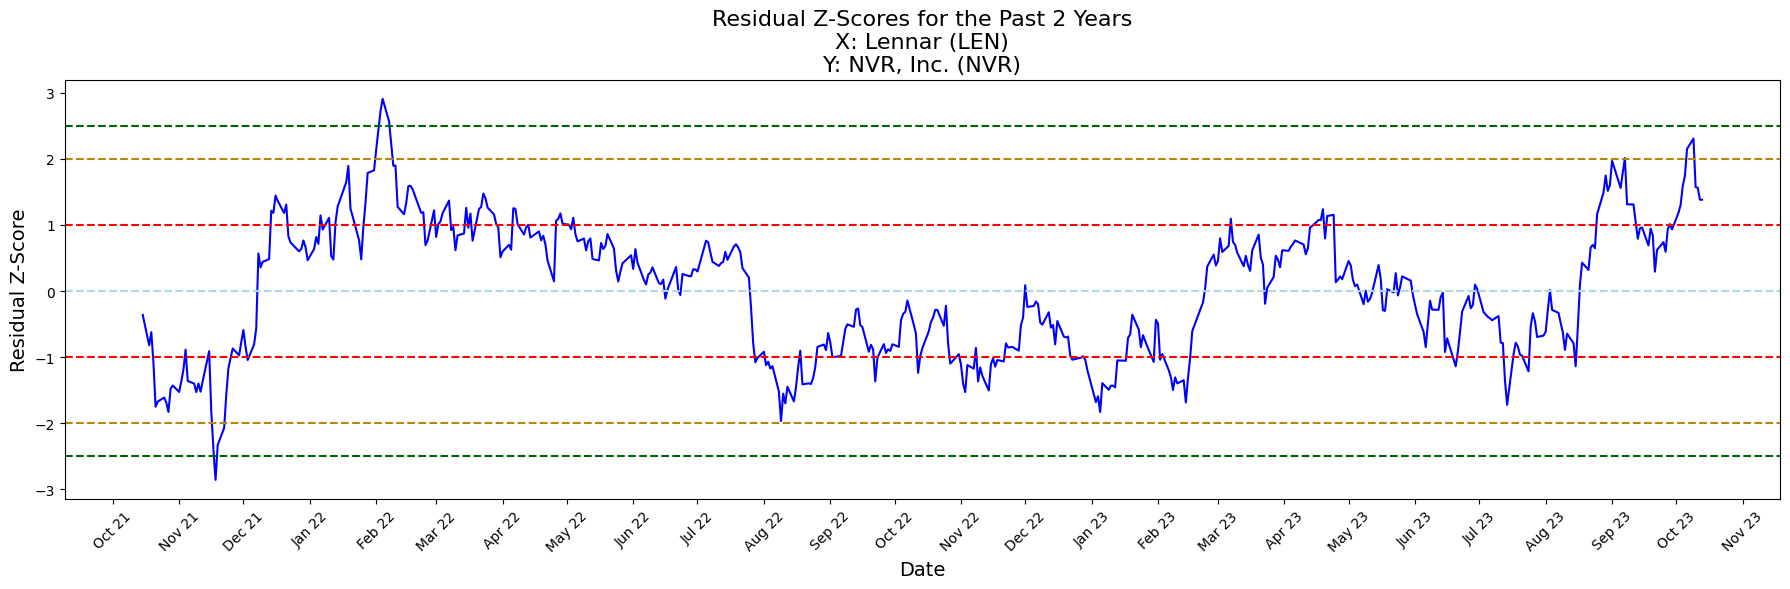

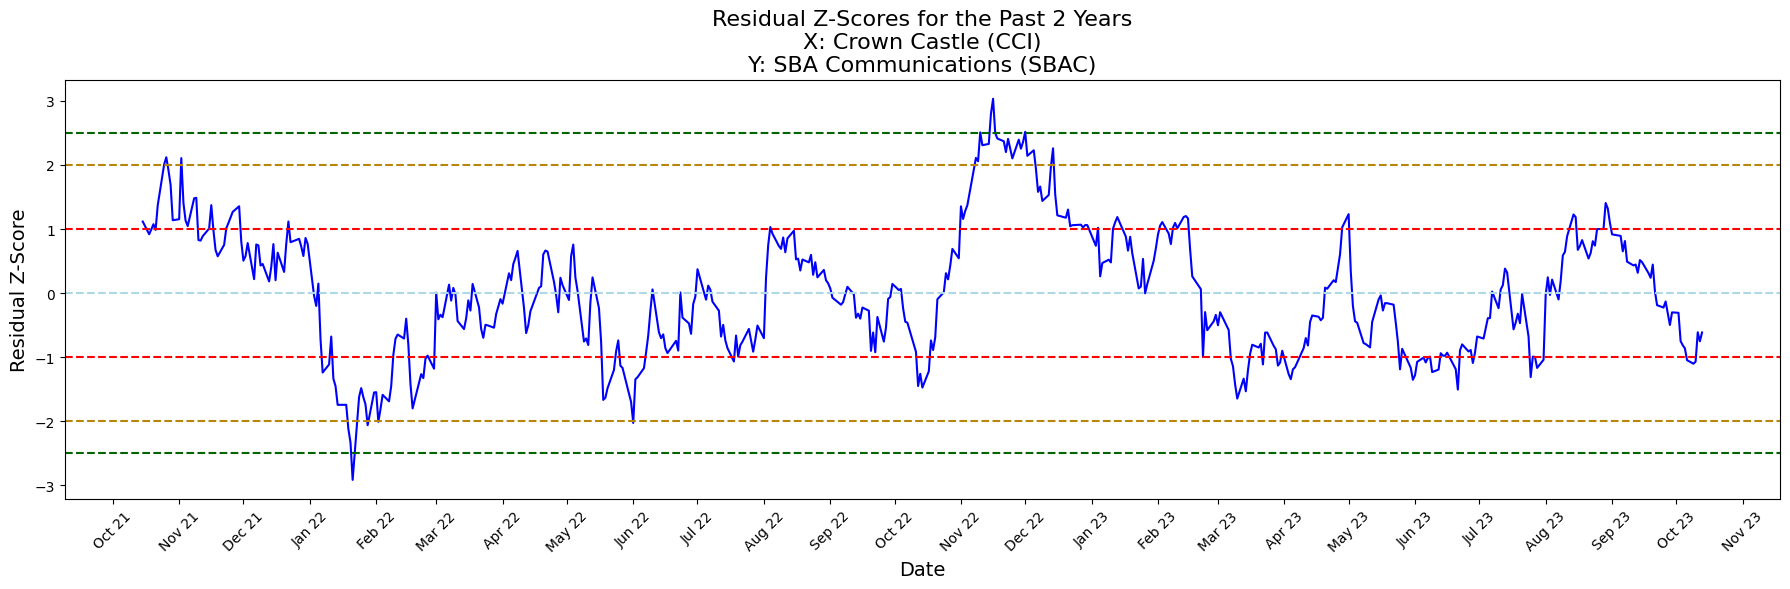

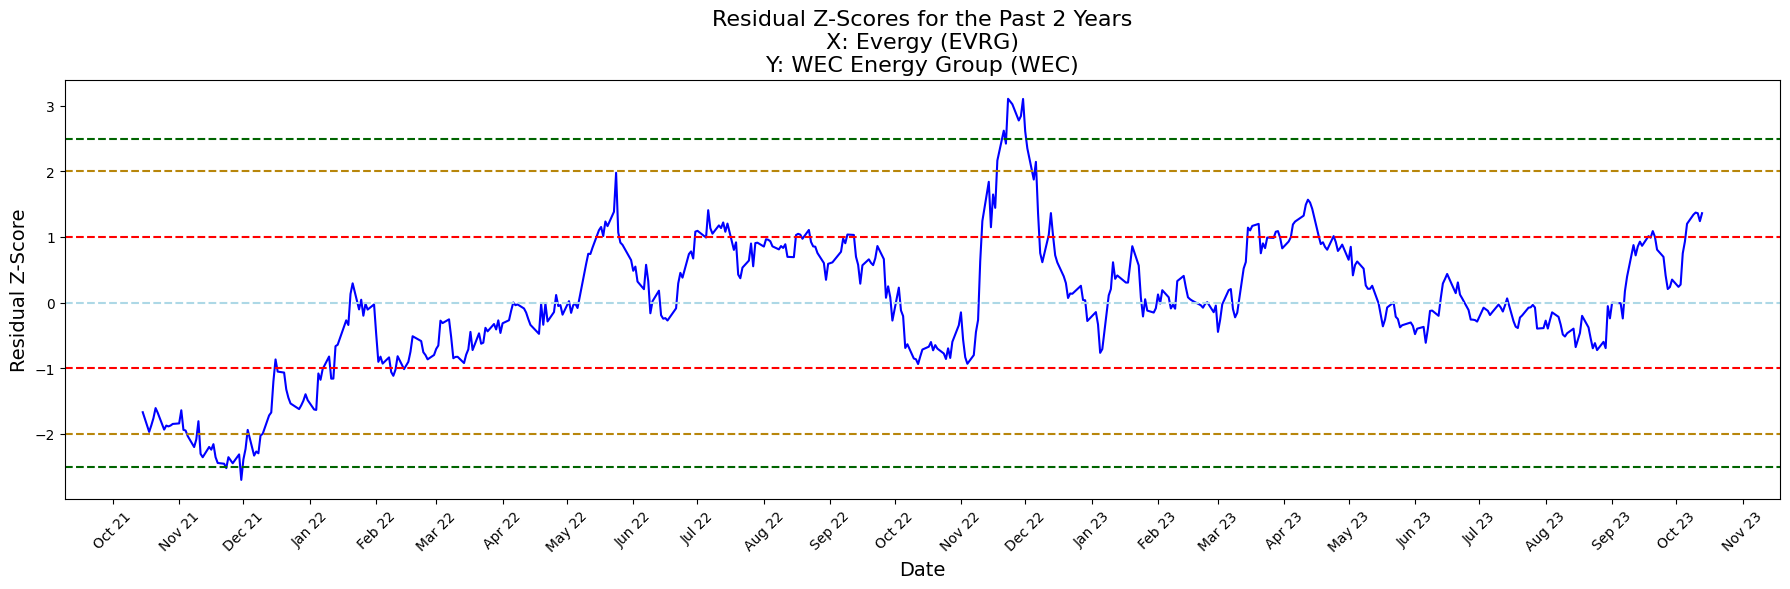

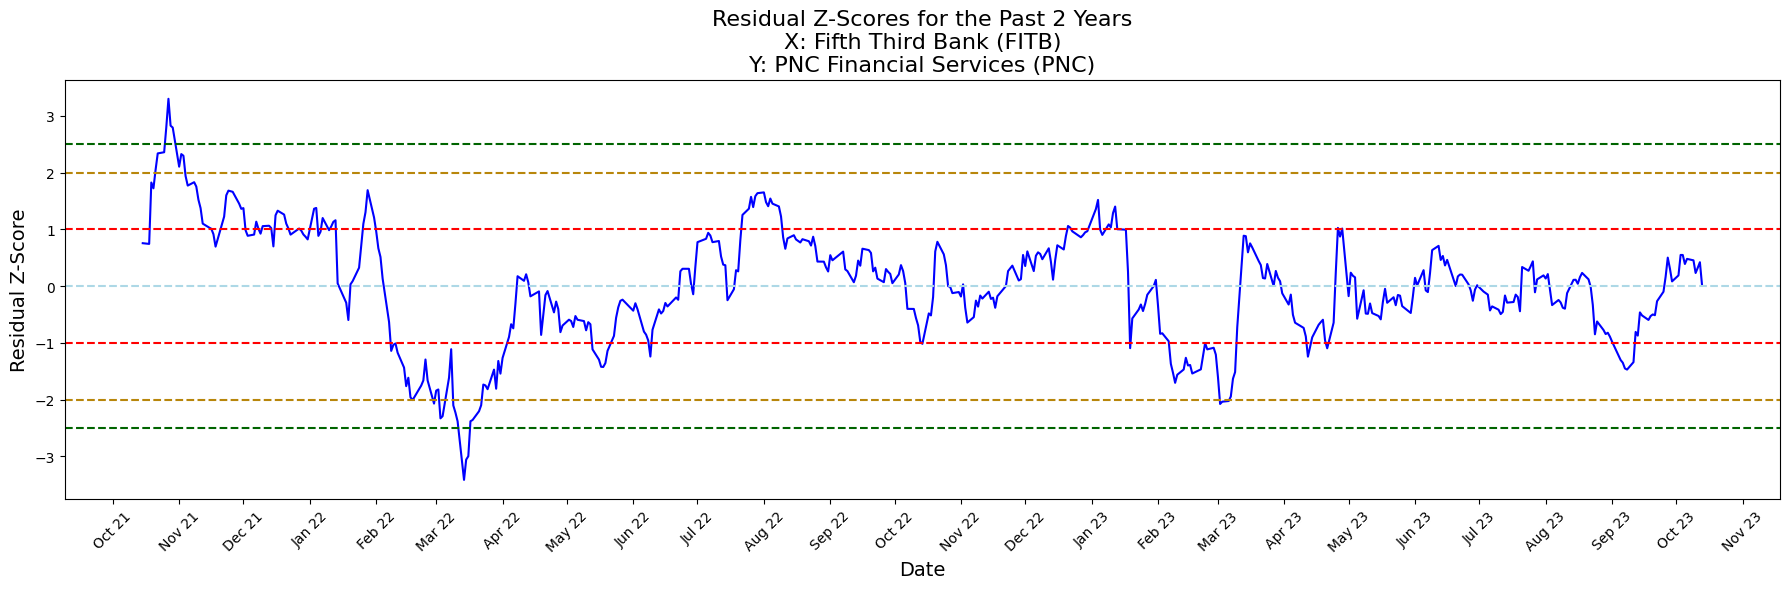

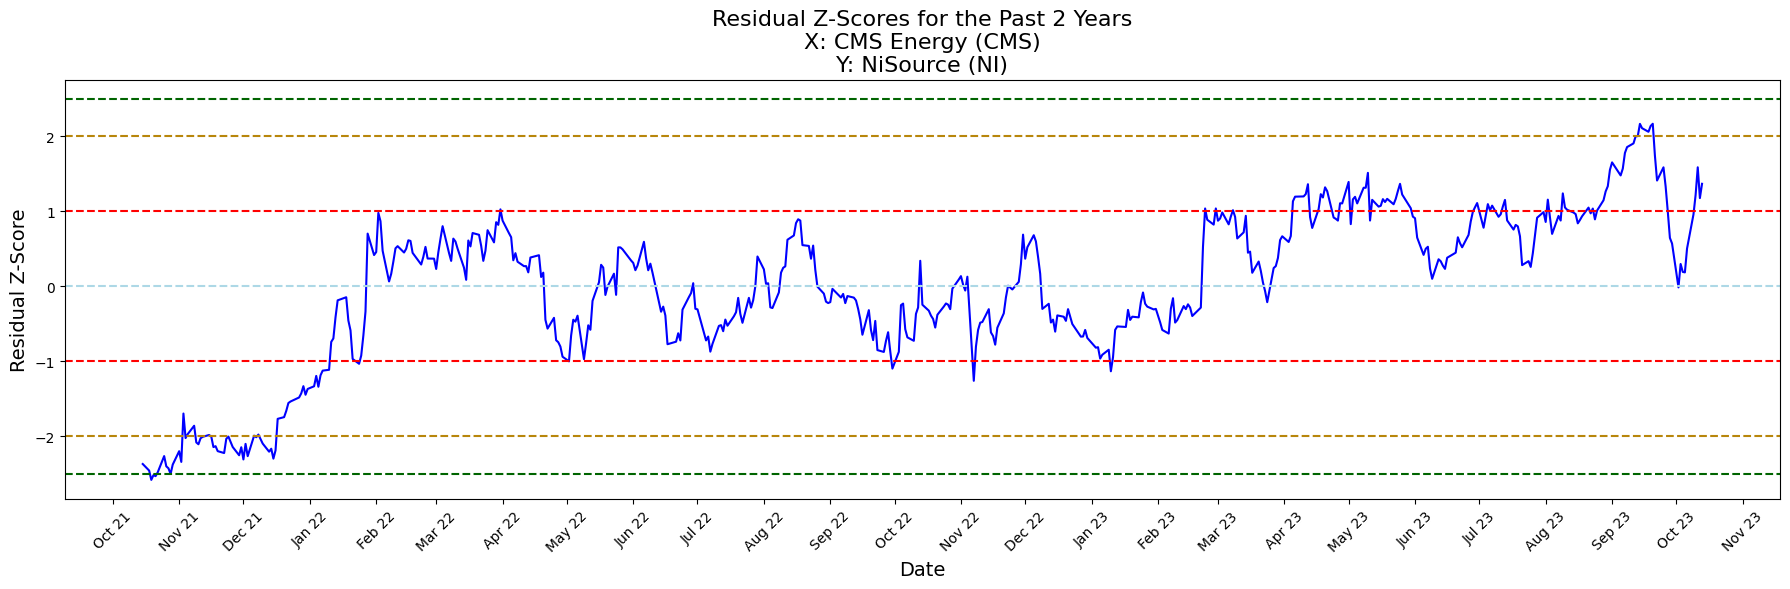

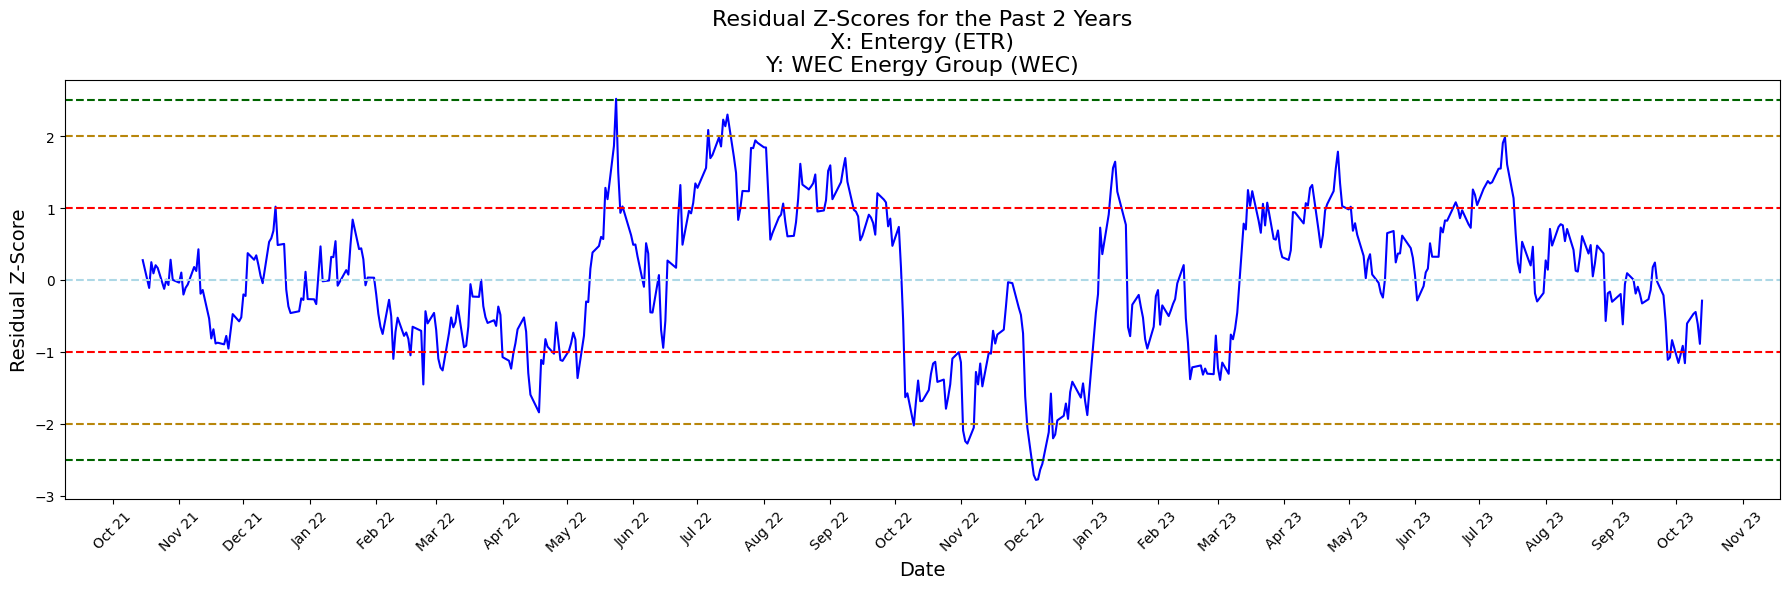

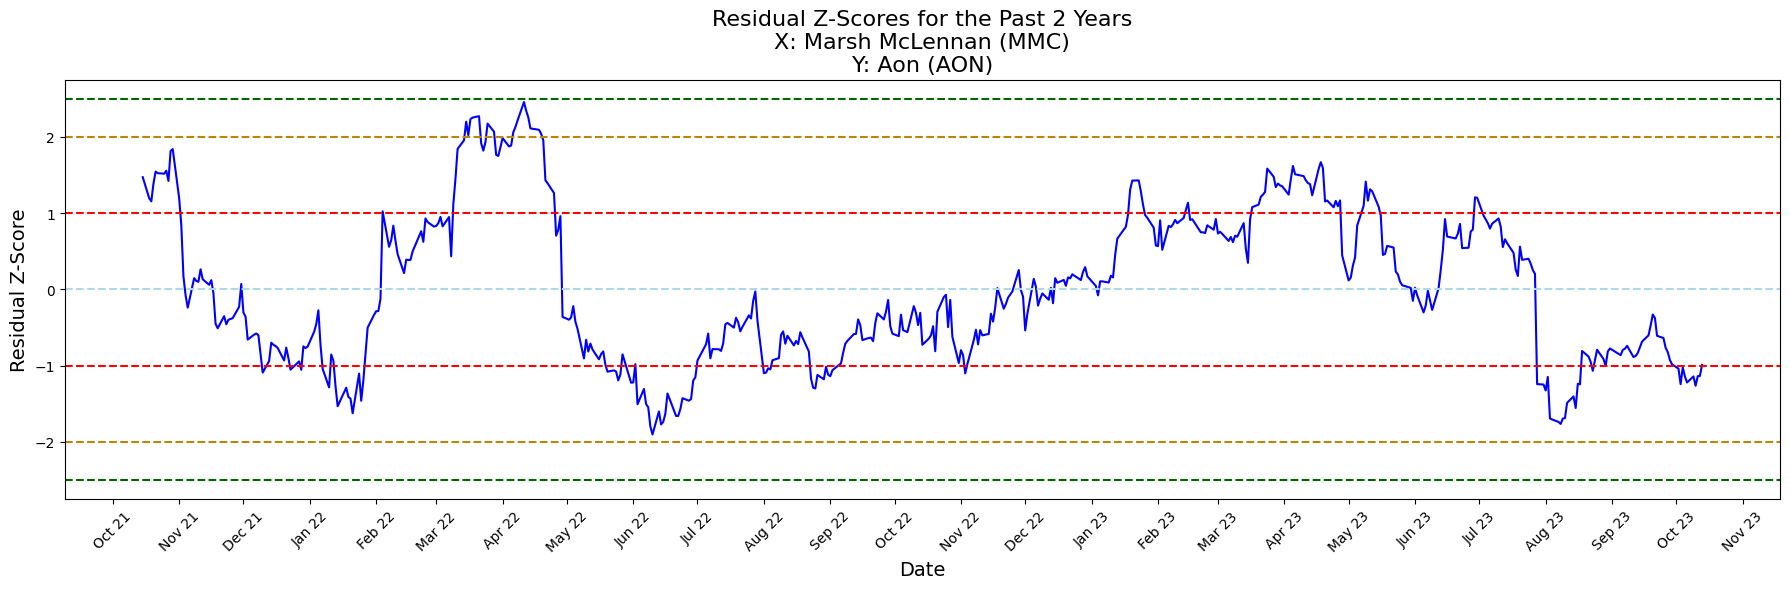

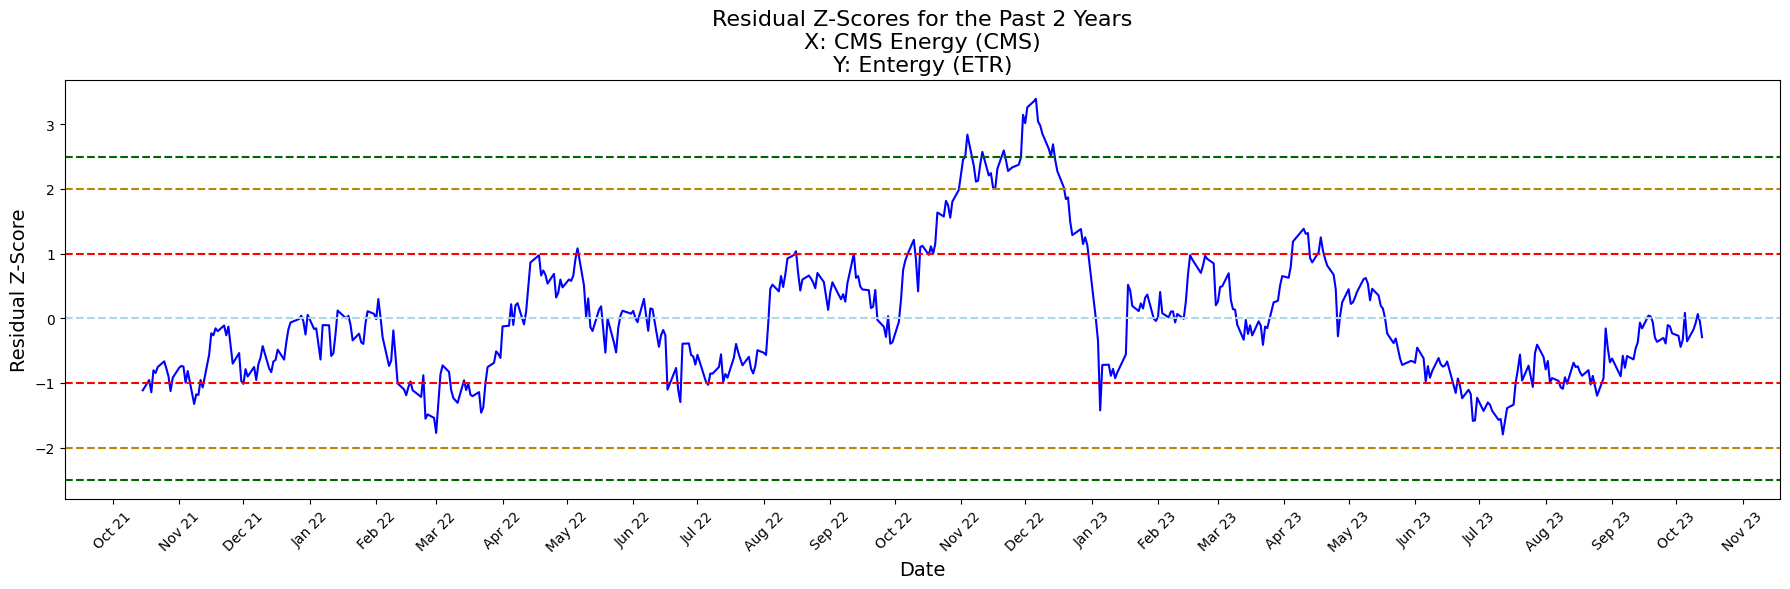

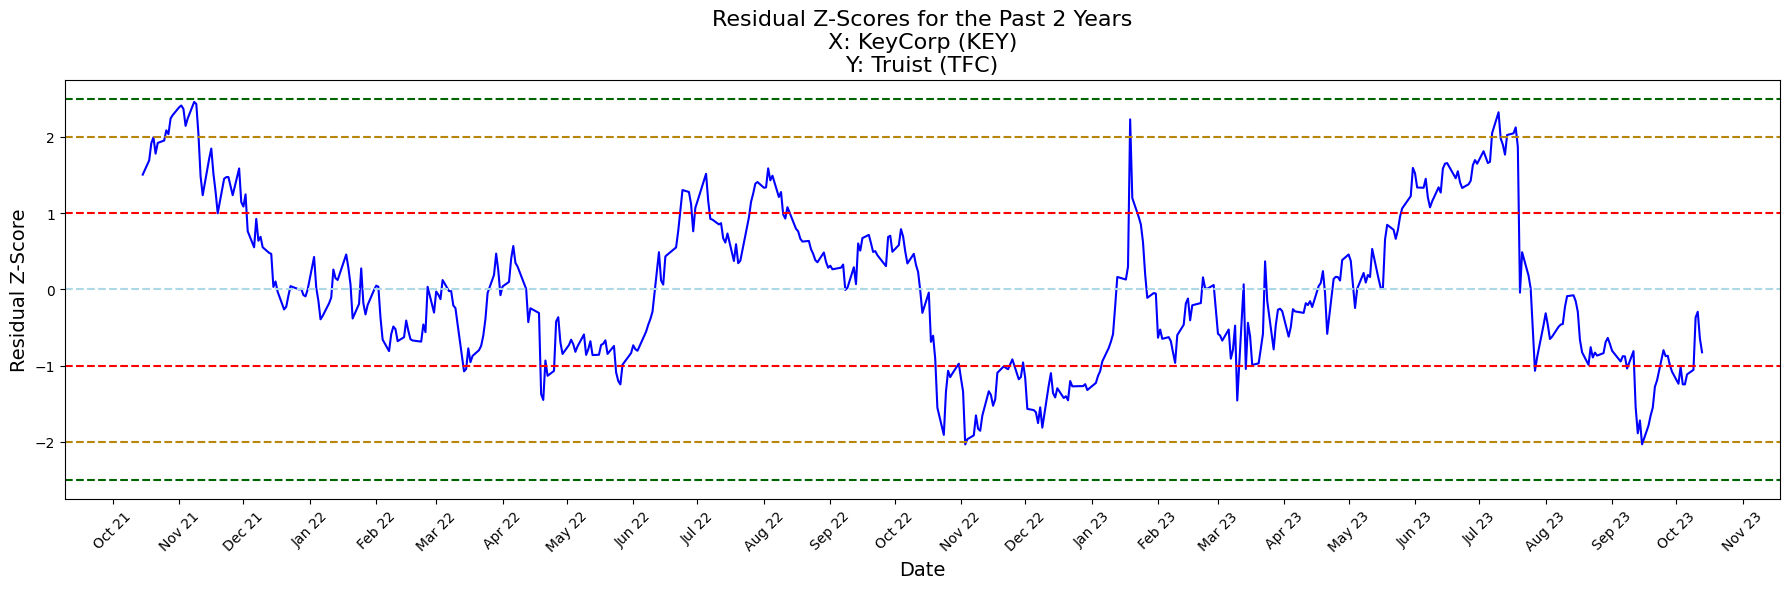

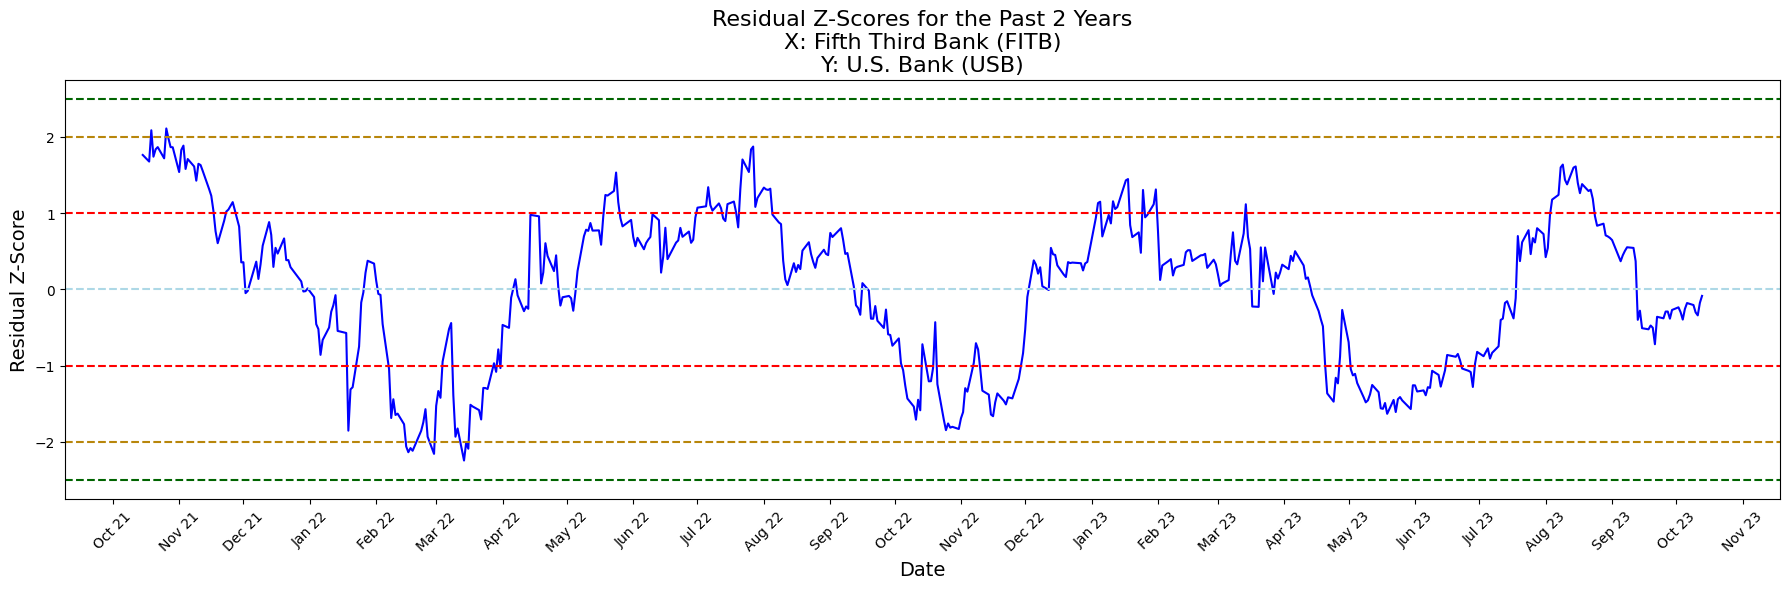

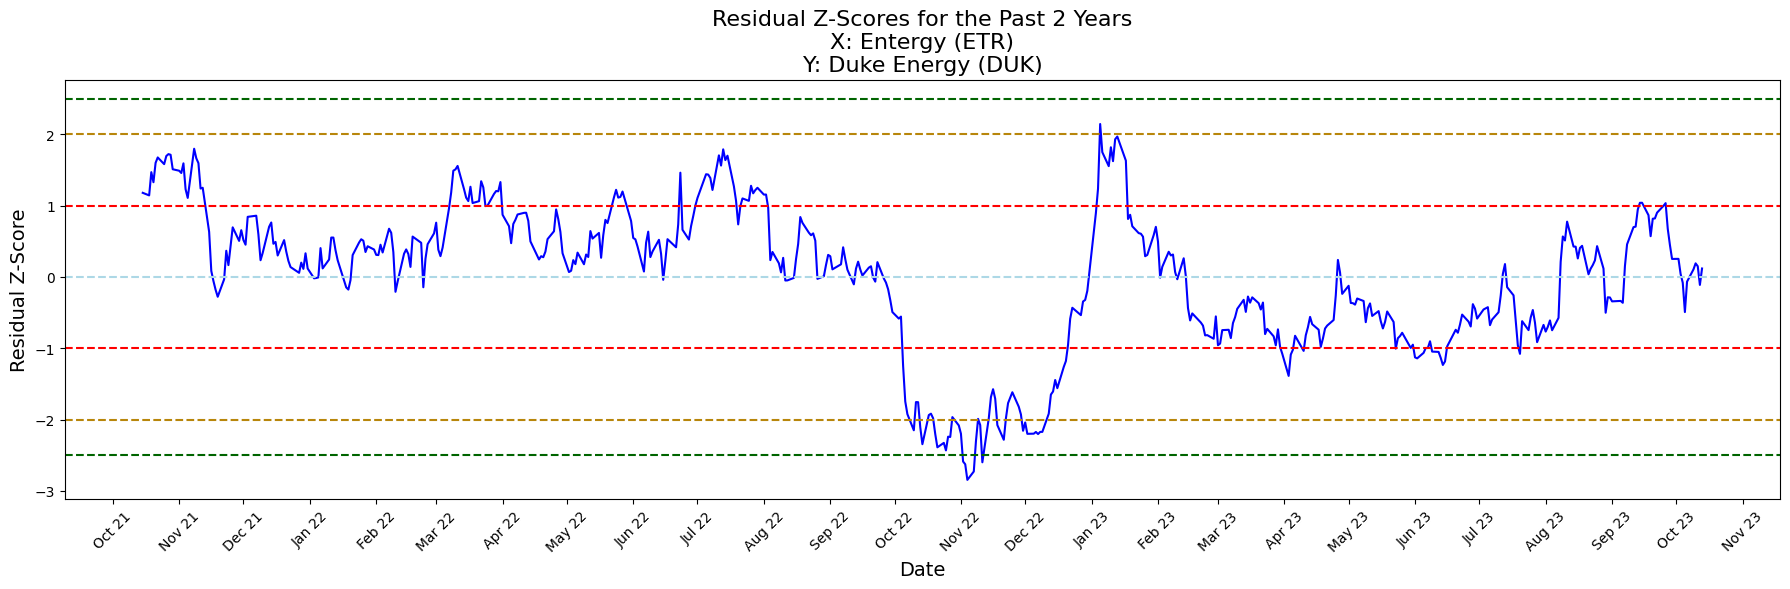

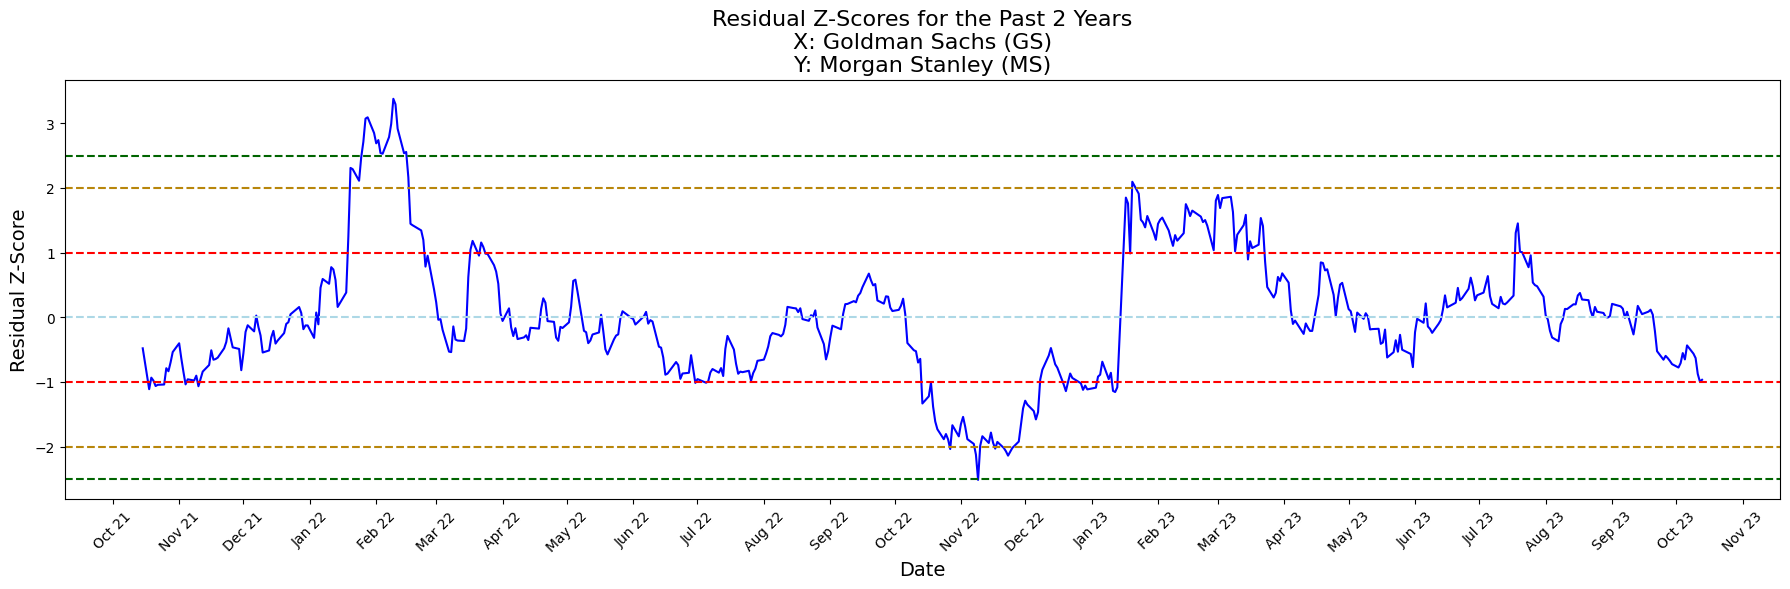

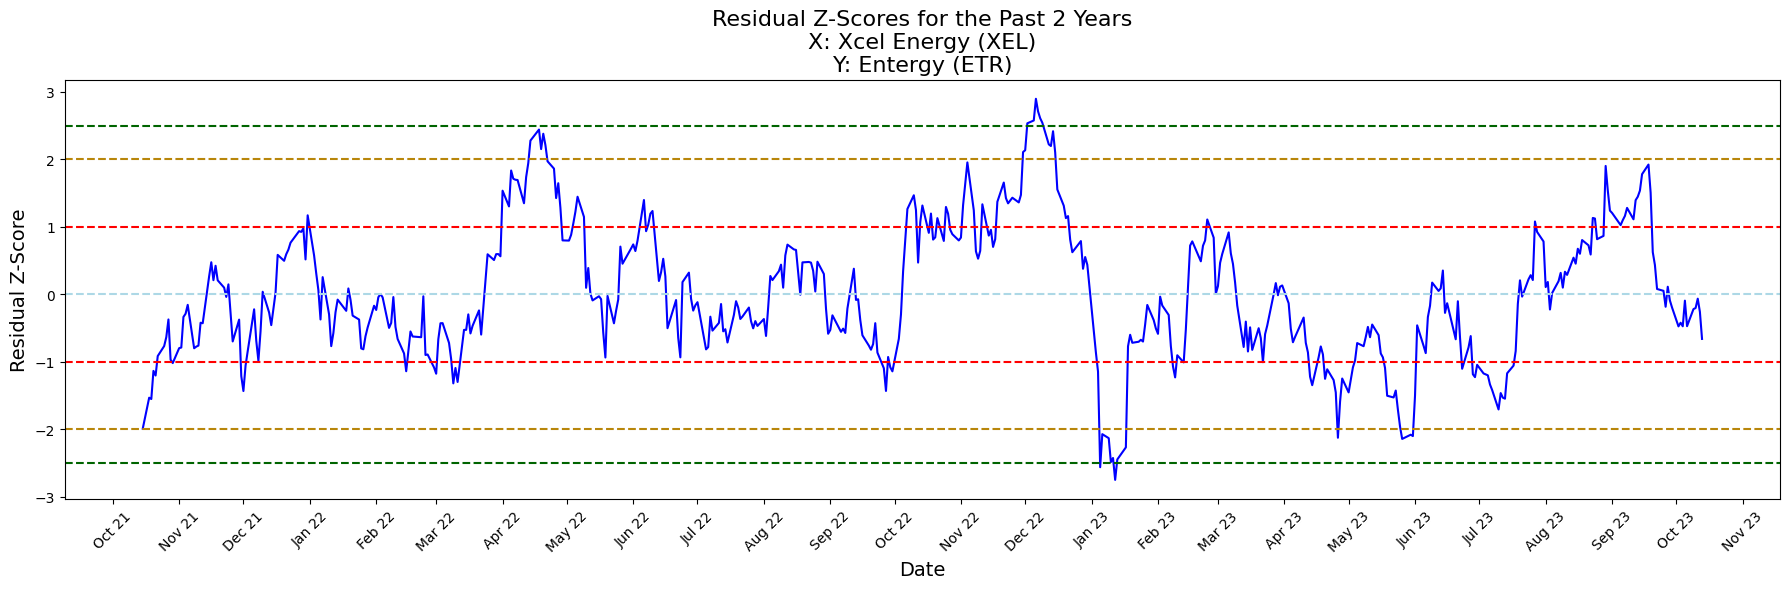

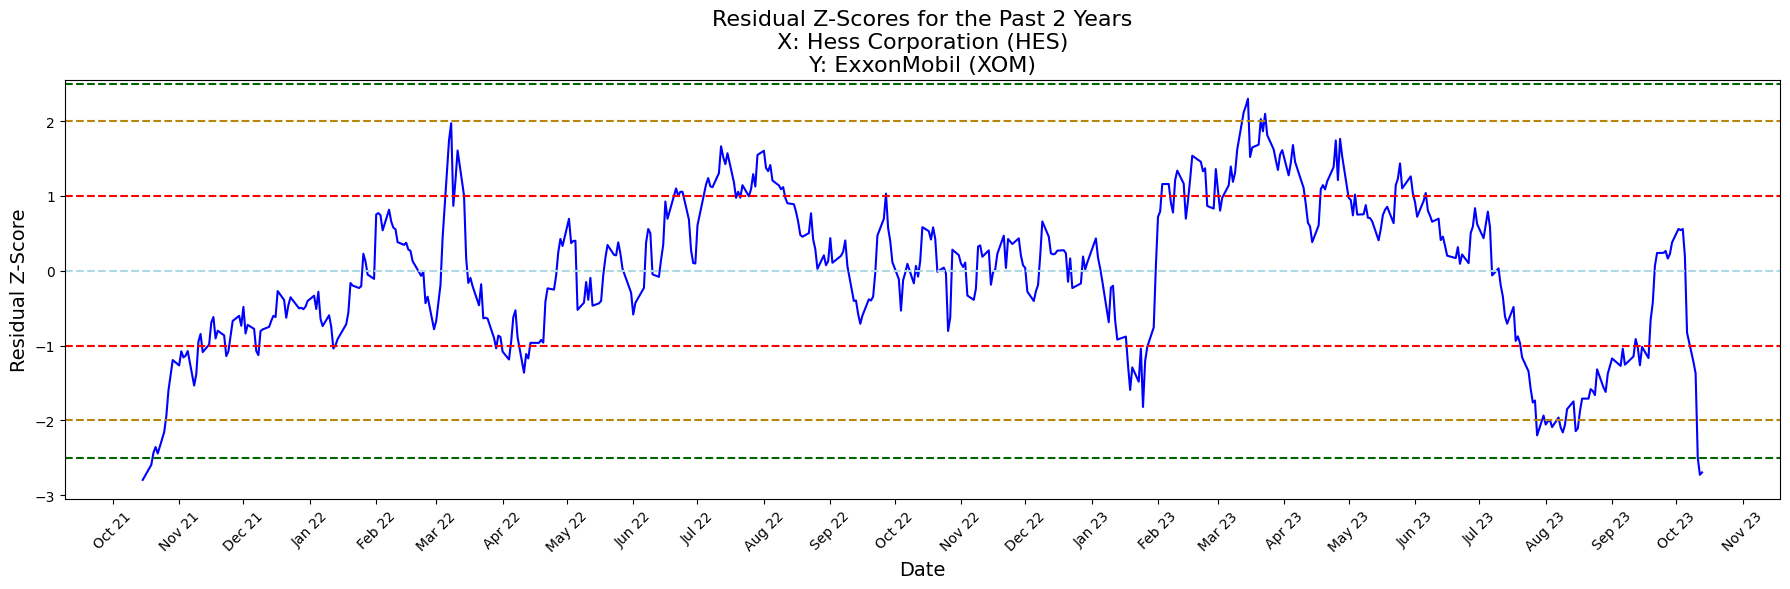

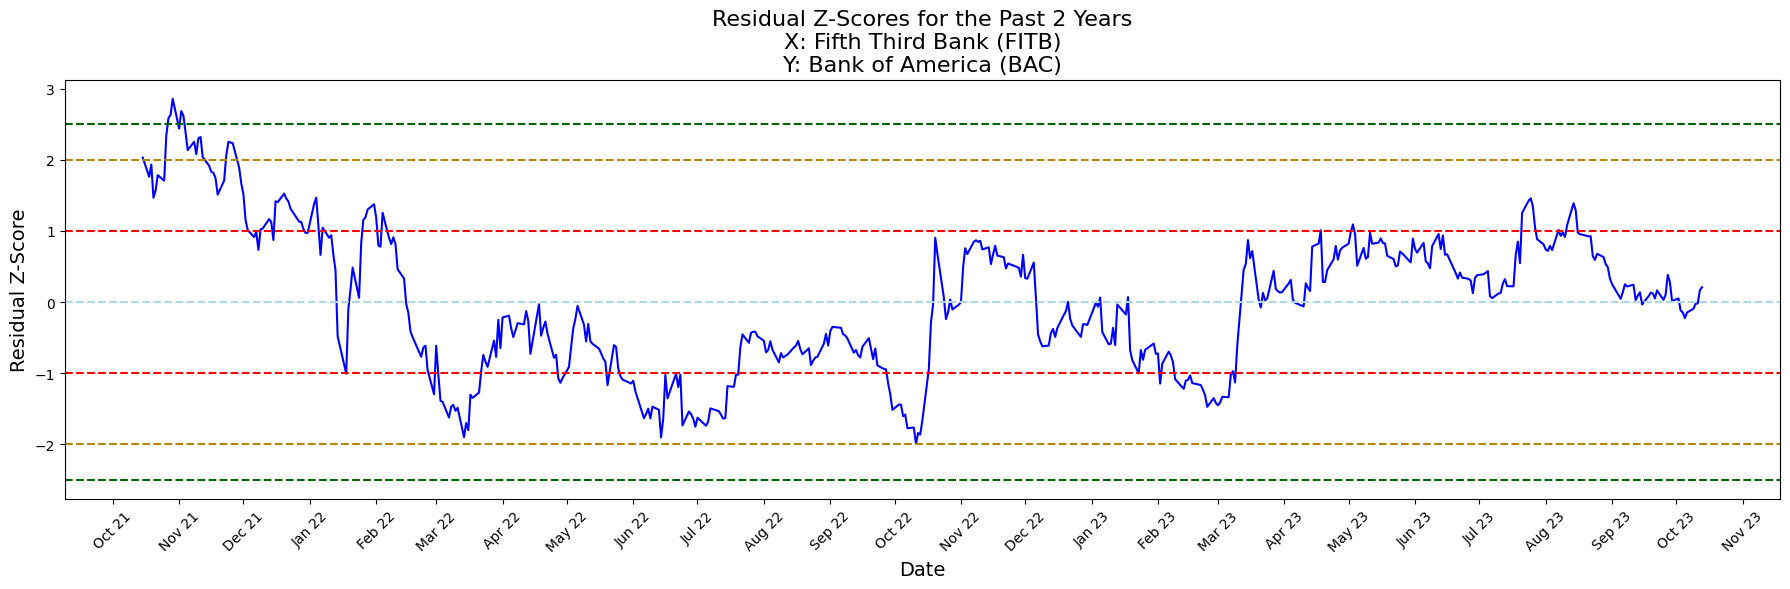

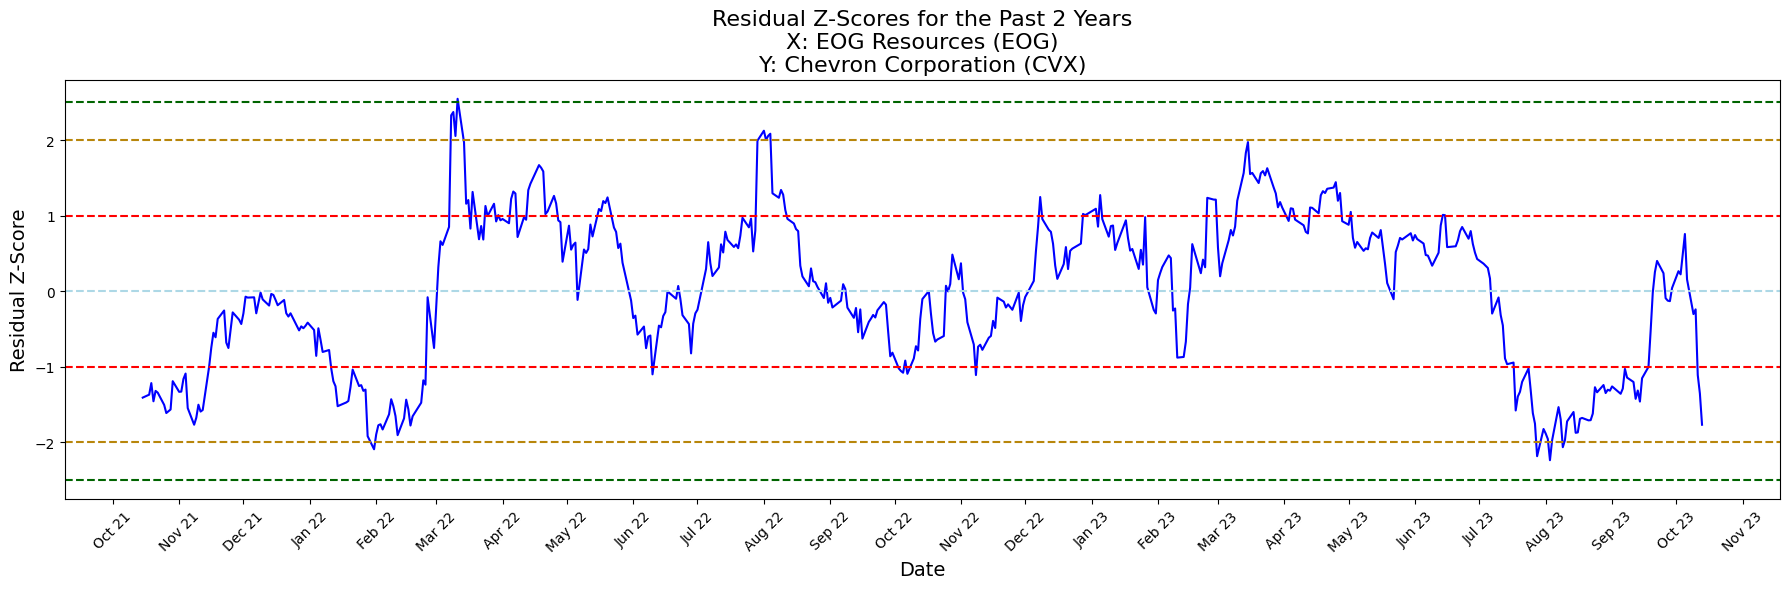

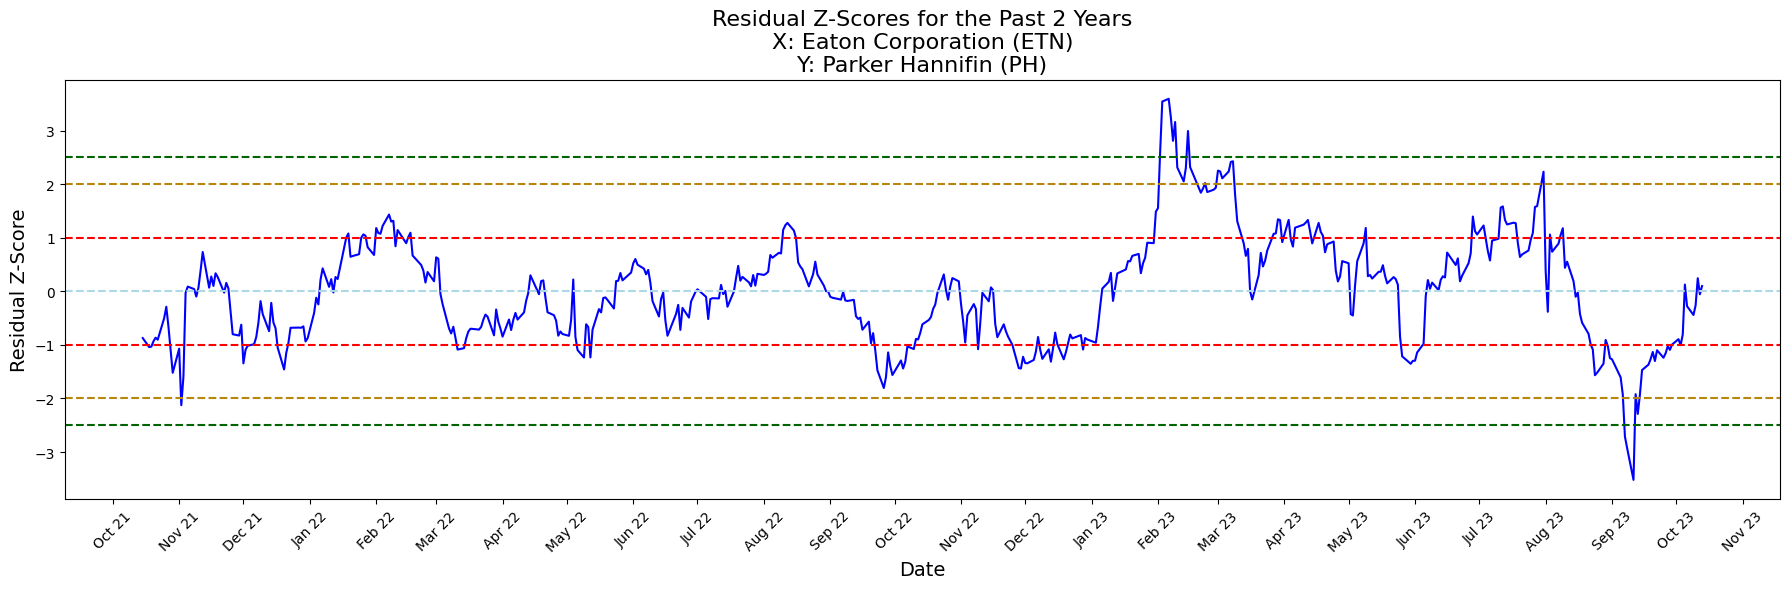

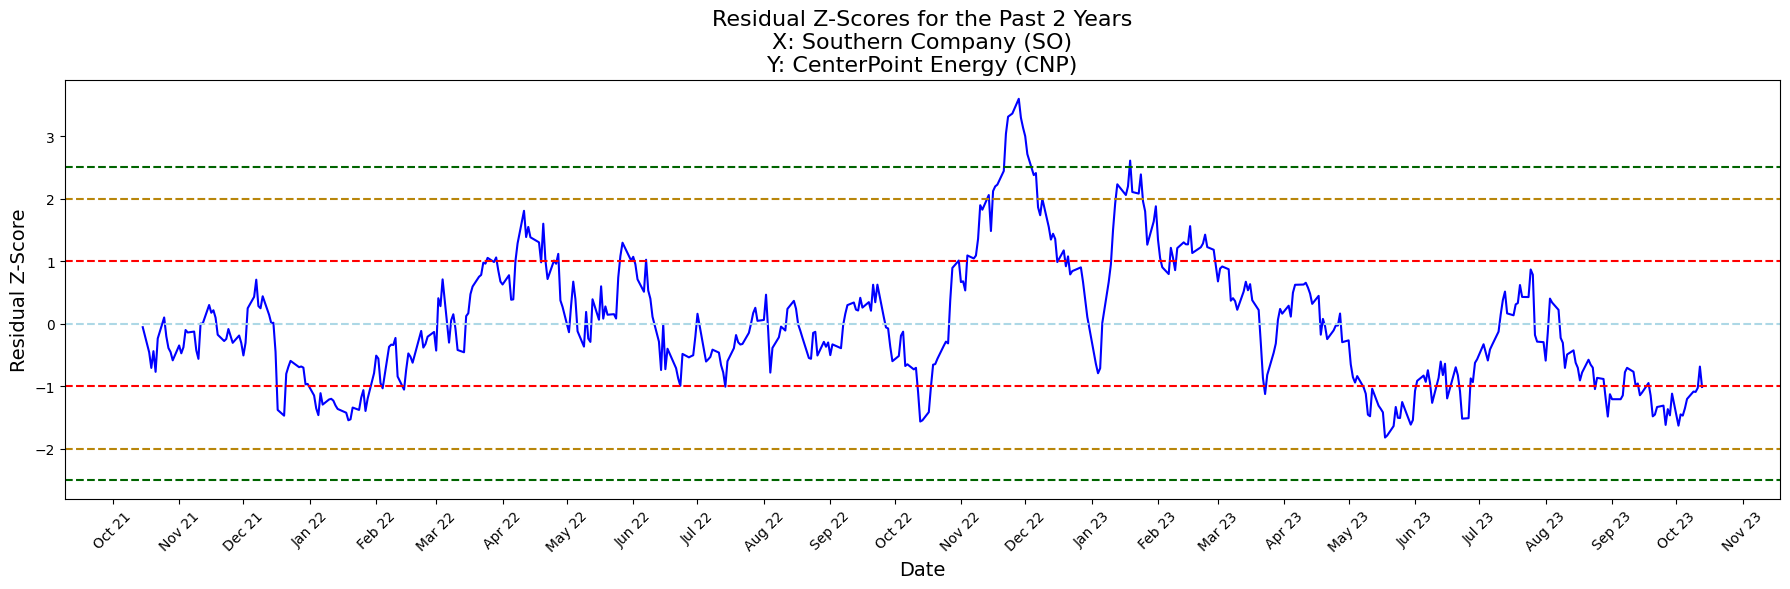

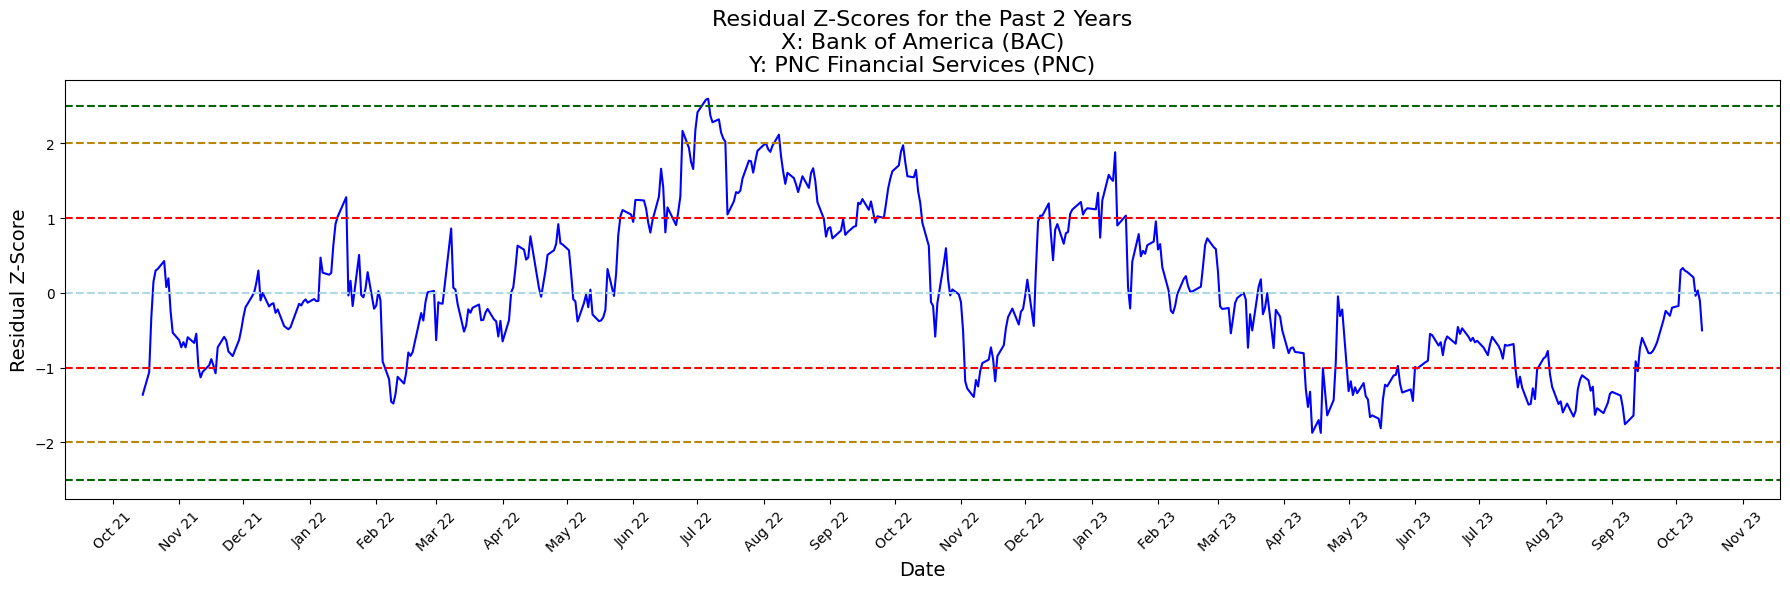

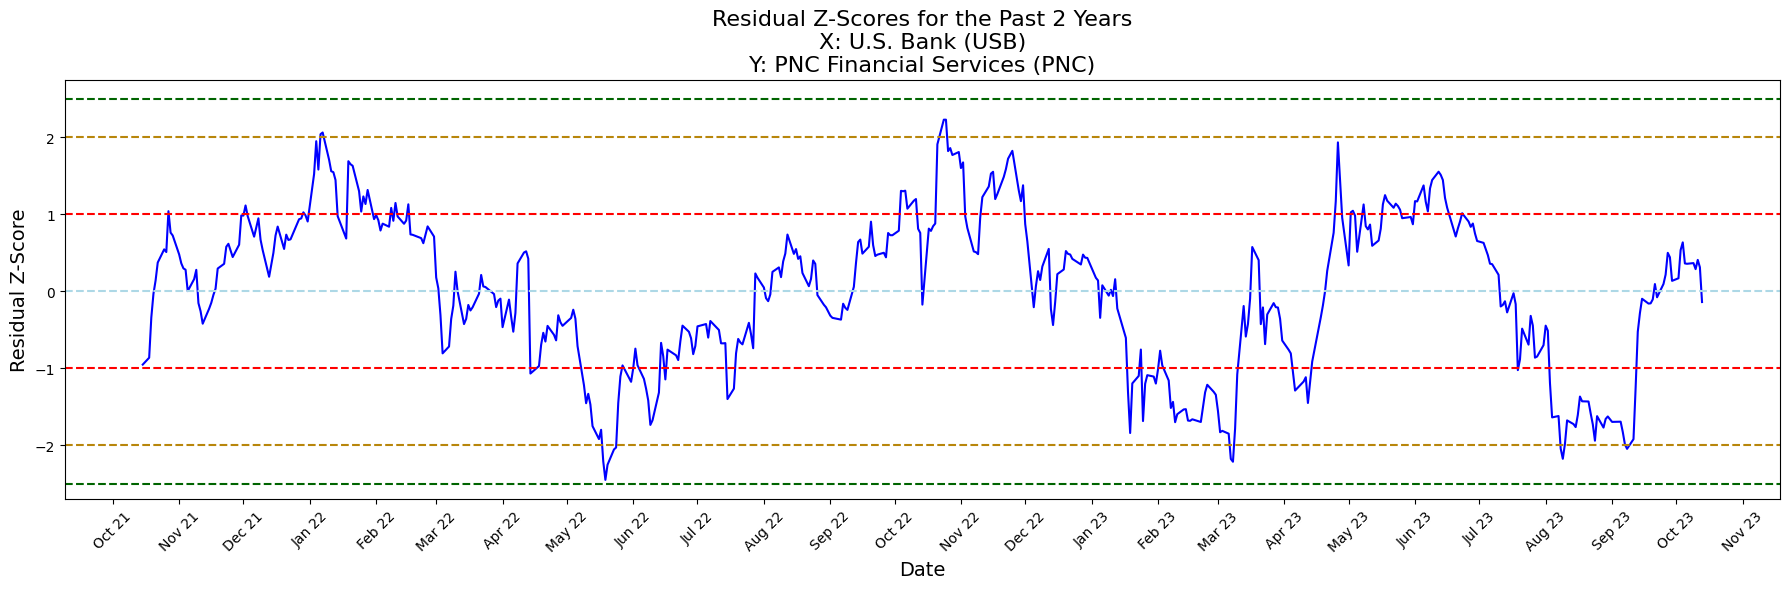

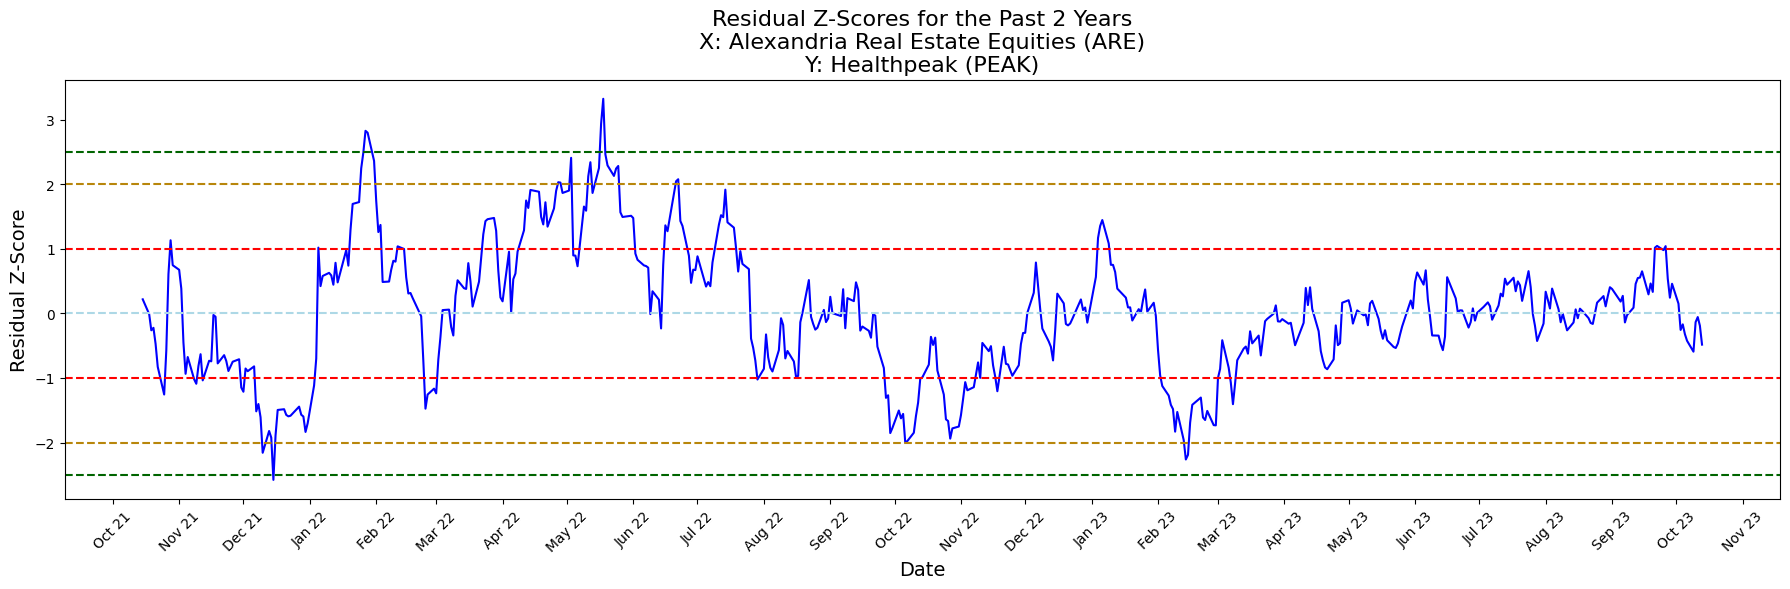

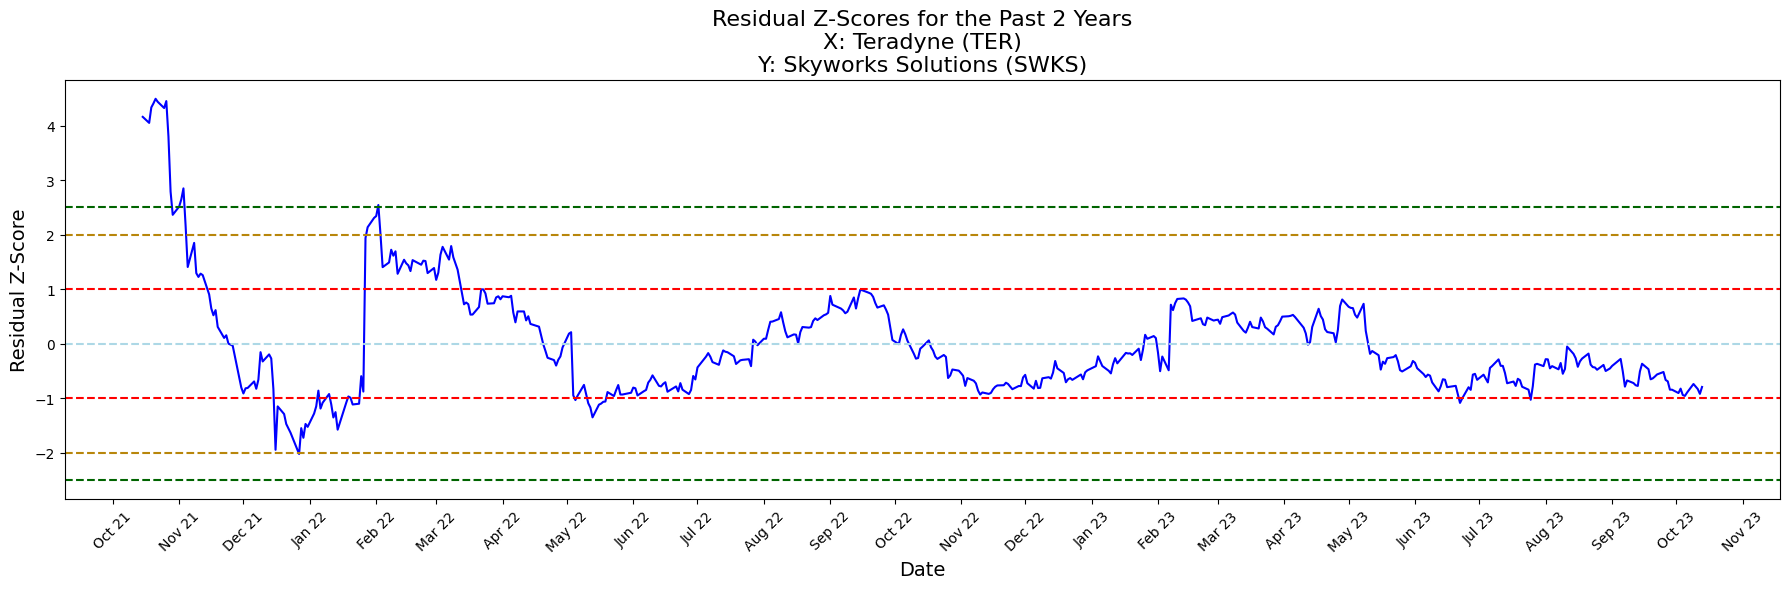

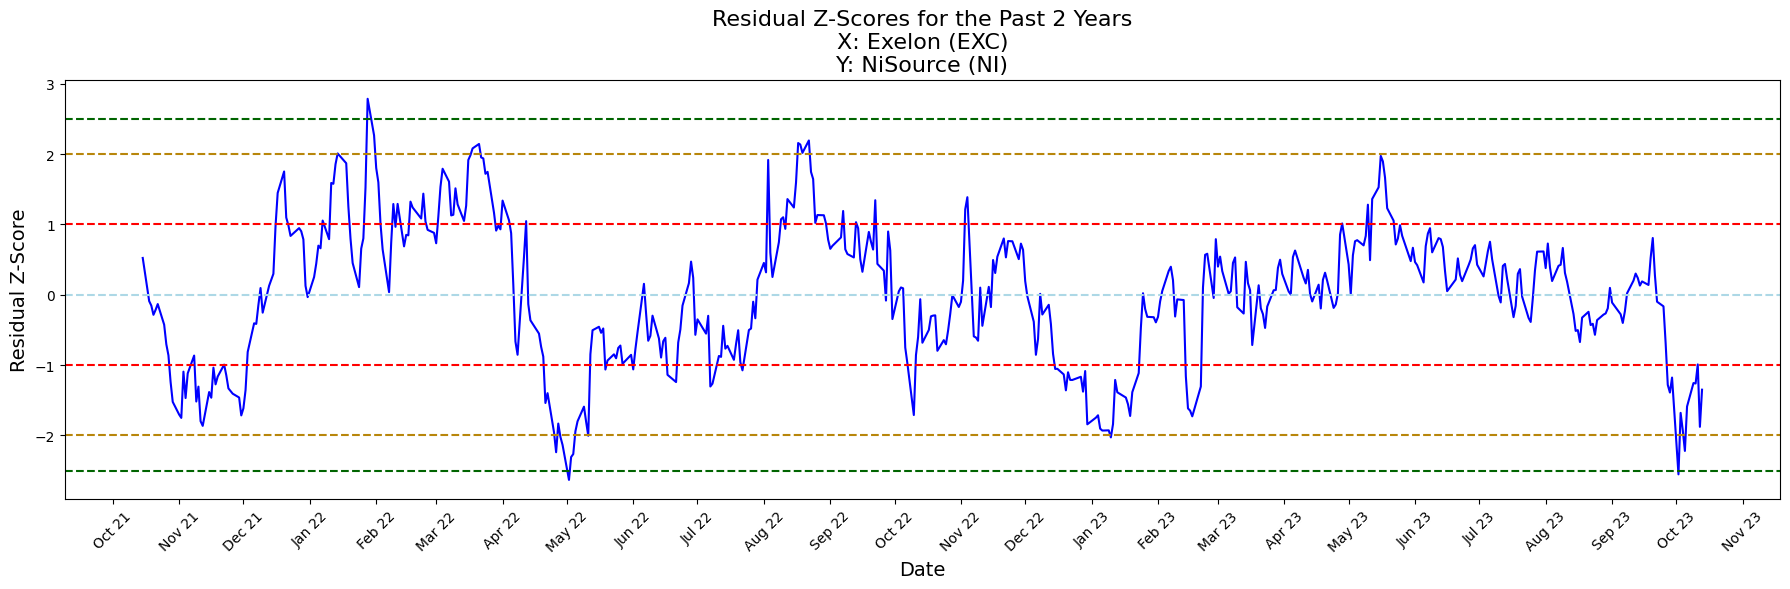

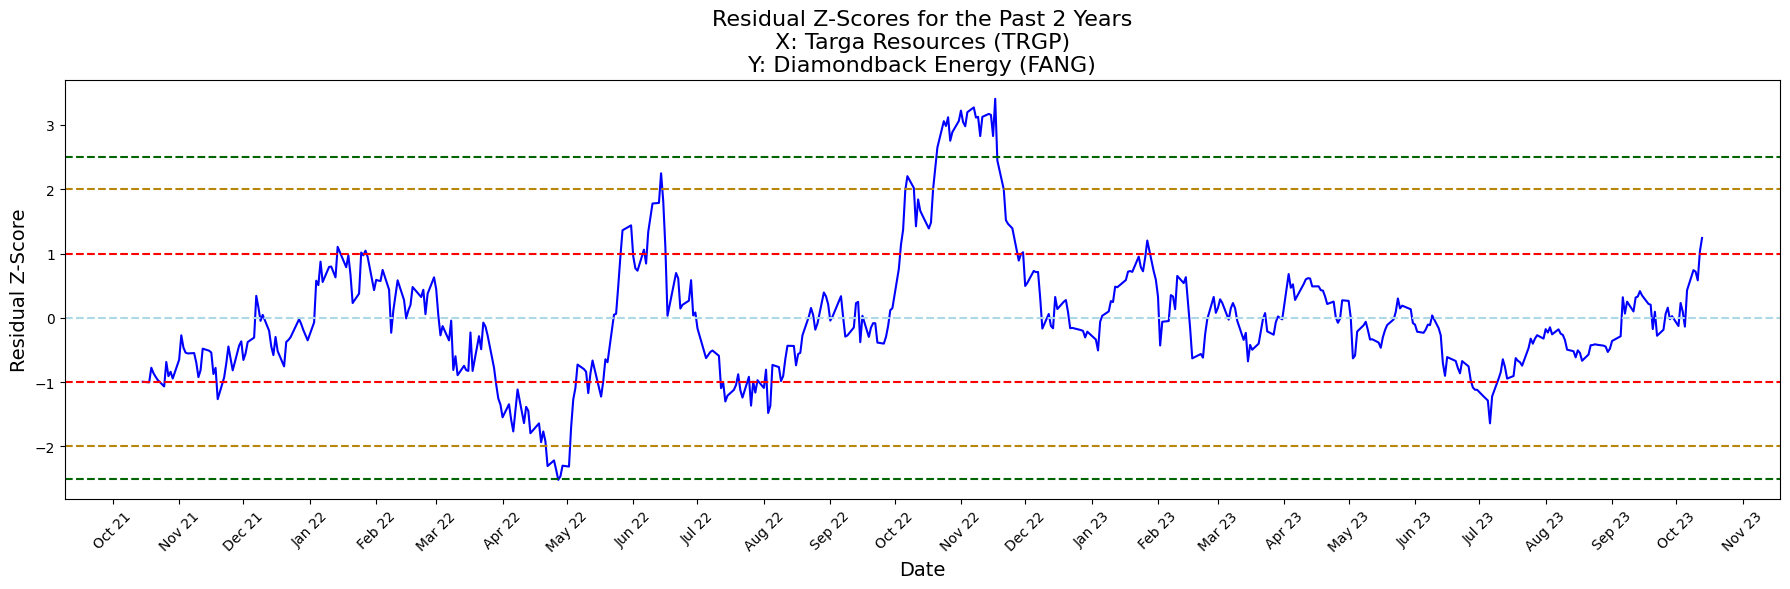

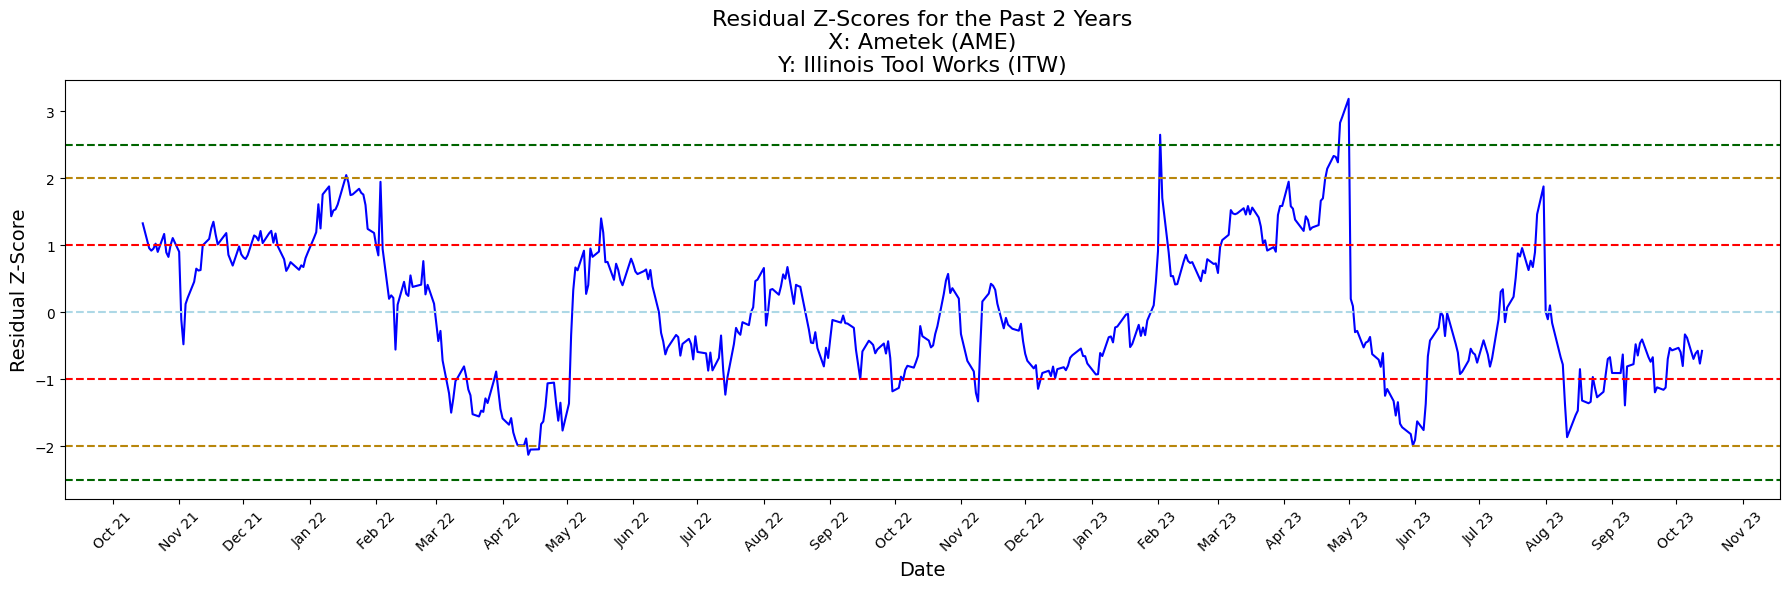

In [42]:
for i in range(len(regressionResults)):
    plotResiduals(regressionResults.iloc[i]["residualSeries"], 
                  regressionResults.iloc[i]["stdevResidualSeries"], 
                  regressionResults.iloc[i]["companyX"], 
                  regressionResults.iloc[i]["companyY"], 
                  regressionResults.iloc[i]["independent"], 
                  regressionResults.iloc[i]["dependent"])

##### Magnified Z-Score Series For the Past Month

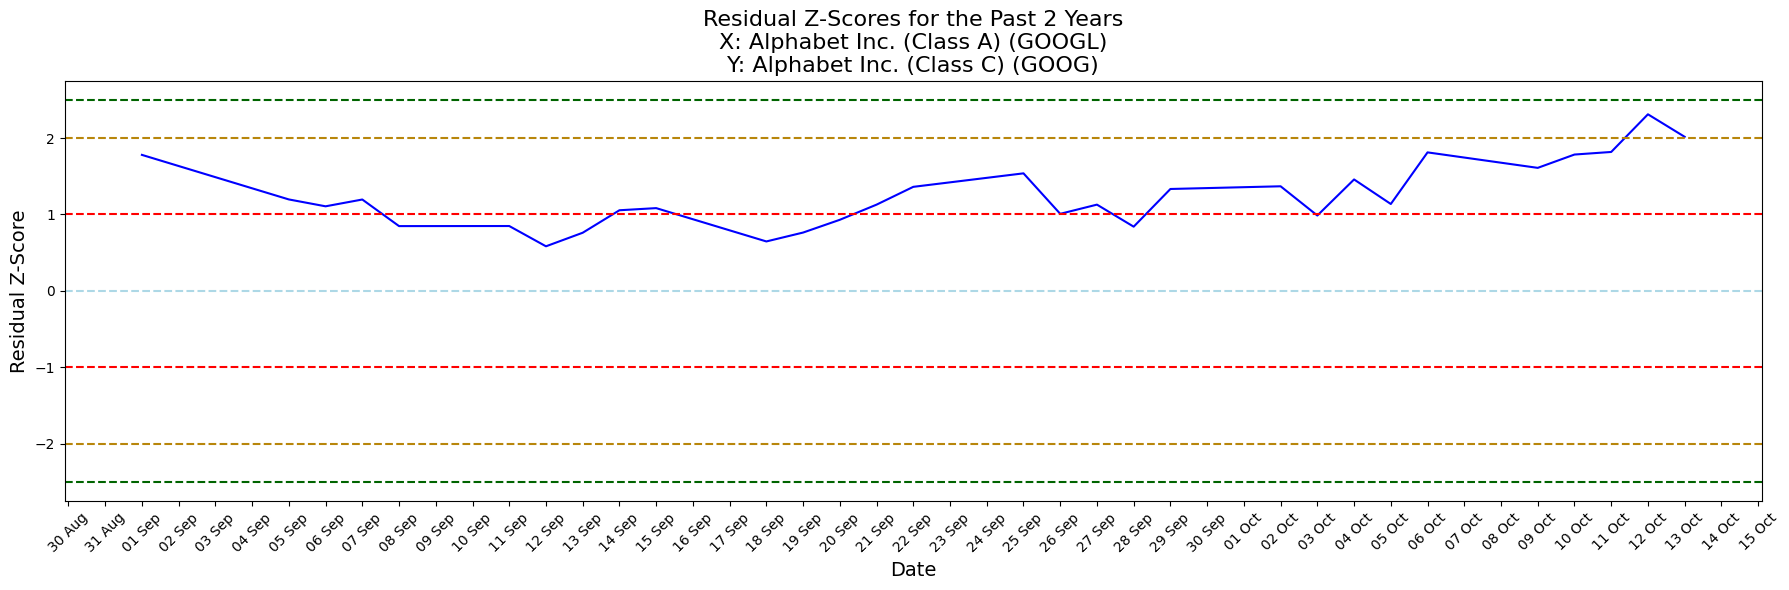

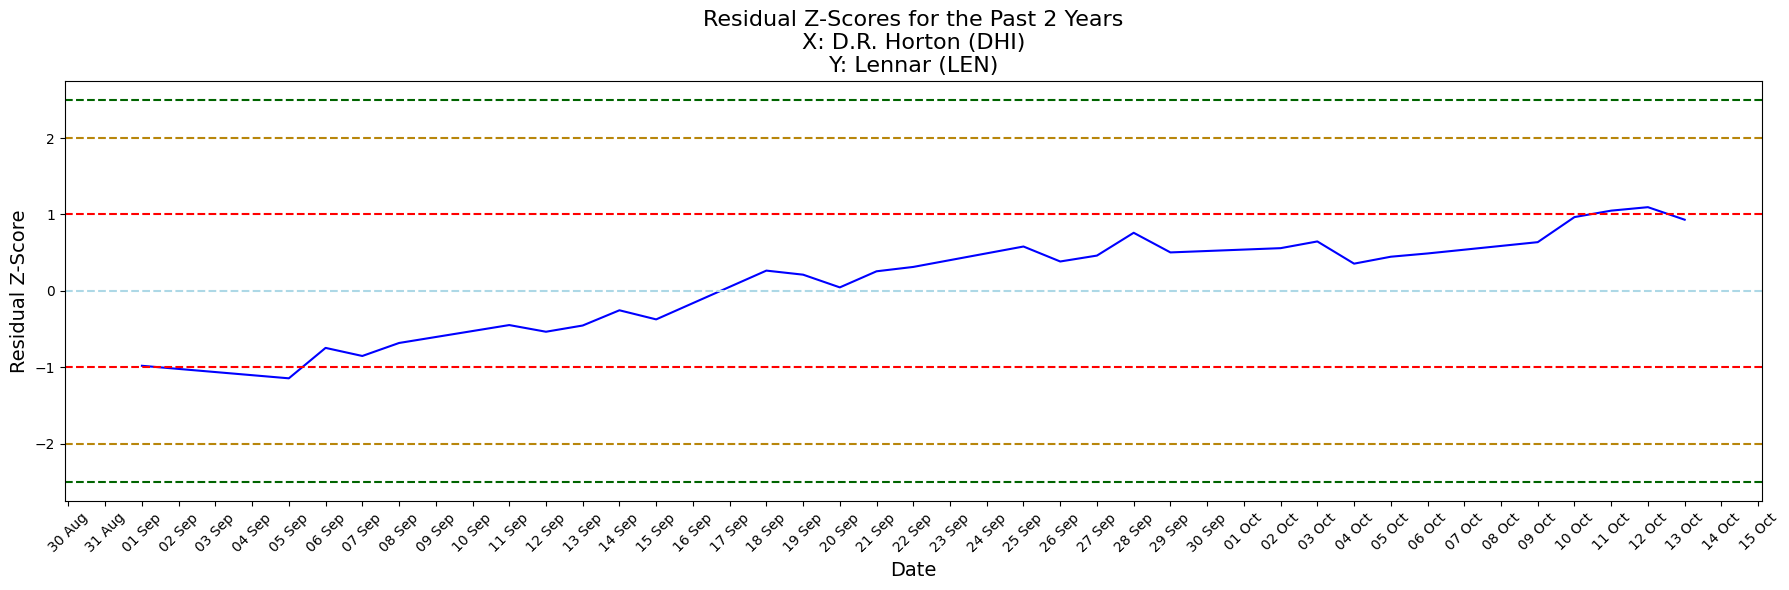

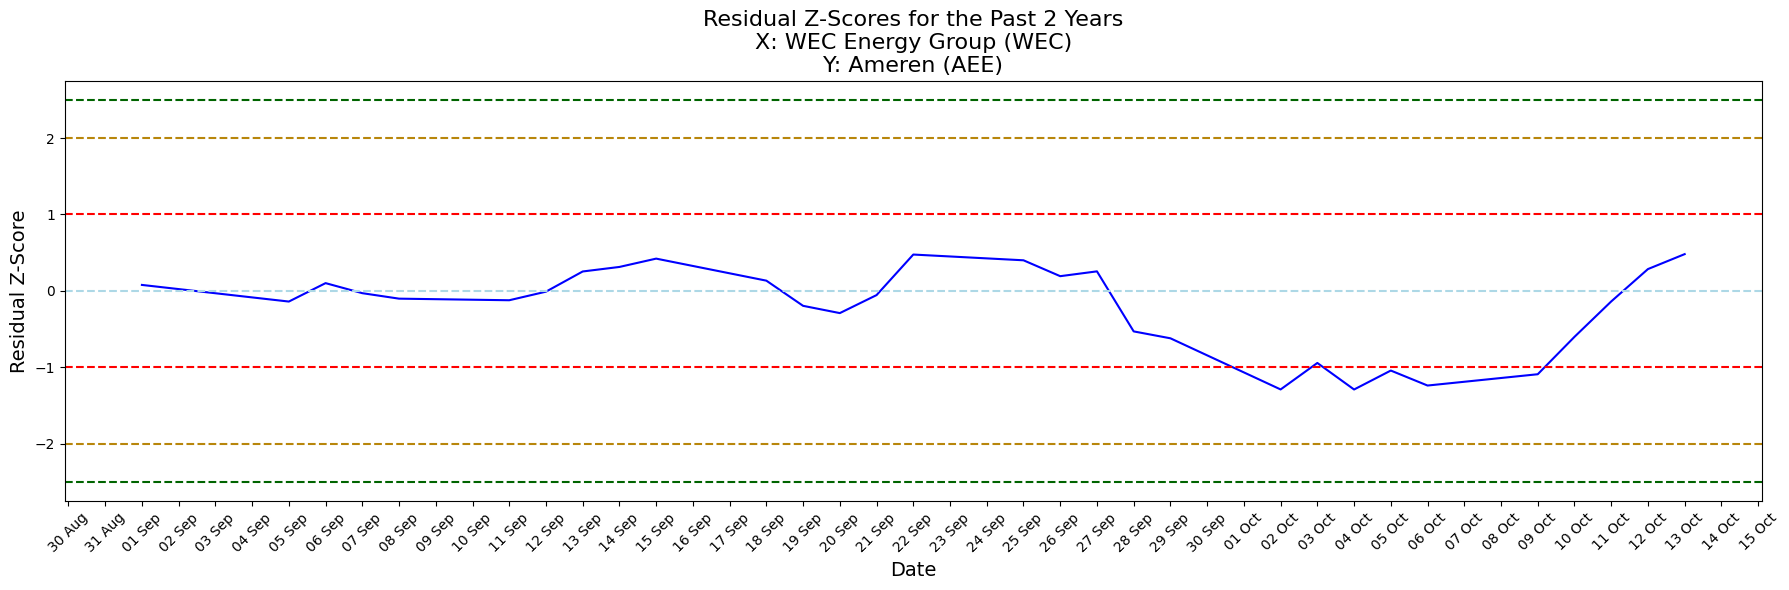

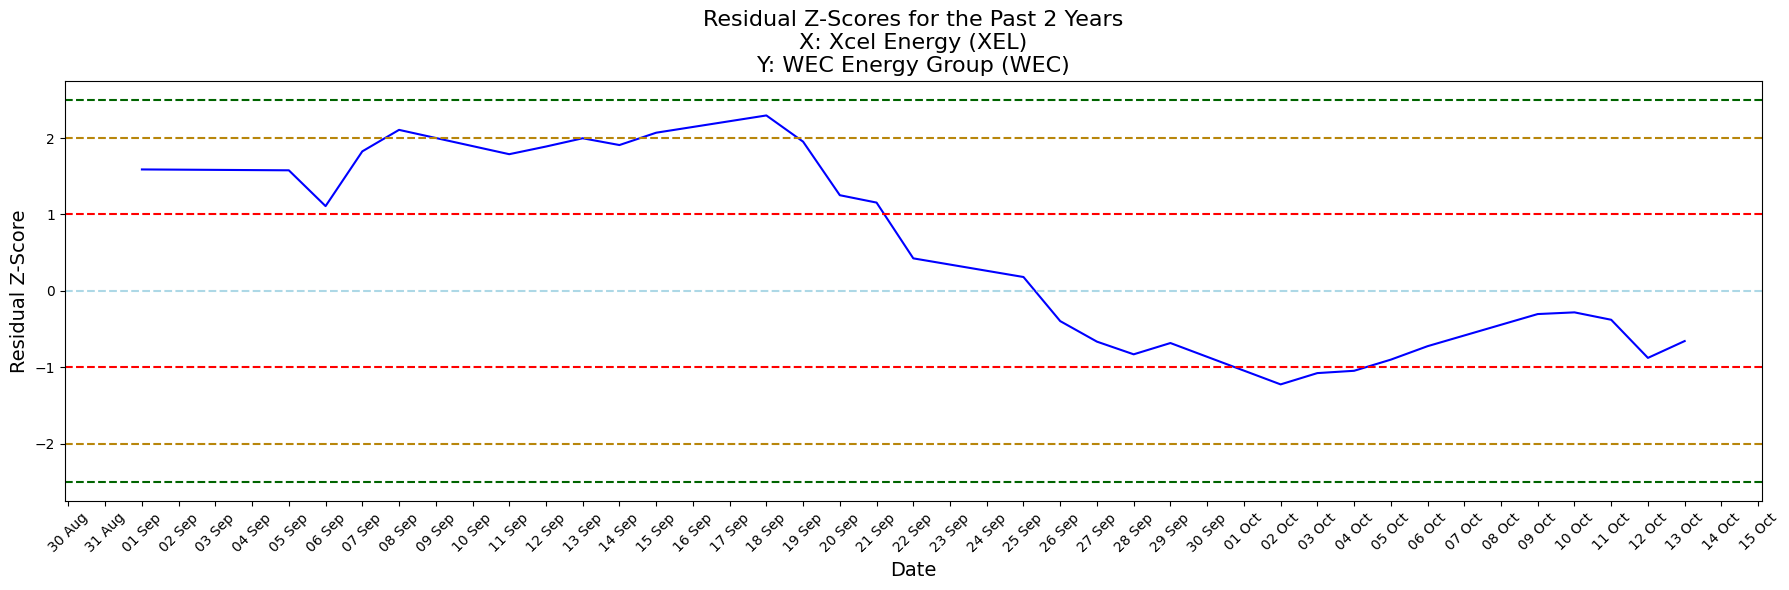

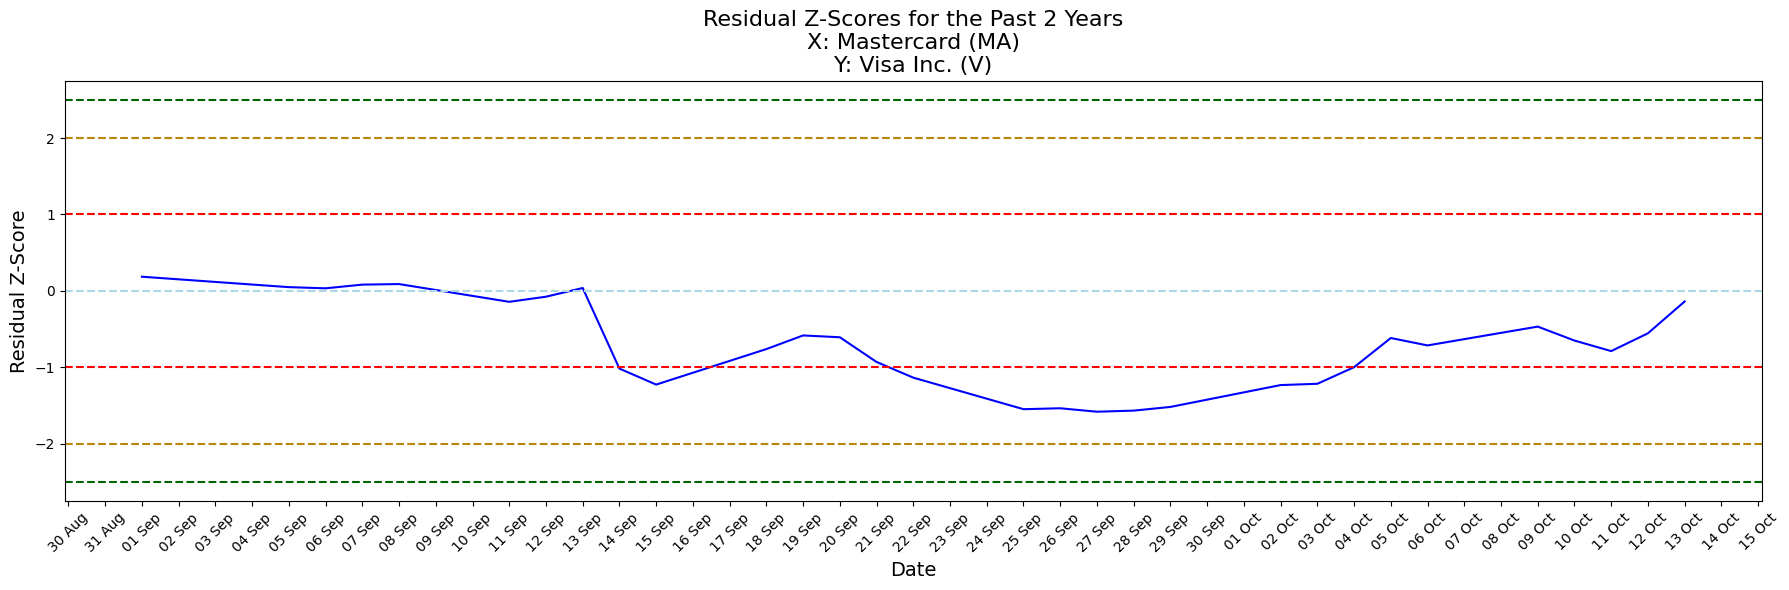

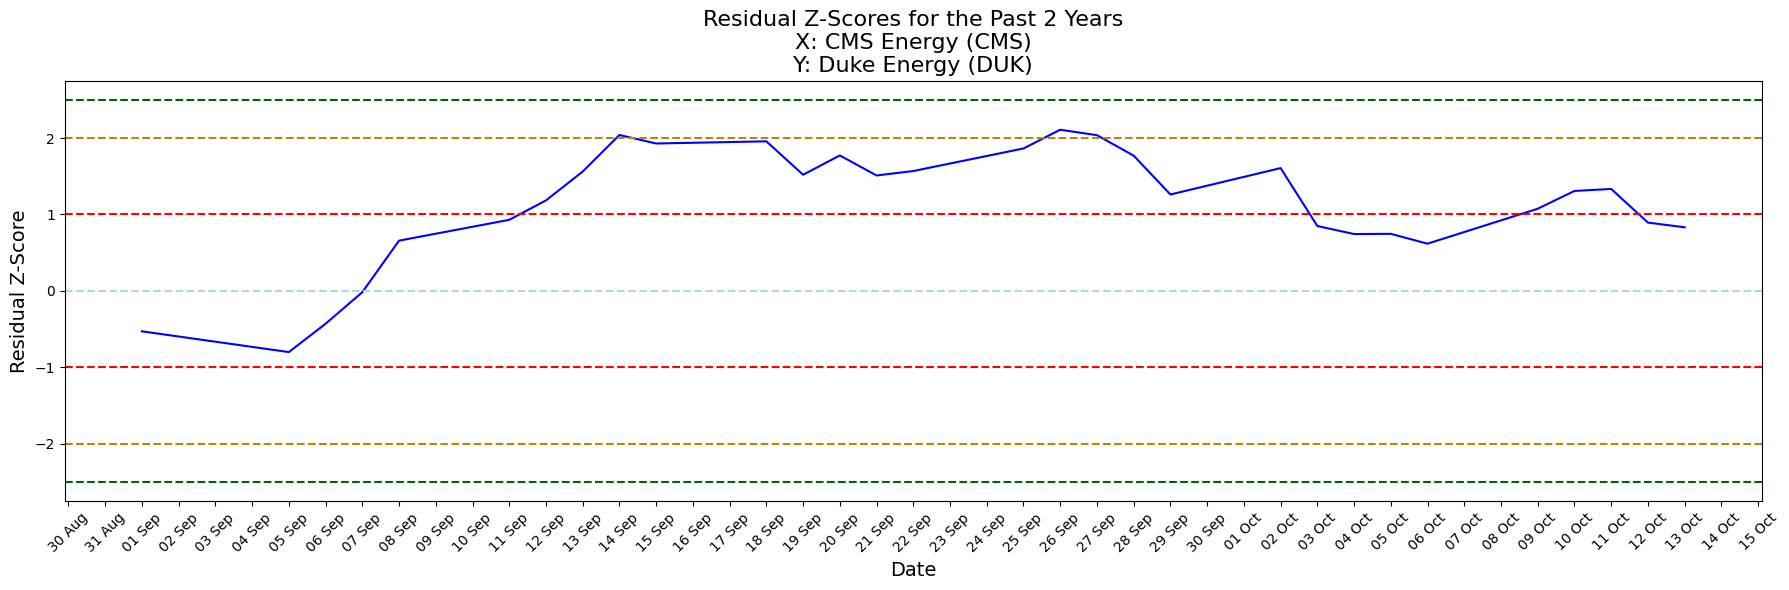

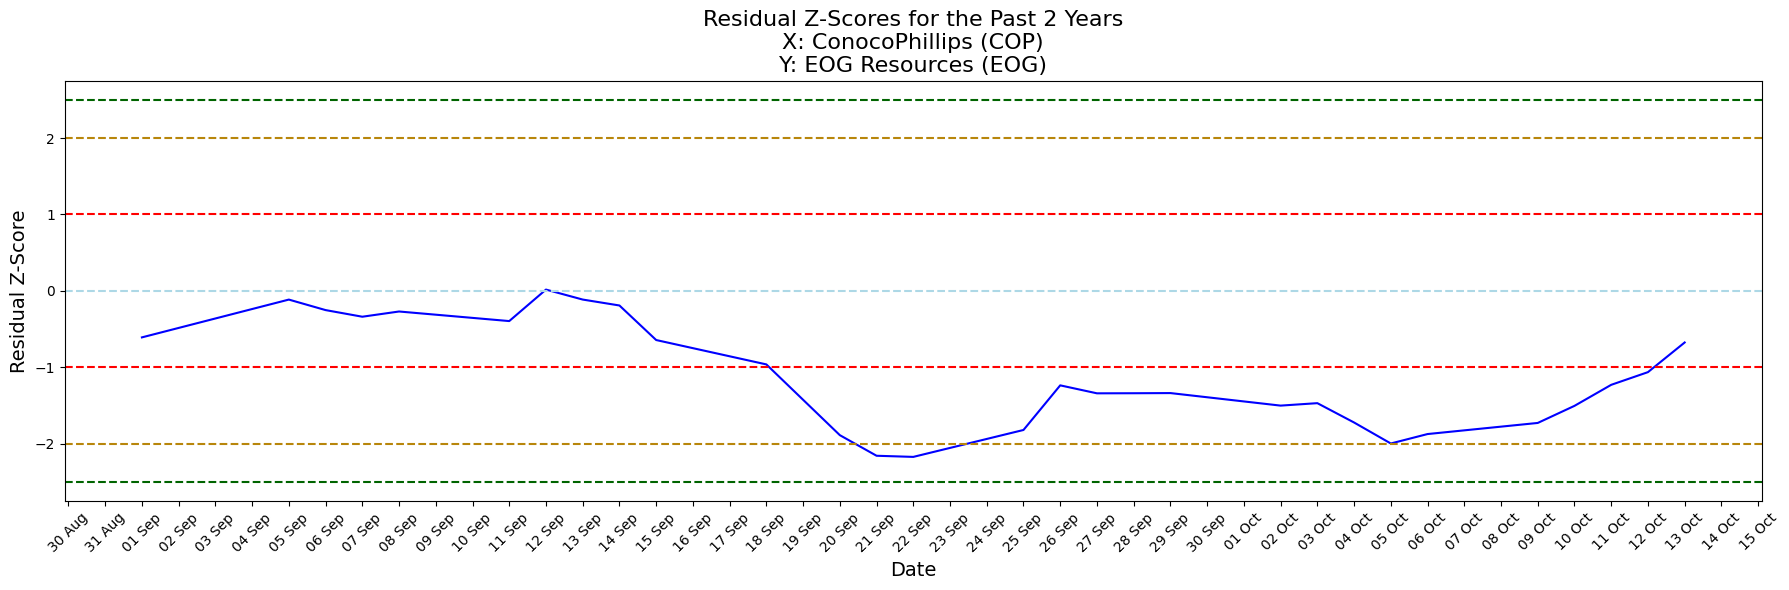

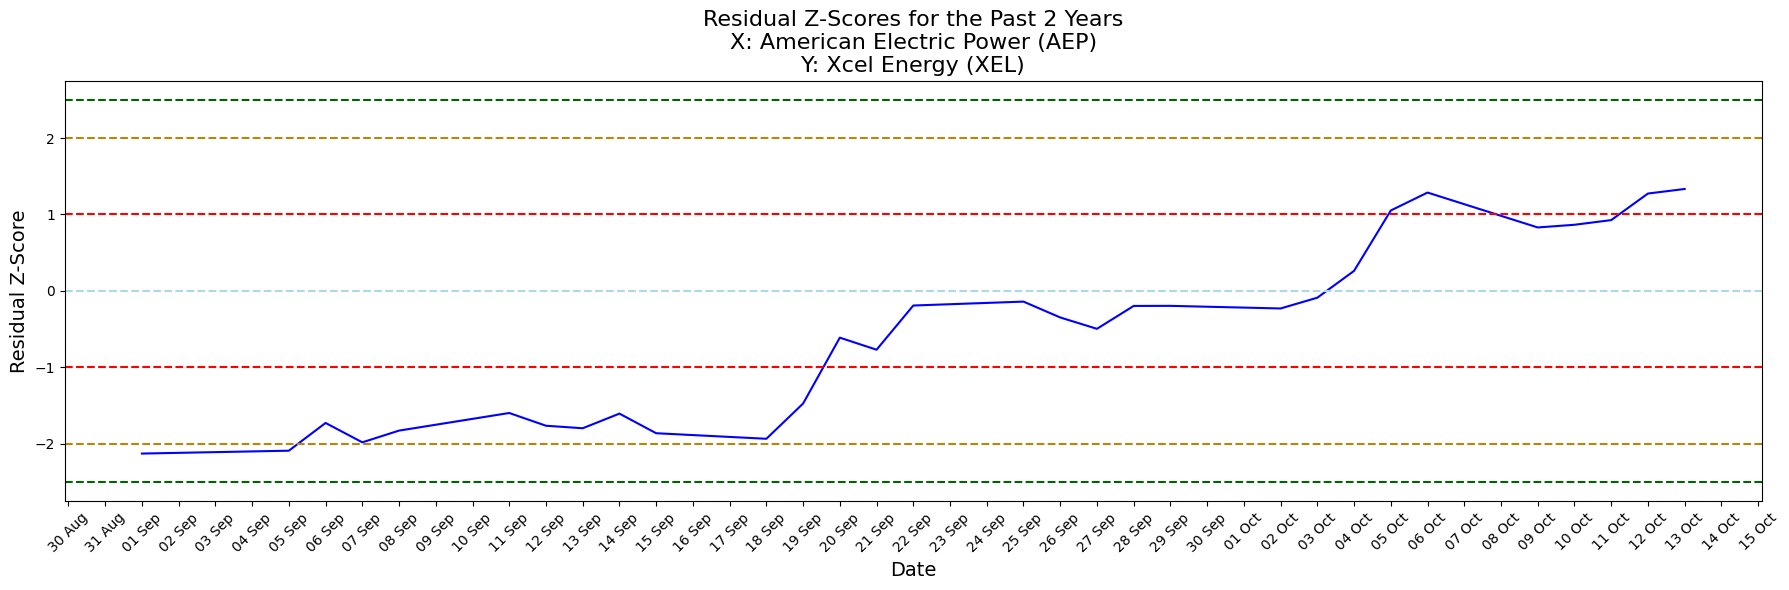

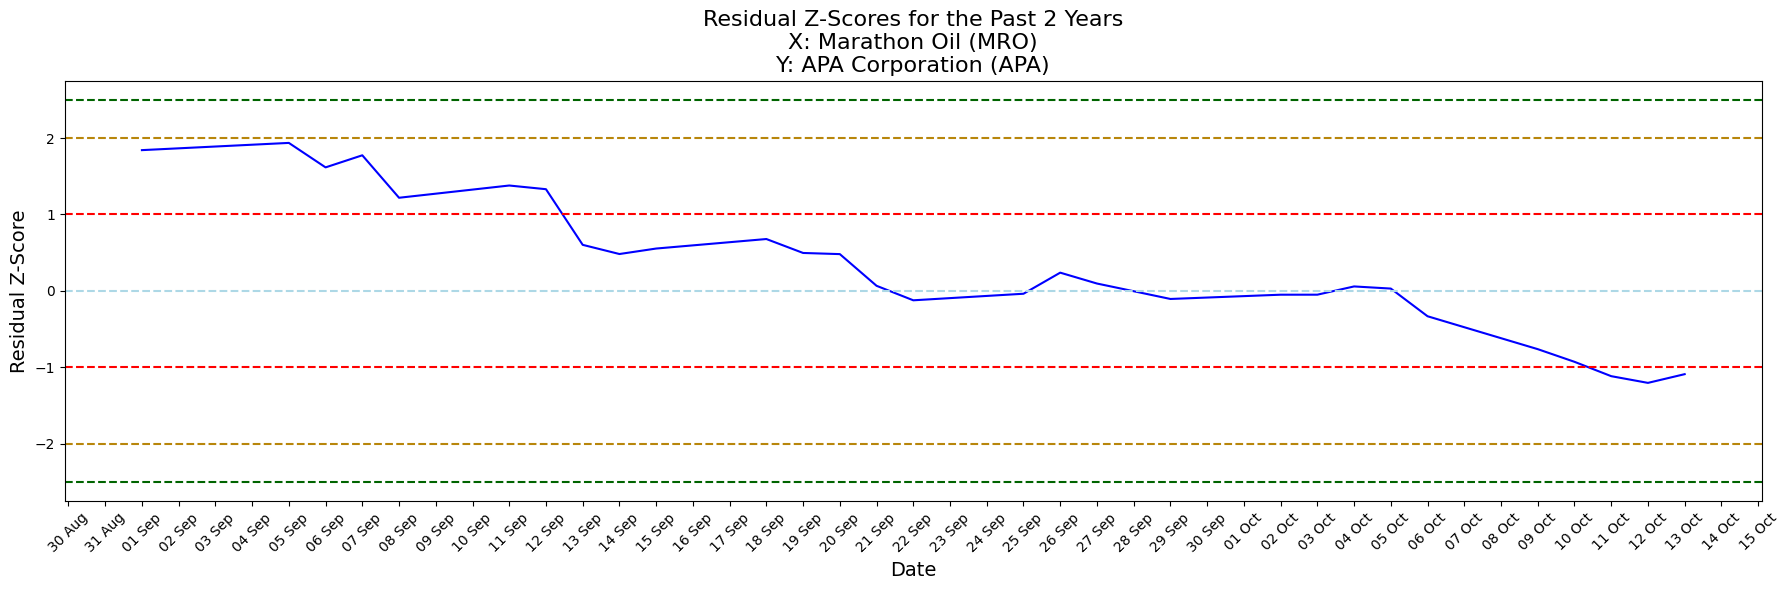

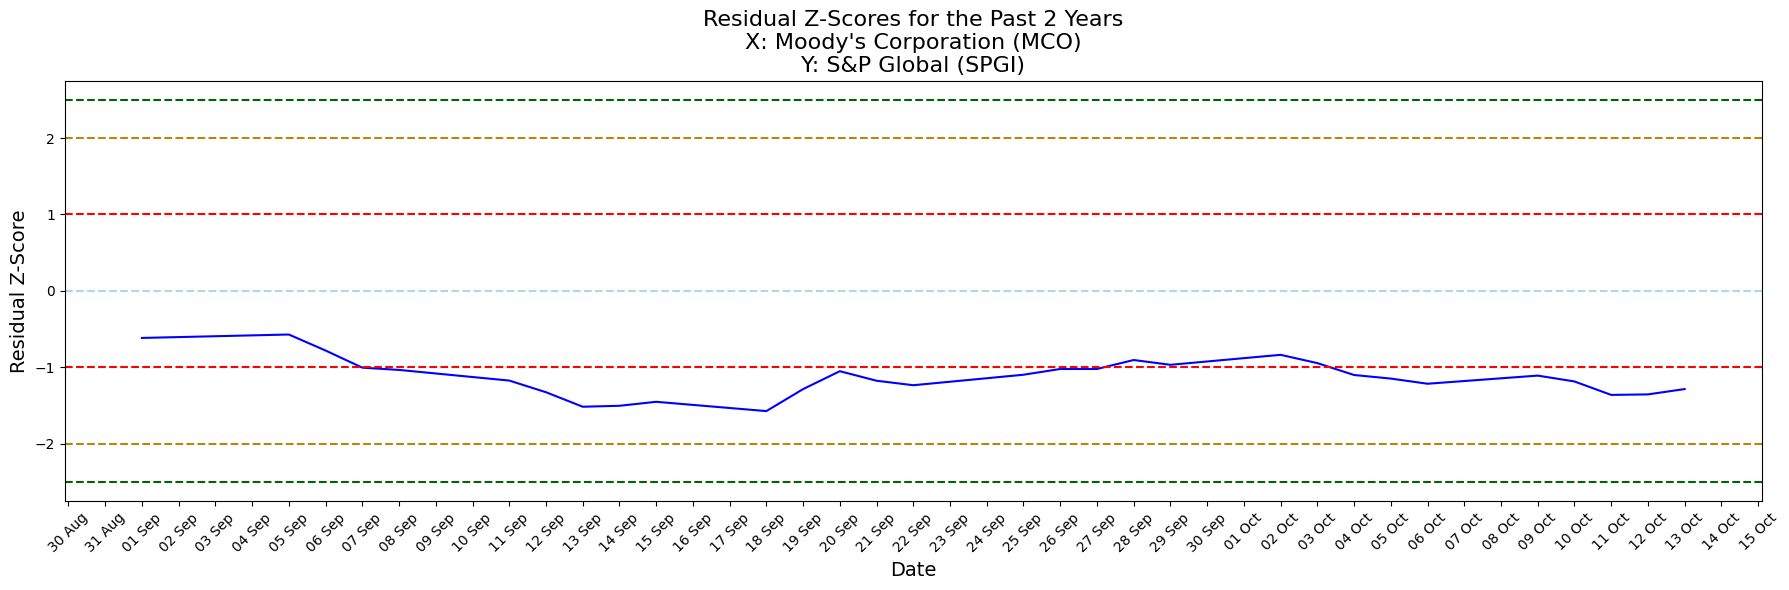

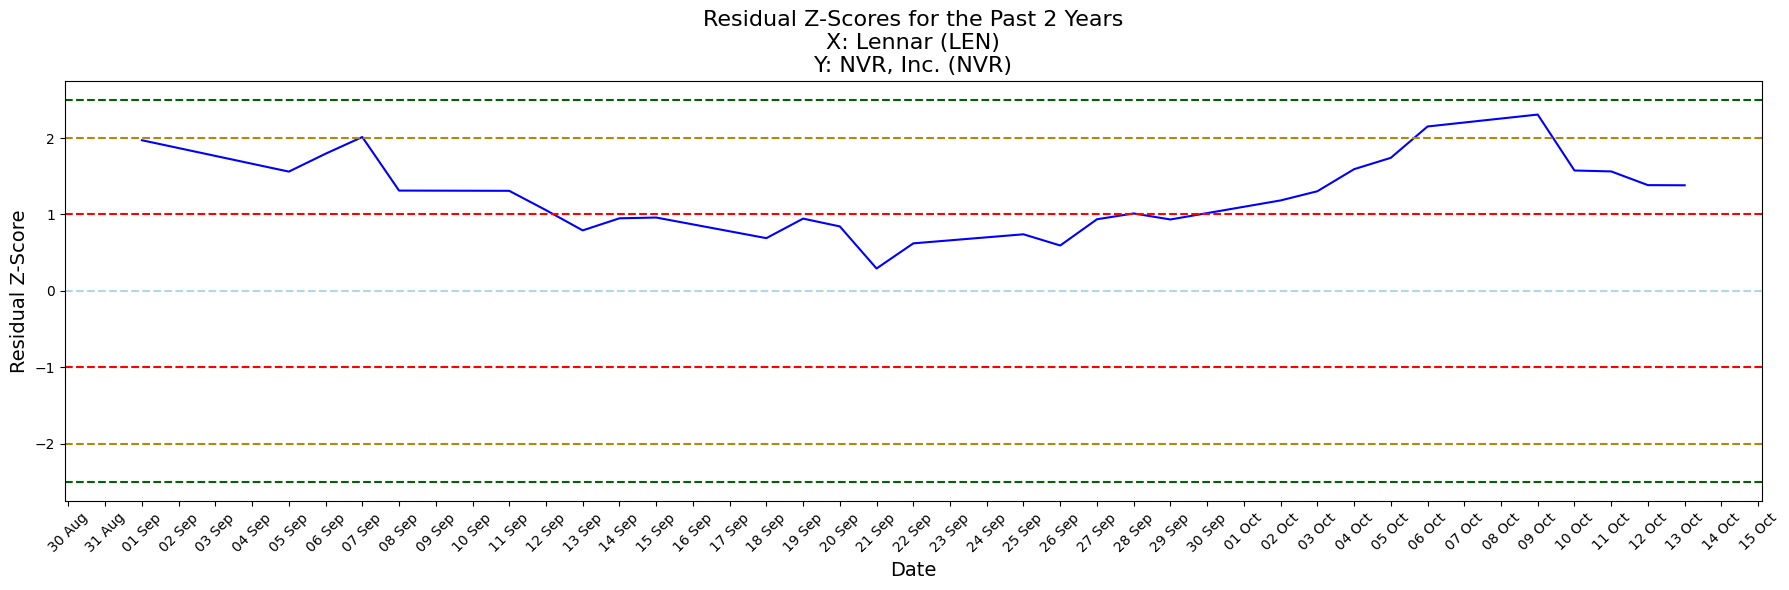

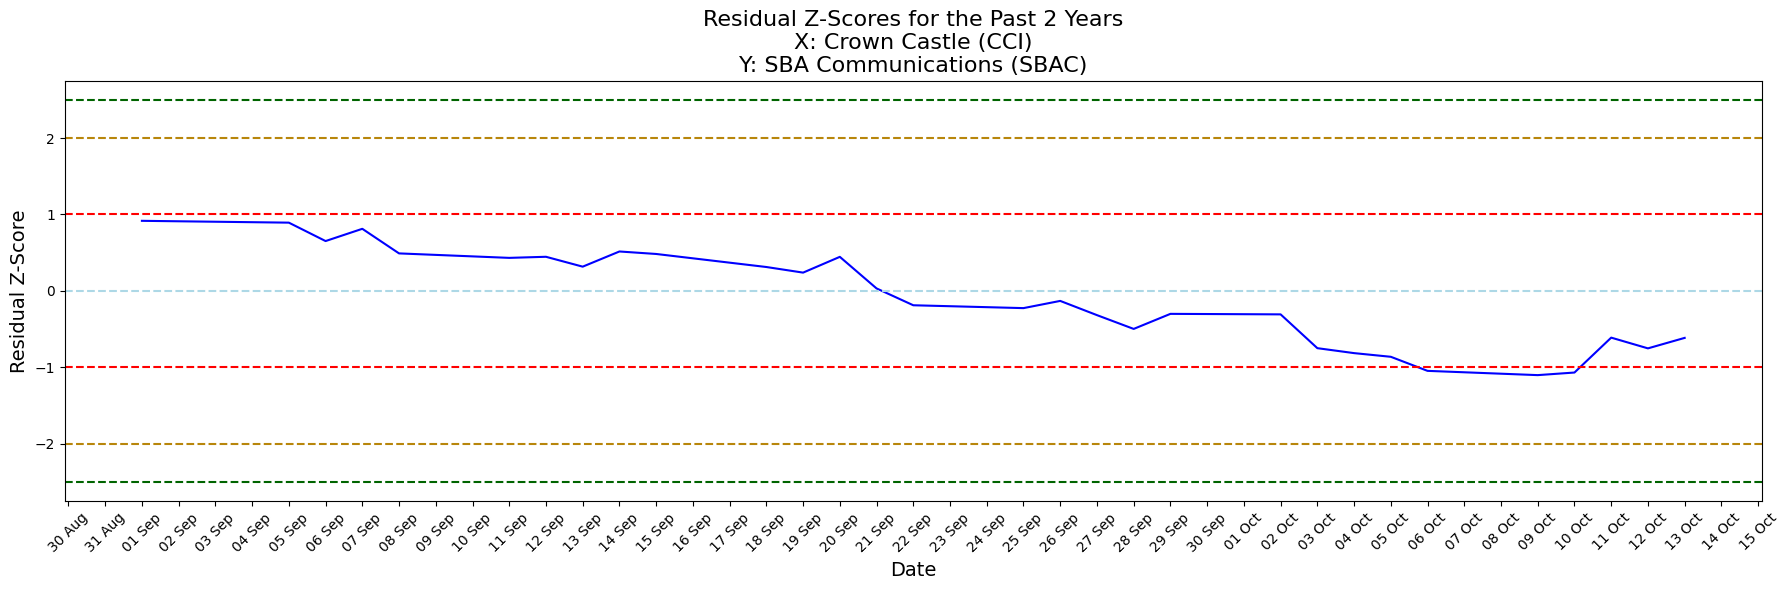

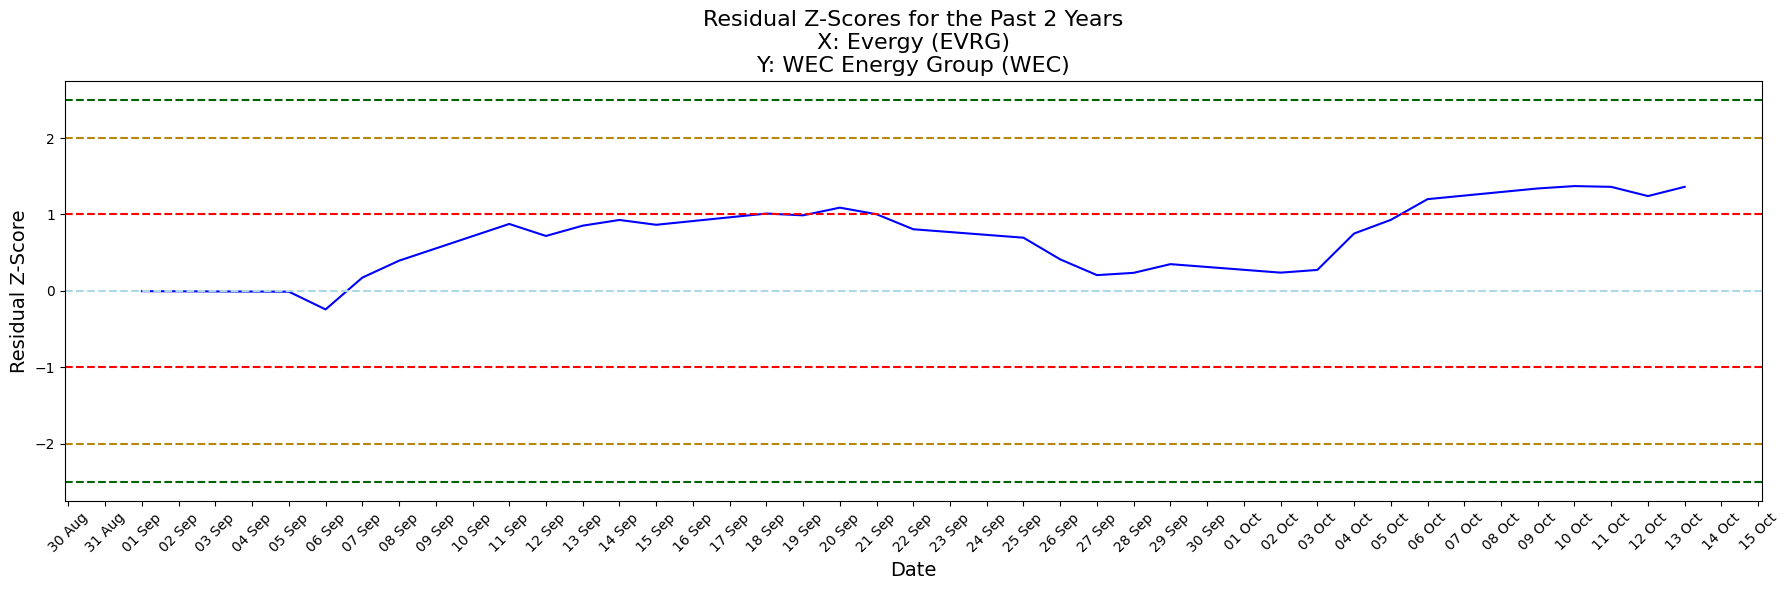

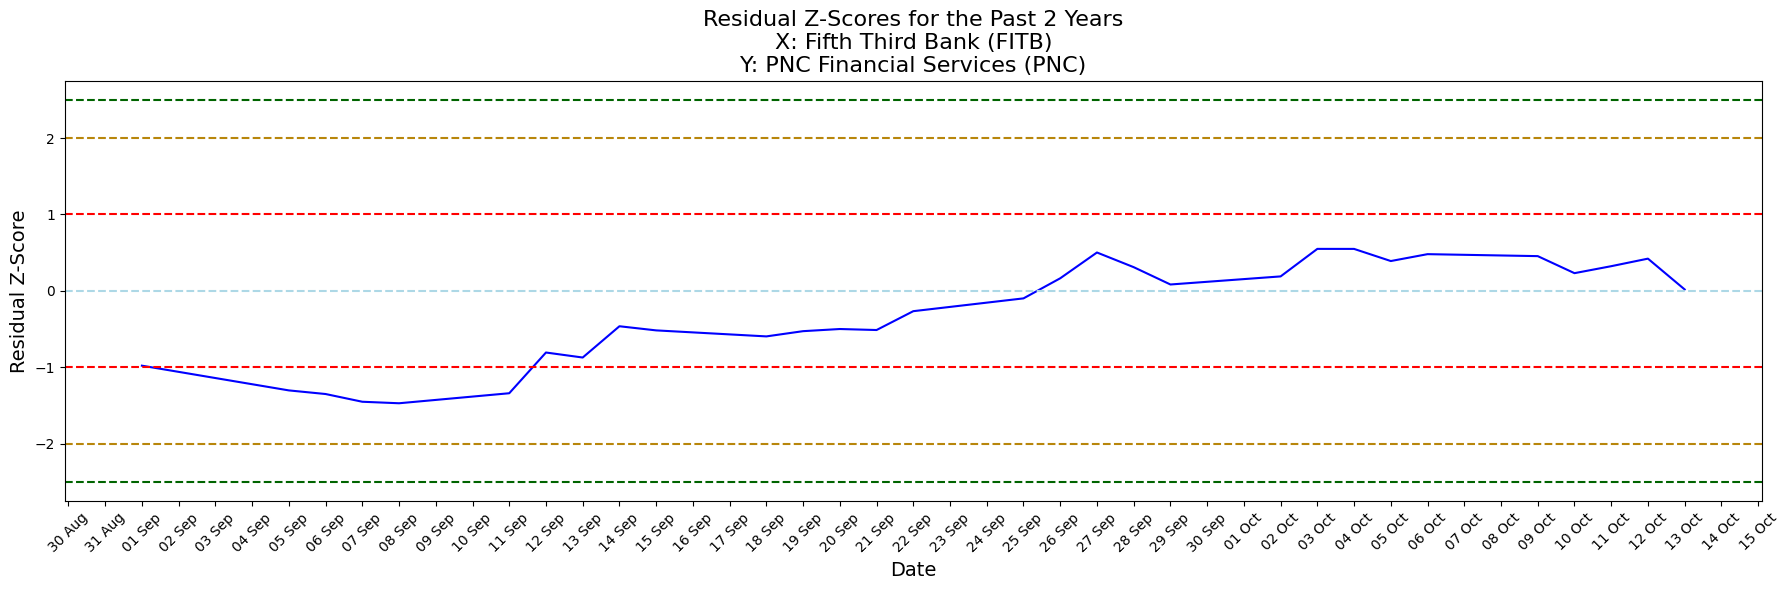

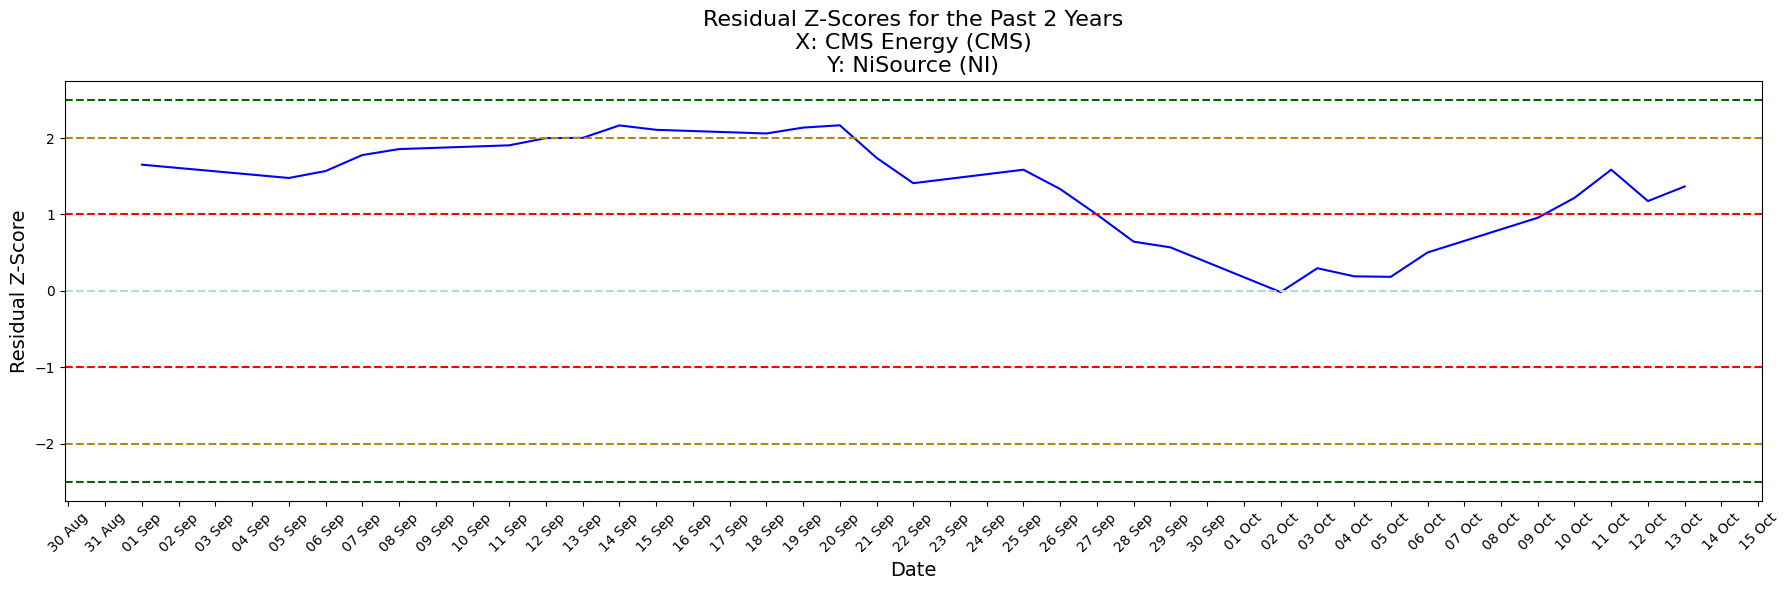

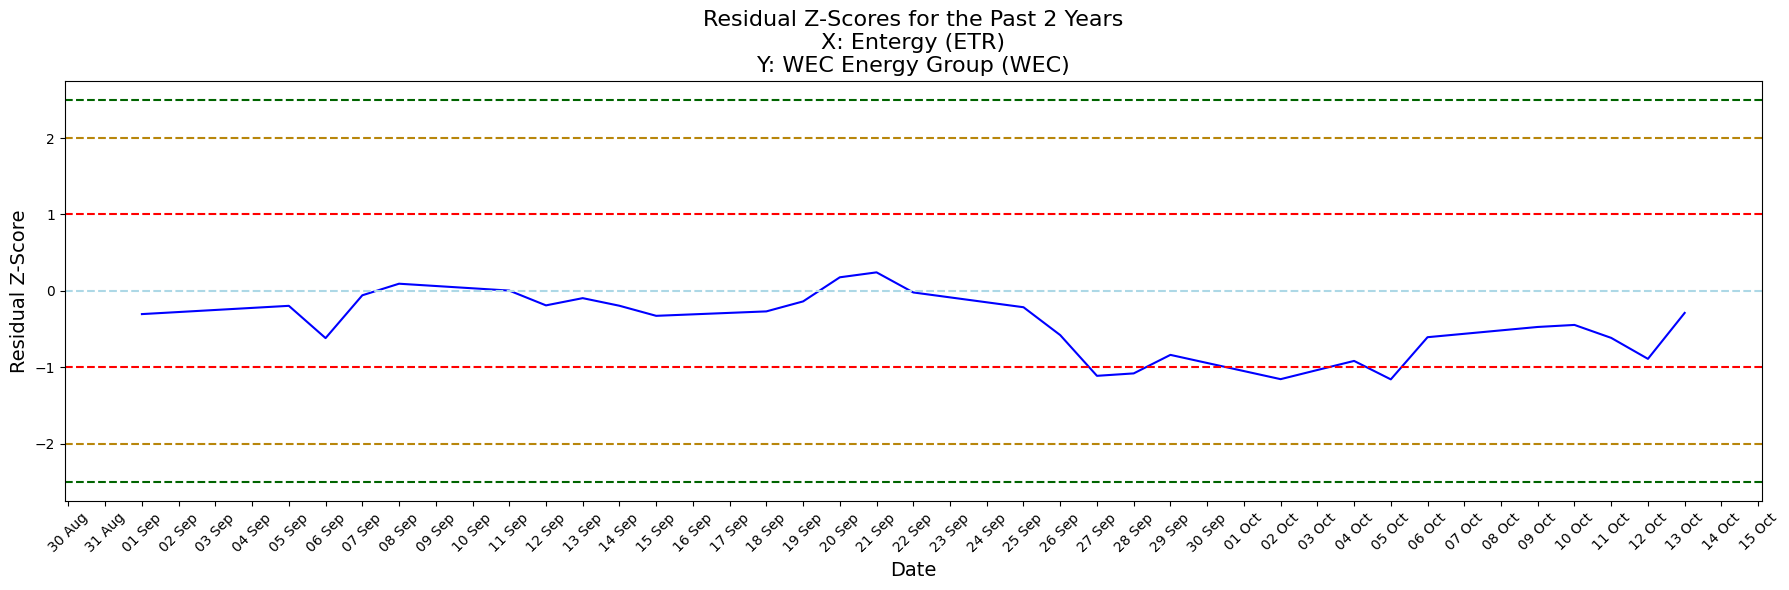

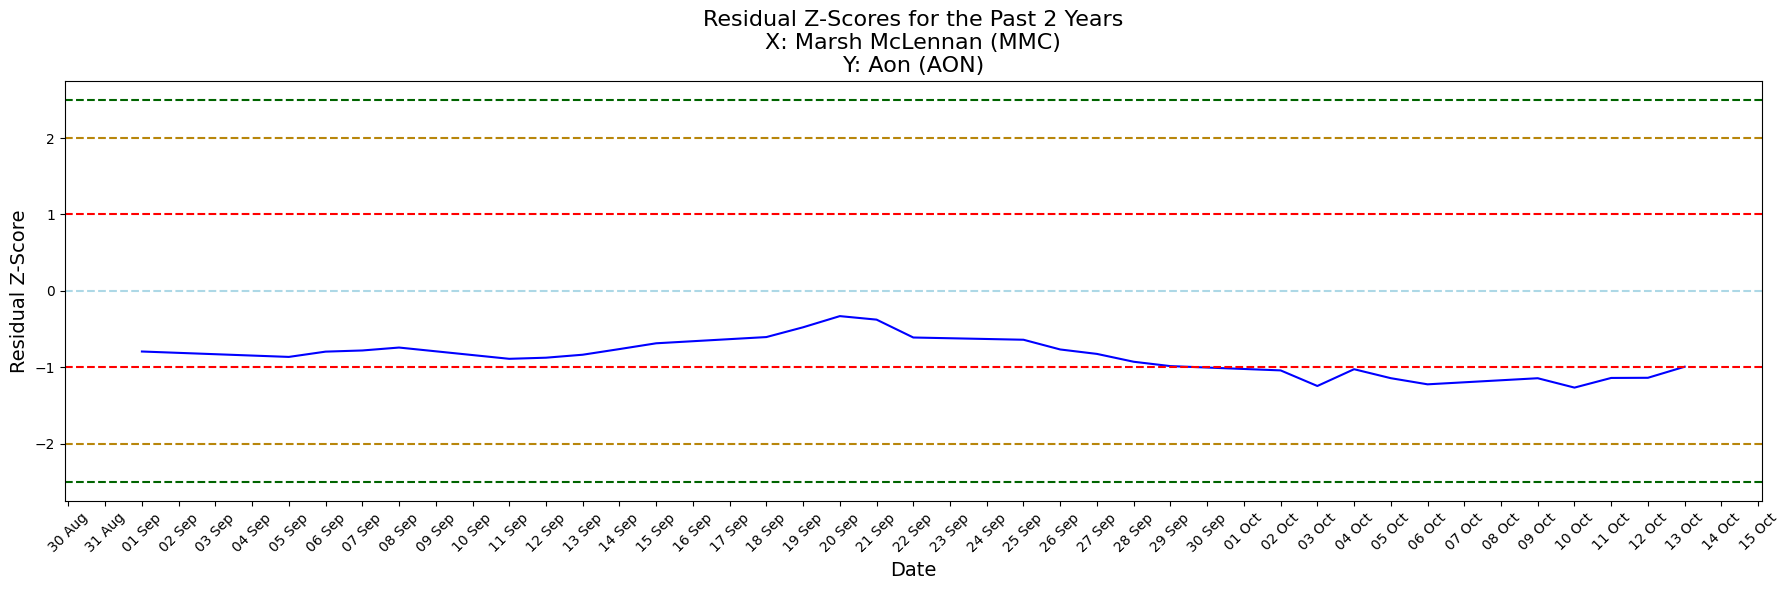

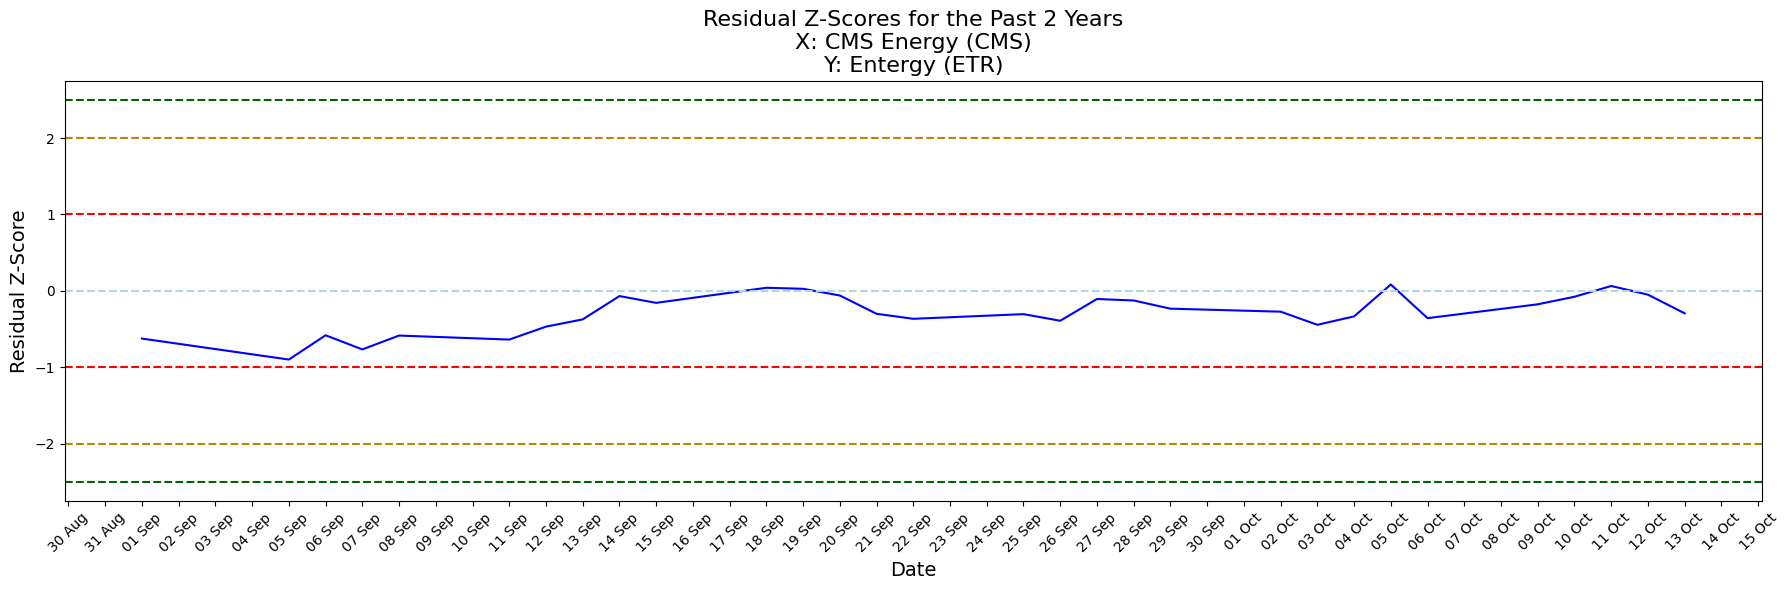

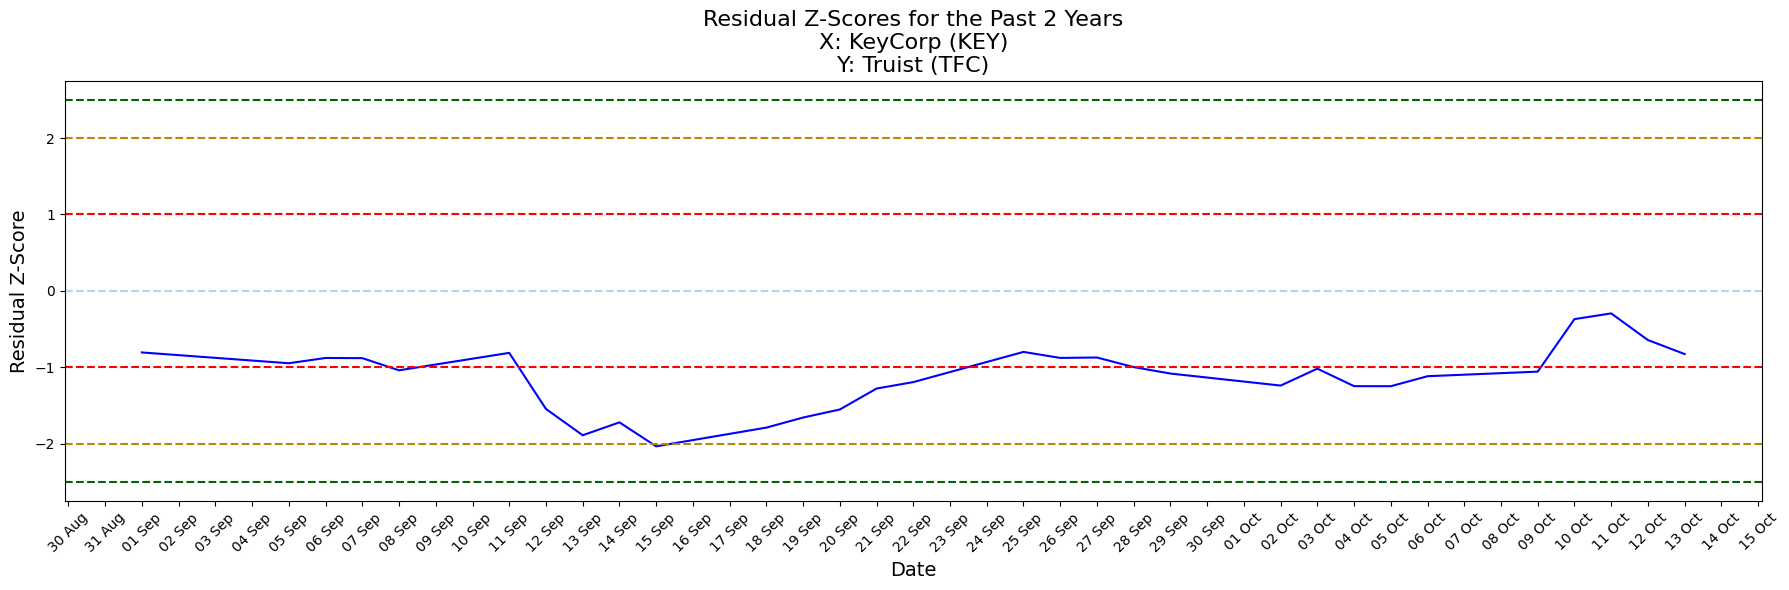

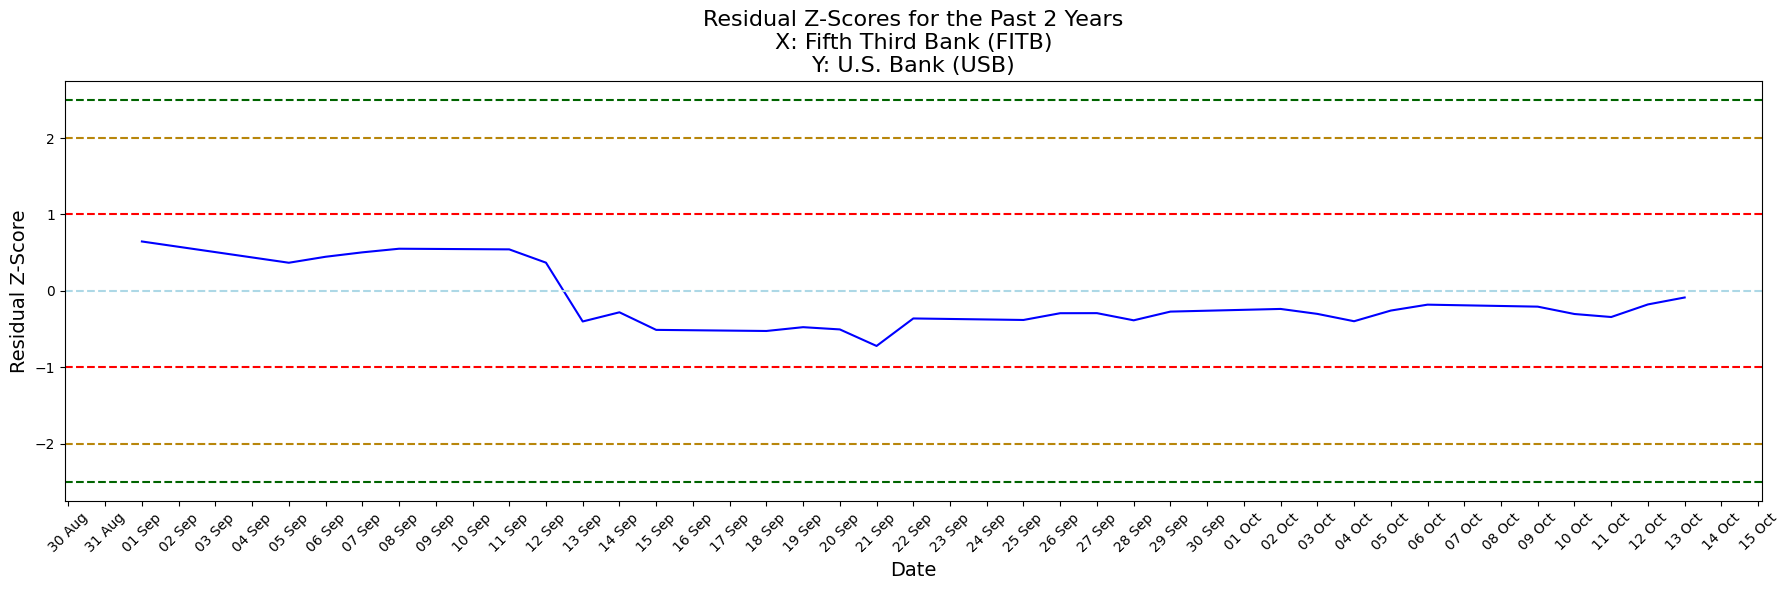

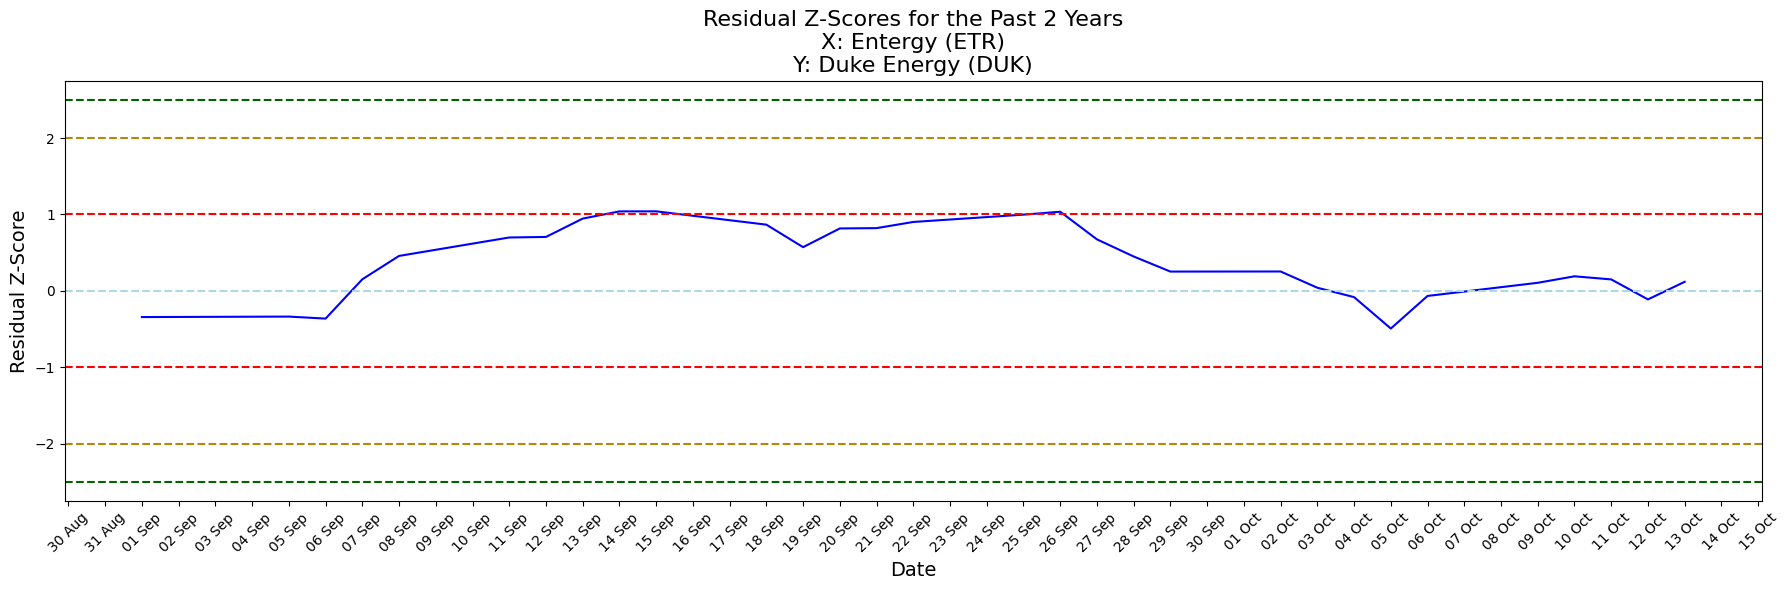

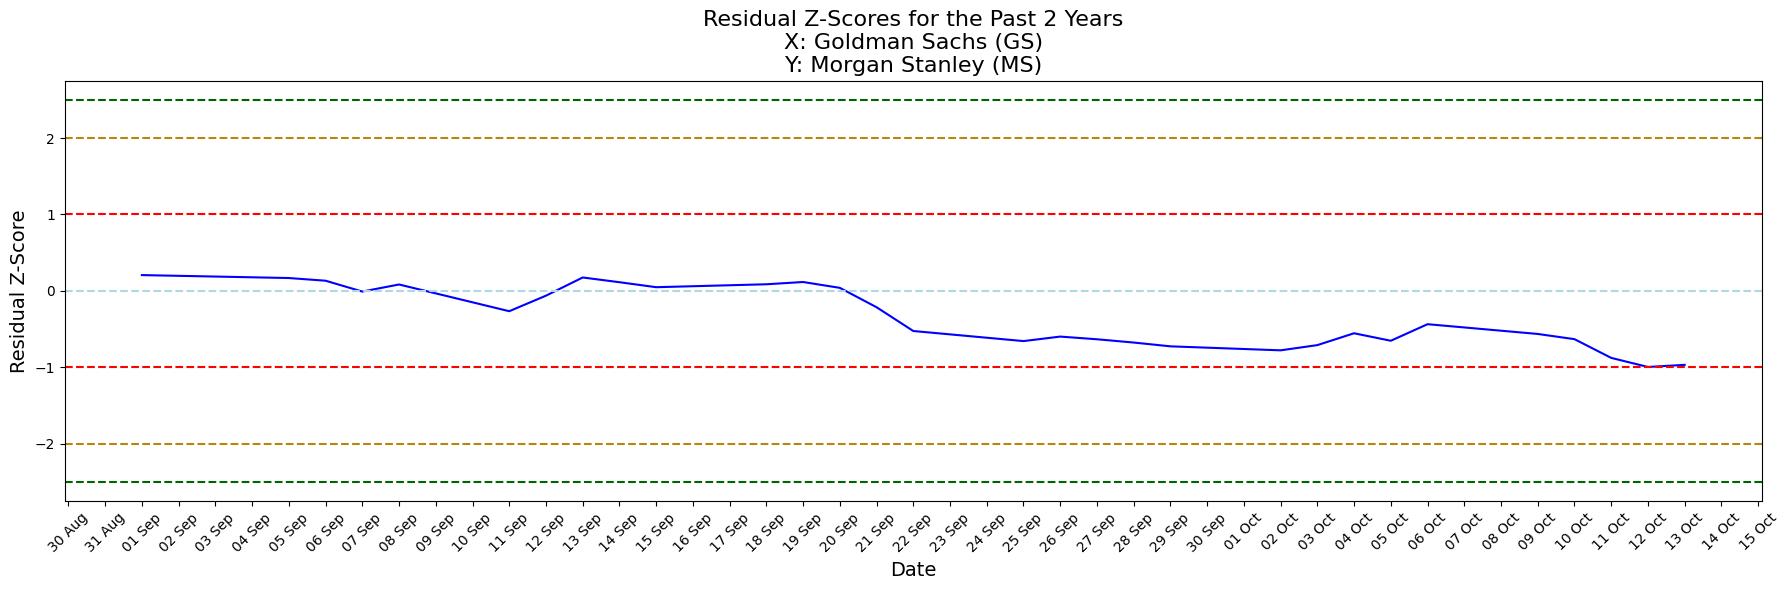

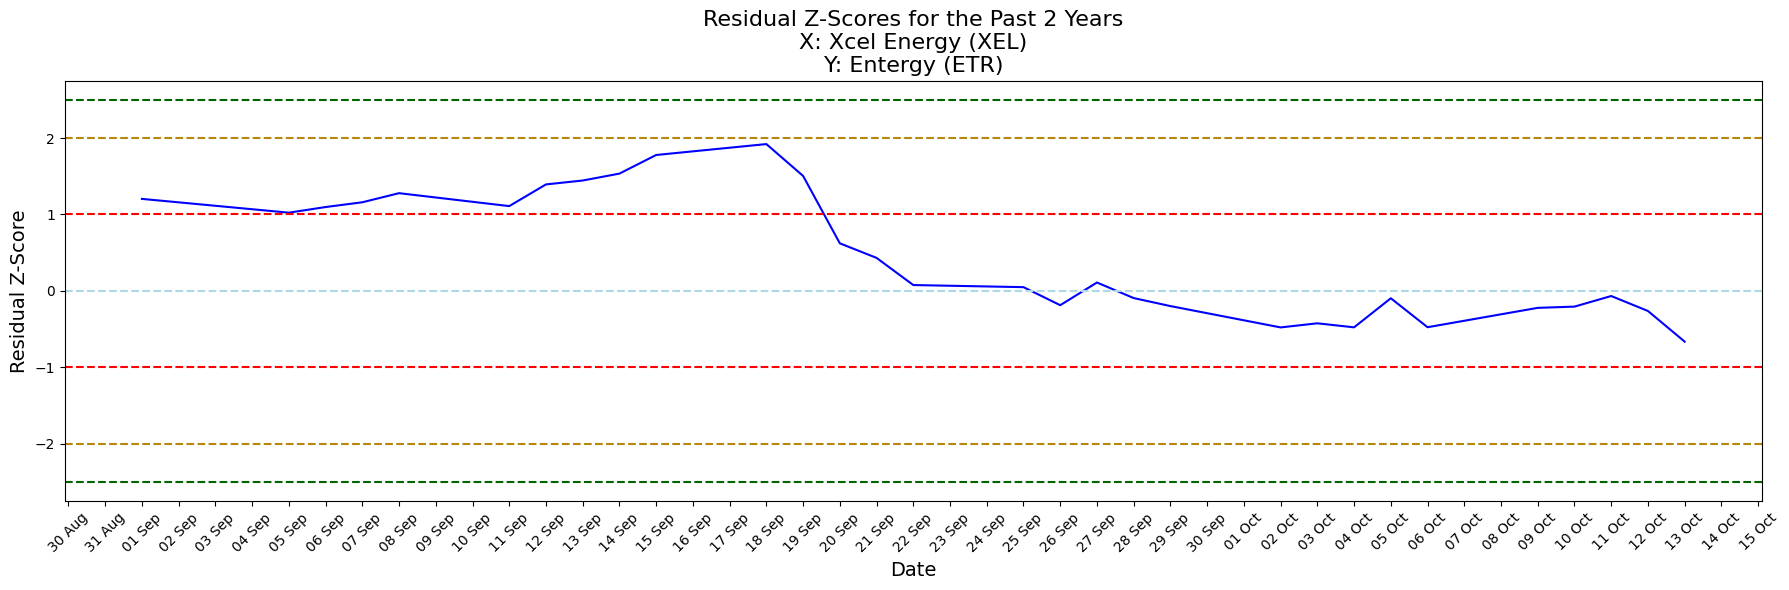

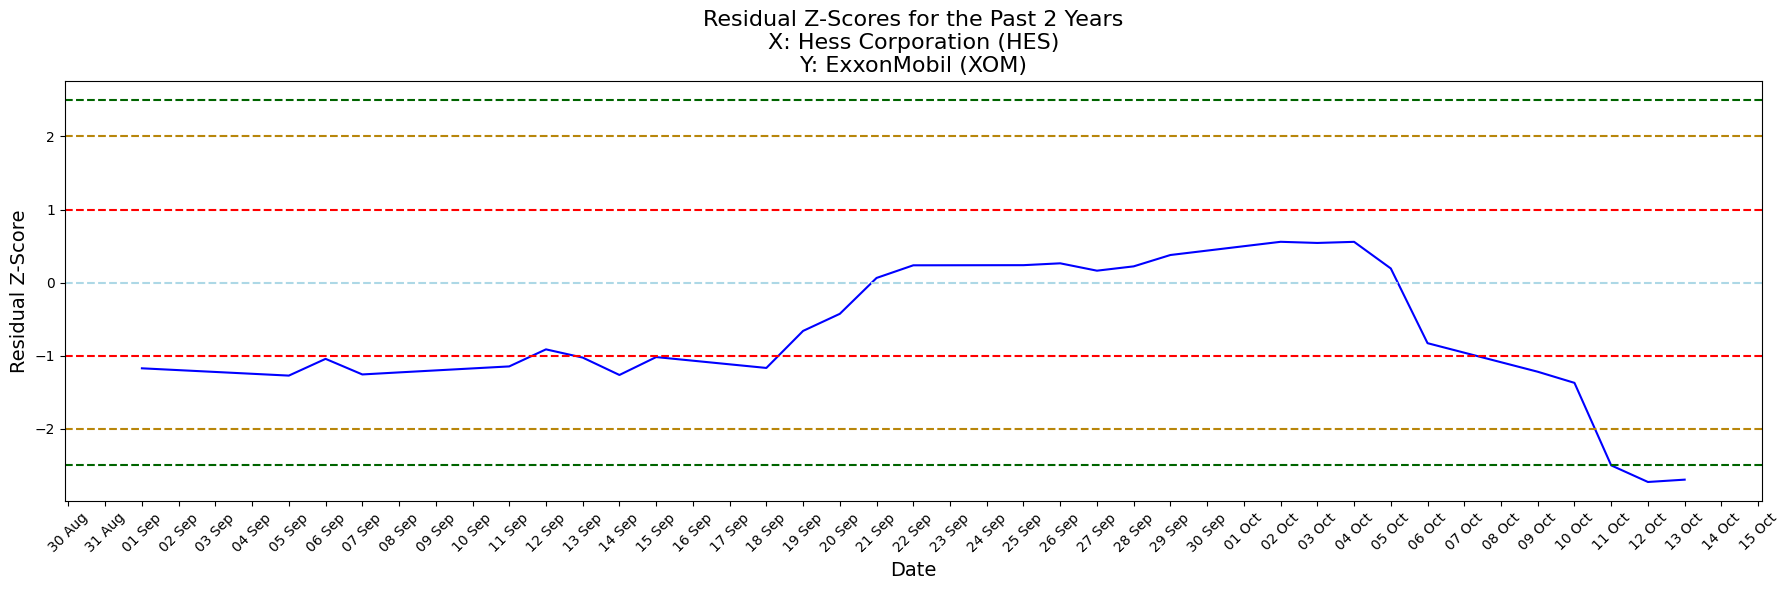

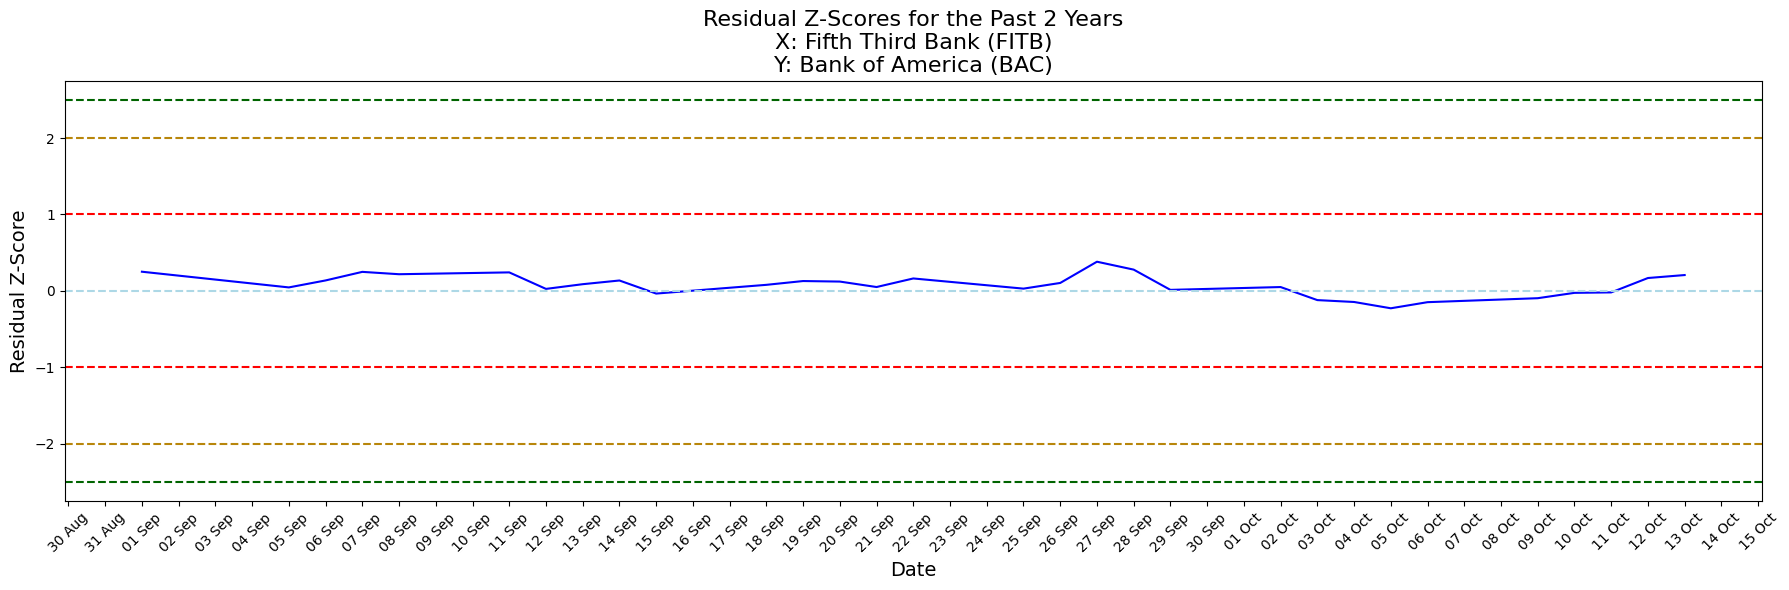

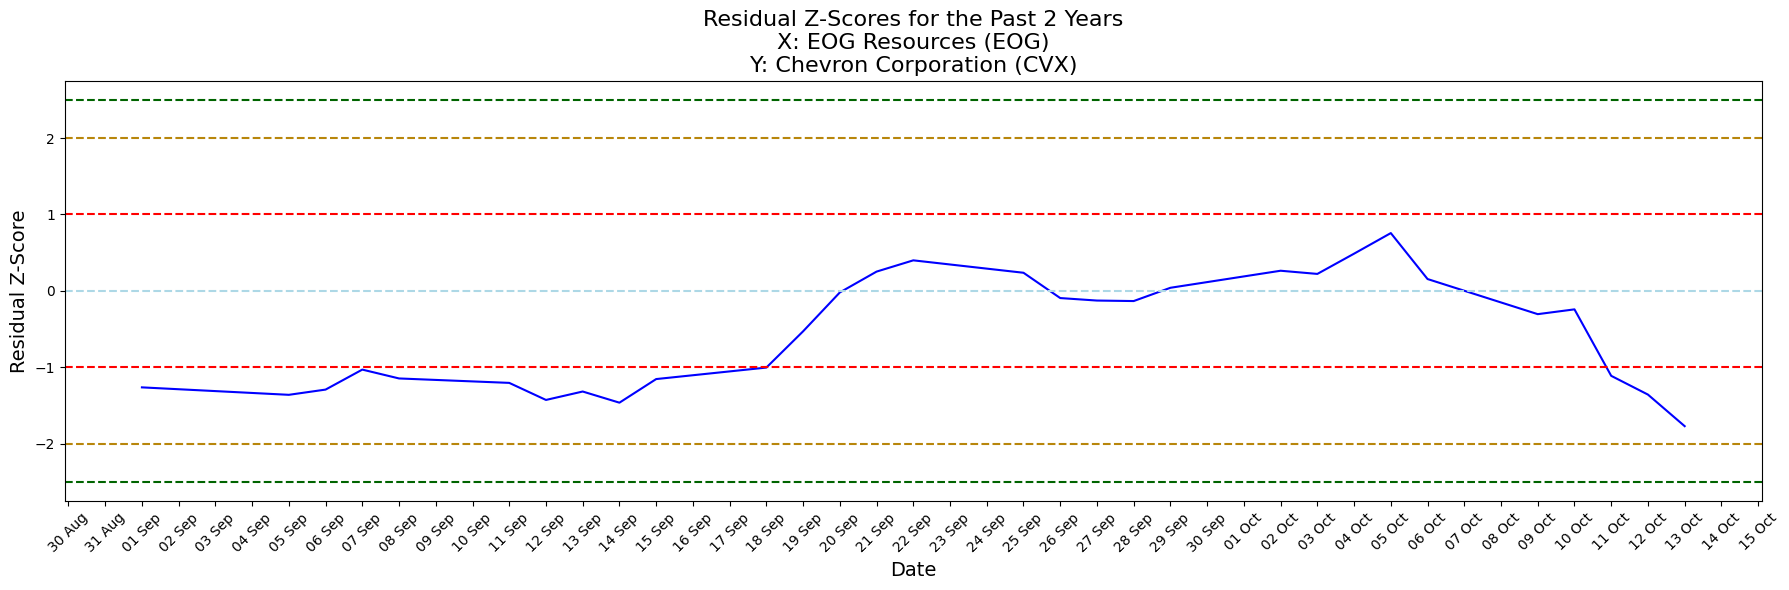

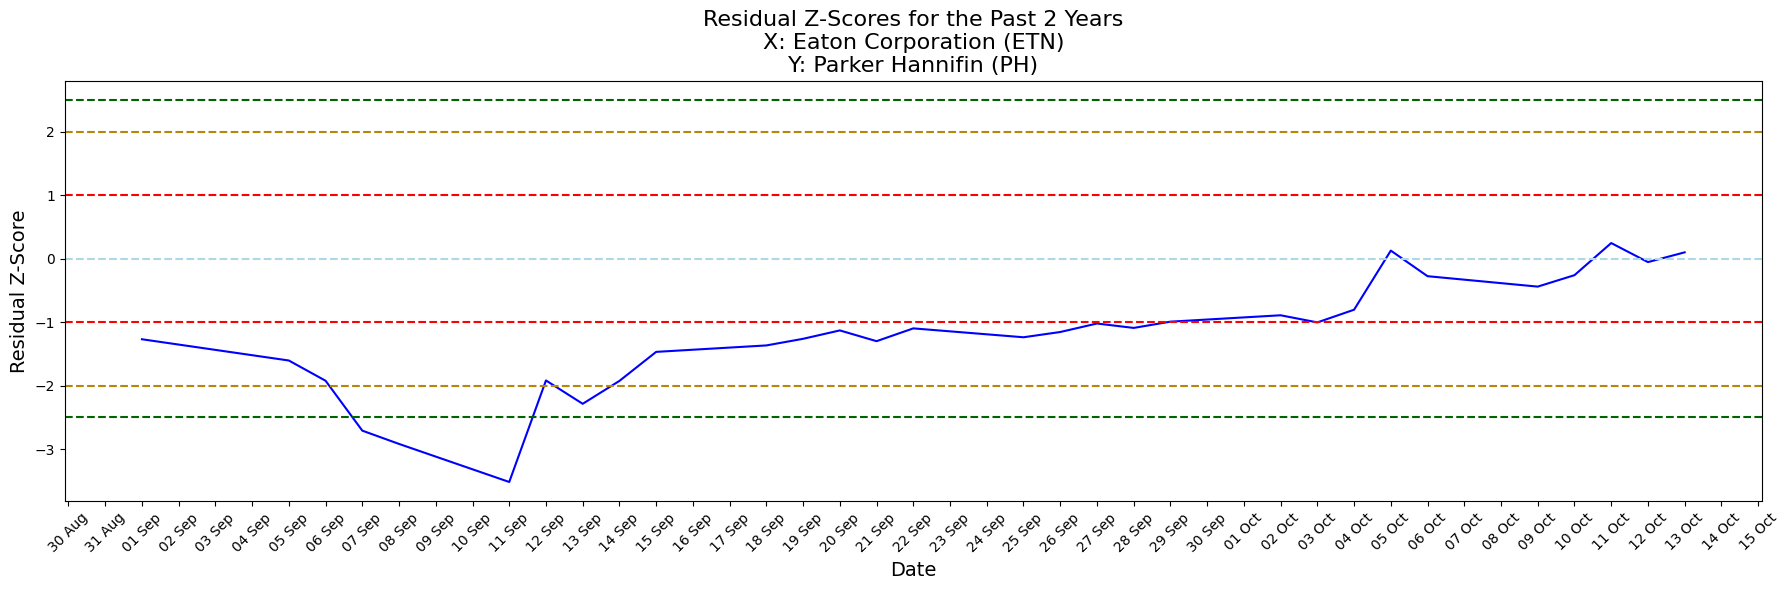

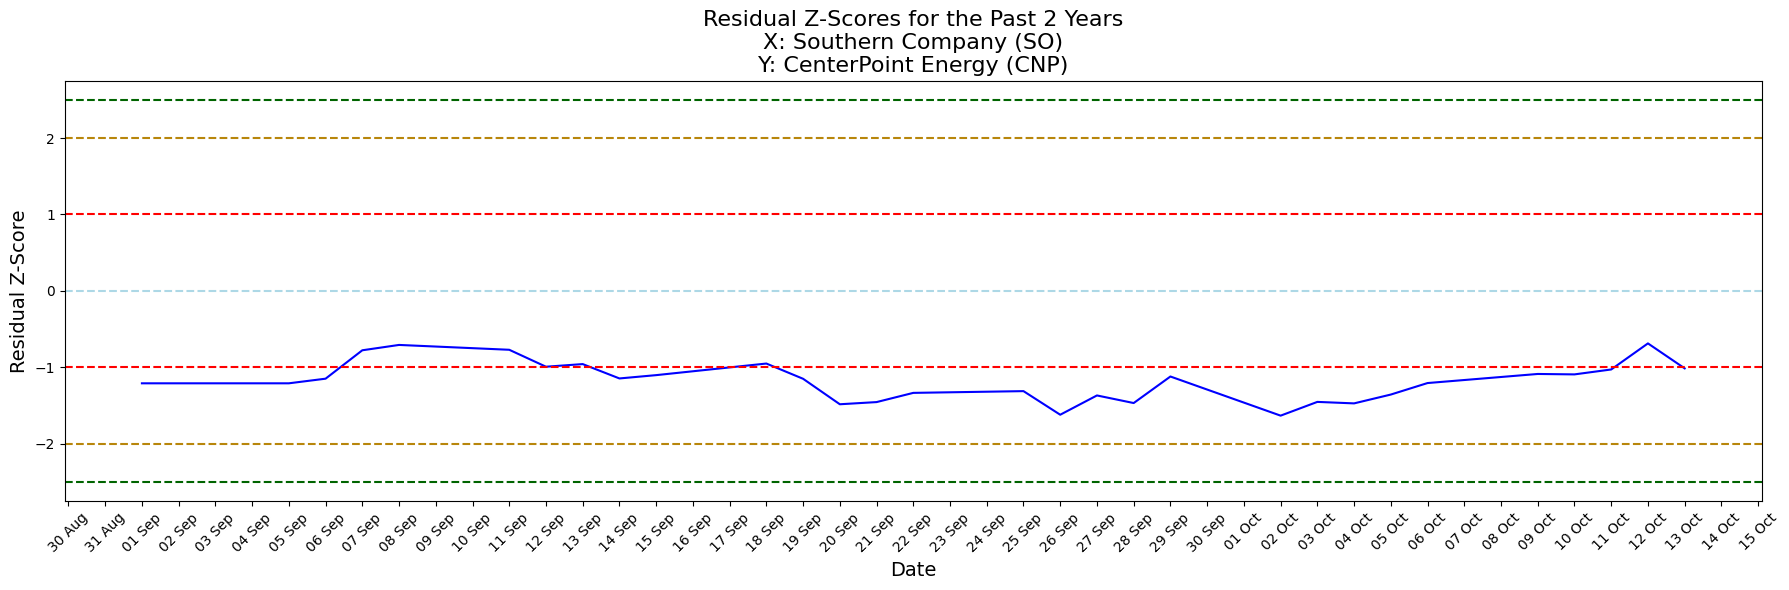

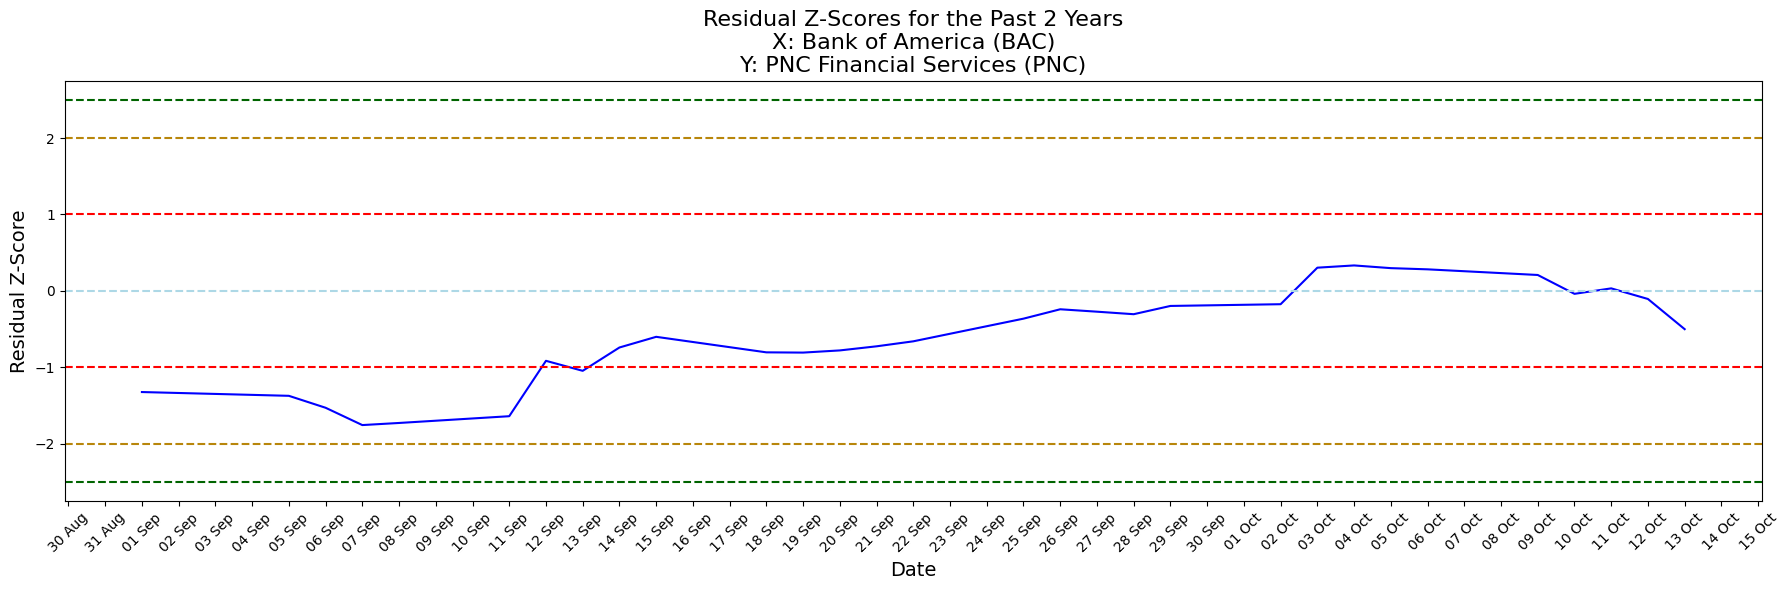

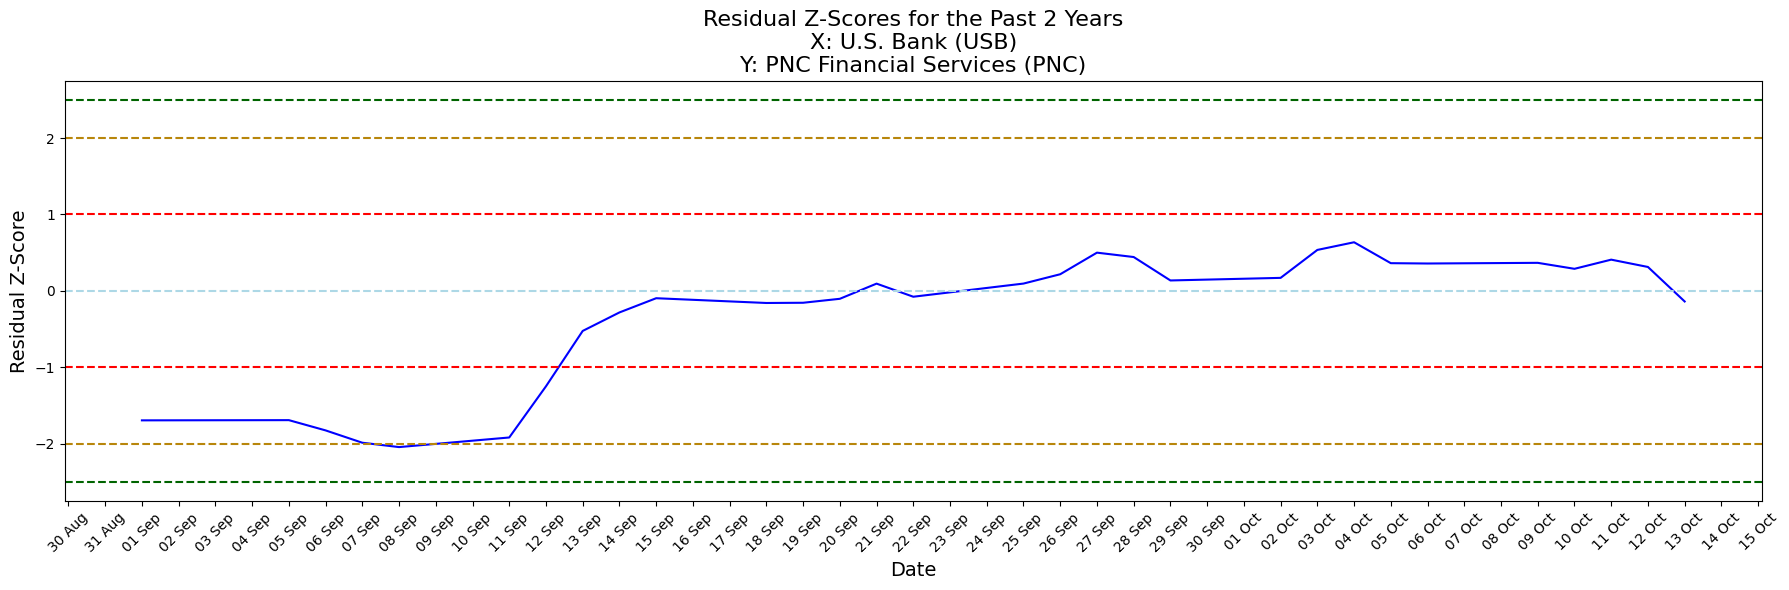

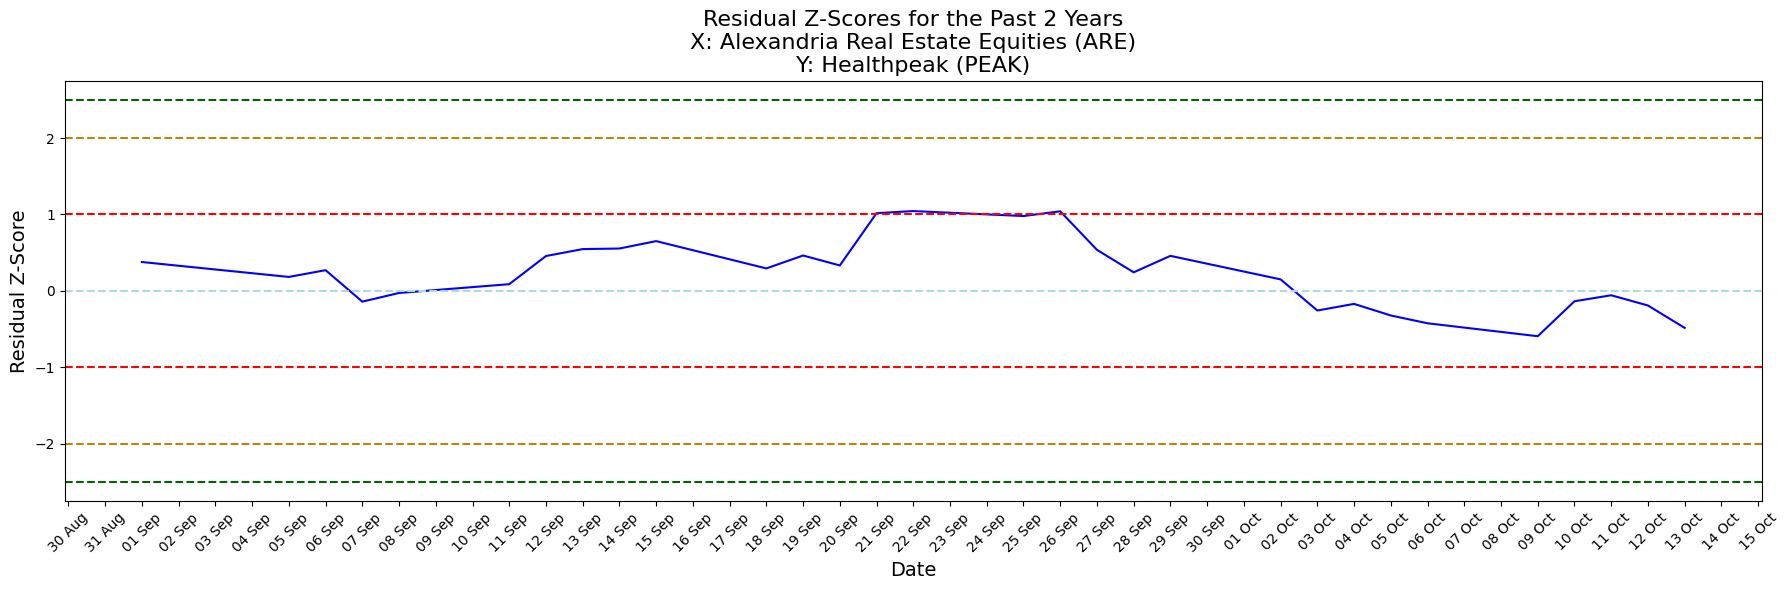

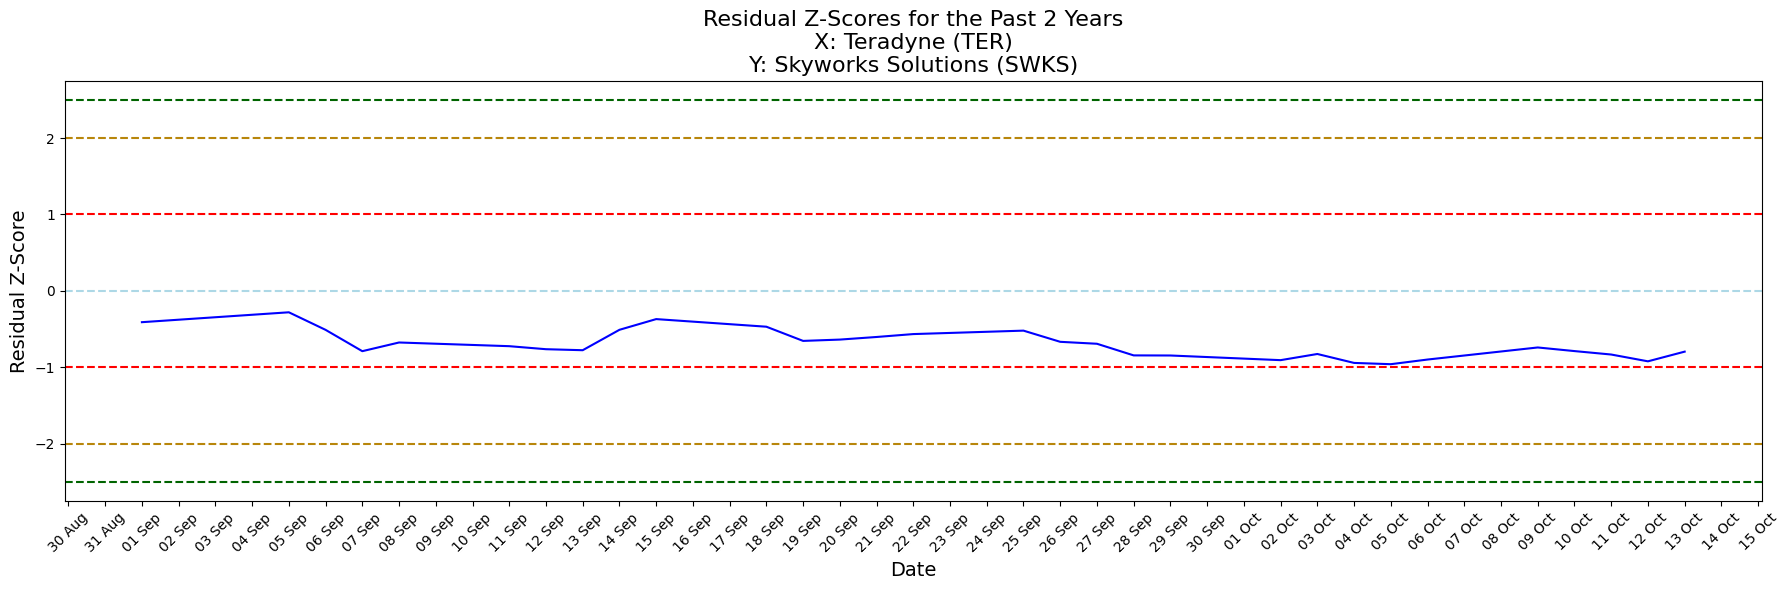

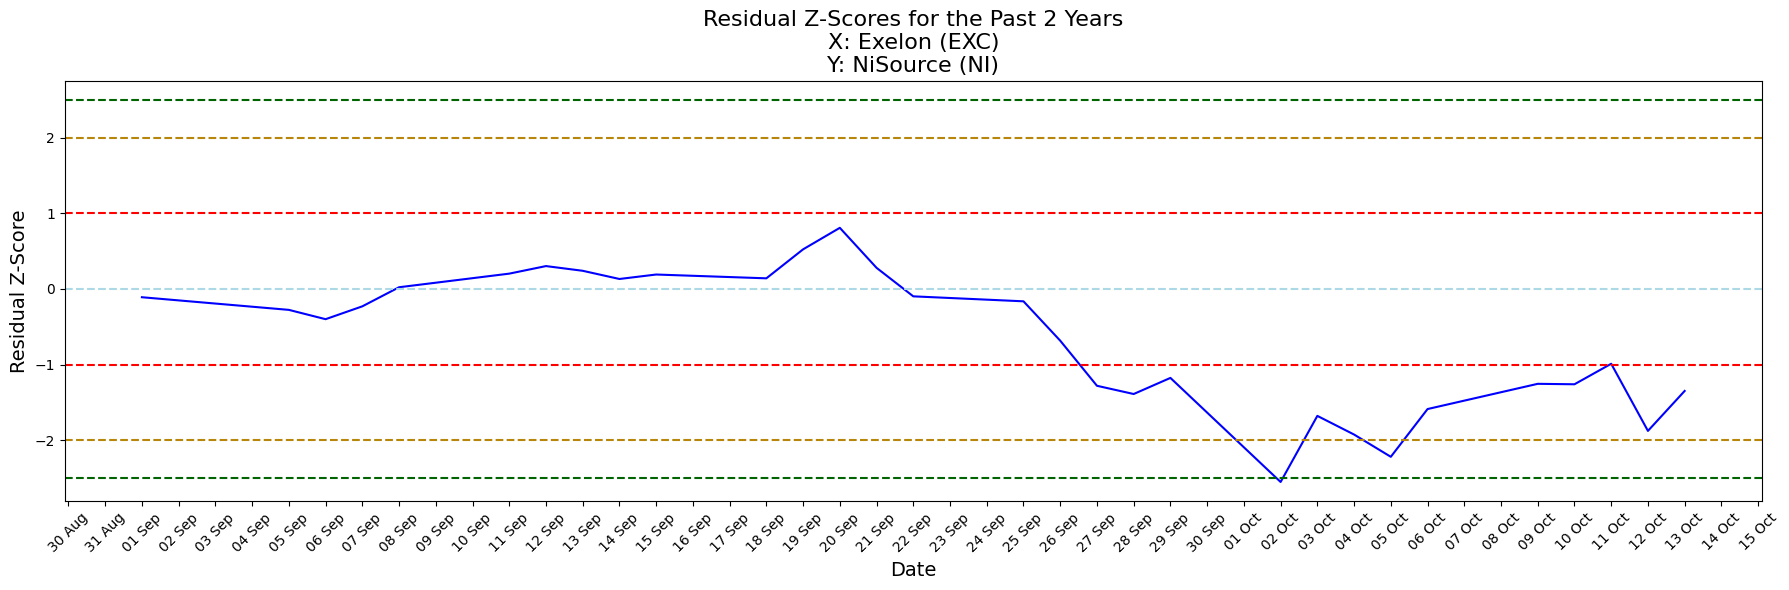

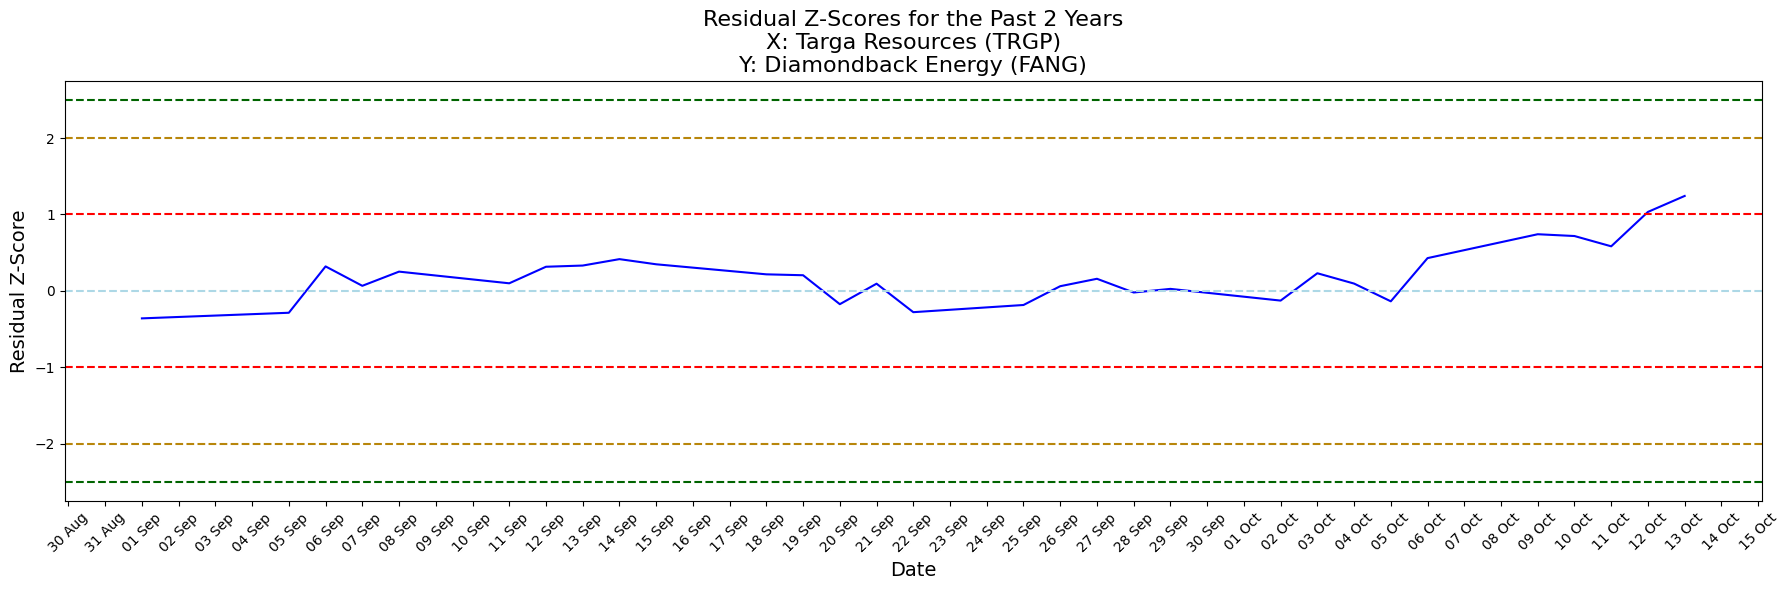

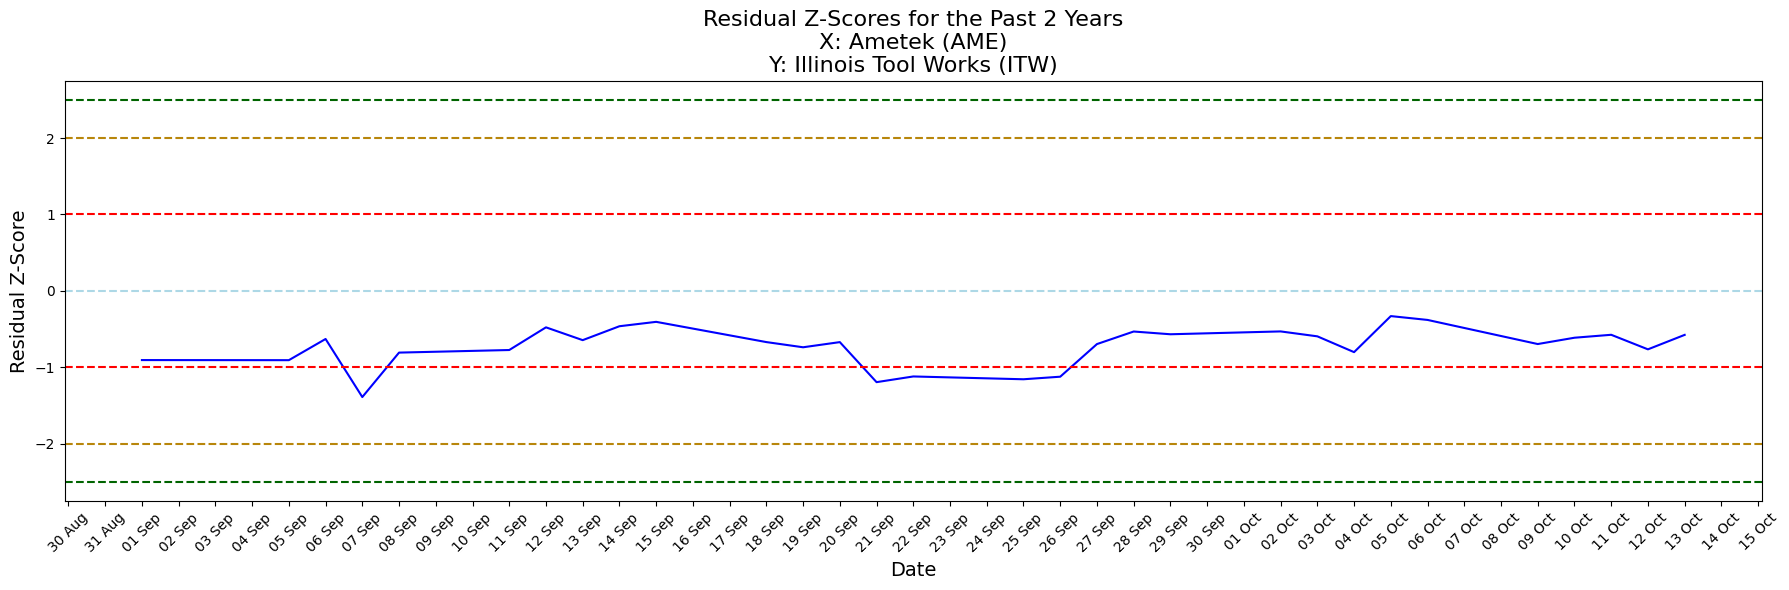

In [43]:
for i in range(len(regressionResults)):
    plotRecentResiduals(regressionResults.iloc[i]["residualSeries"], 
                  regressionResults.iloc[i]["stdevResidualSeries"], 
                  regressionResults.iloc[i]["companyX"], 
                  regressionResults.iloc[i]["companyY"], 
                  regressionResults.iloc[i]["independent"], 
                  regressionResults.iloc[i]["dependent"])

### 34 Shortlisted Pairs Along With Regression Stats as of 13 October 2023

In [44]:
regressionResults = regressionResults.reset_index().drop(["index"], axis =1)
regressionResults = regressionResults.drop(["residualSeries"], axis = 1)
regressionResults.to_csv(savepath + "ShortlistedPairs.csv")
display(regressionResults)


independent dependent   intercept       beta  stdevResidualSeries  \
0        GOOGL      GOOG    0.614830   0.999372             0.342901   
1          DHI       LEN   10.053124   0.936235             2.357814   
2          WEC       AEE   13.161787   0.776702             1.443566   
3          XEL       WEC   14.596719   1.173544             1.755141   
4           MA         V   27.306357   0.530077             4.515935   
5          CMS       DUK   12.891947   1.373179             1.933088   
6          COP       EOG   20.060176   0.930614             3.581558   
7          AEP       XEL    9.807155   0.633918             1.383359   
8          MRO       APA    2.796980   1.438893             1.777776   
9          MCO      SPGI   27.129083   1.099343             9.617325   
10         LEN       NVR  971.238645  43.149574           176.999935   
11         CCI      SBAC   46.543763   1.699037             9.111829   
12        EVRG       WEC   17.103676   1.231652             2.860383   
13        FITB       PNC   20.333565   4.025525             5.592518   
14         CMS        NI    4.507767   0.369532             0.958948   
15         ETR       WEC    9.450417   0.787483             2.081907   
16         MMC       AON   57.883013   1.463087            11.234153   
17         CMS       ETR   20.109641   1.377554             3.323028   
18         KEY       TFC    6.614486   2.228806             1.837257   
19        FITB       USB    3.376036   1.193606             2.032259   
20         ETR       DUK   15.569000   0.777757             2.957782   
21          GS        MS   15.491665   0.212379             3.504175   
22         XEL       ETR   16.193515   1.342153             2.475066   
23         HES       XOM    8.162618   0.704417             4.339775   
24        FITB       BAC    4.698079   0.894550             1.692227   
25         EOG       CVX   18.036042   1.185633             7.154819   
26         ETN        PH   24.642678   1.760505            10.668667   
27          SO       CNP    5.212608   0.347868             0.782668   
28         BAC       PNC    7.359440   4.262141             6.541891   
29         USB       PNC   15.262022   3.225433             6.402602   
30         ARE      PEAK    2.642232   0.153213             0.830837   
31         TER      SWKS   14.394031   0.911410             8.714926   
32         EXC        NI    4.311297   0.558044             0.611447   
33        TRGP      FANG   23.824362   1.526491             7.730846   
34         AME       ITW   25.285362   1.413410             6.735720   

    adfTestPValue                industry  explainedY  \
0        0.000027  Communication Services   99.481436   
1        0.004490  Consumer Discretionary   89.447411   
2        0.005117               Utilities   84.320863   
3        0.005227               Utilities   83.982974   
4        0.000210              Financials   87.322521   
5        0.018075               Utilities   86.604702   
6        0.003268                  Energy   82.080434   
7        0.007559               Utilities   84.962430   
8        0.006762                  Energy   92.468999   
9        0.022373              Financials   92.720476   
10       0.037829  Consumer Discretionary   80.888519   
11       0.004076             Real Estate   83.817780   
12       0.047185               Utilities   81.232082   
13       0.004793              Financials   86.768561   
14       0.049504               Utilities   83.266094   
15       0.002440               Utilities   89.630028   
16       0.042115              Financials   80.757436   
17       0.036496               Utilities   80.612654   
18       0.031339              Financials   84.626492   
19       0.017622              Financials   92.132901   
20       0.034562               Utilities   83.823126   
21       0.030014              Financials   81.971175   
22       0.000551               Utilities   84.388122   
23       0.011465                  Energy 

In [45]:
tickers = regressionResults["dependent"].unique().tolist()
tickers.extend(regressionResults["independent"].unique().tolist())
tickers = list(set(tickers))
companyMetaData = companyMetaData[companyMetaData.index.isin(tickers)]
companyMetaData.to_csv(savepath + "ShortlistedPairsMetaData.csv")
display(companyMetaData)


company    GICS Sector (GICS-1)  \
ticker                                                            
ARE     Alexandria Real Estate Equities             Real Estate   
GOOGL           Alphabet Inc. (Class A)  Communication Services   
GOOG            Alphabet Inc. (Class C)  Communication Services   
AEE                              Ameren               Utilities   
AEP             American Electric Power               Utilities   
AME                              Ametek             Industrials   
AON                                 Aon              Financials   
APA                     APA Corporation                  Energy   
BAC                     Bank of America              Financials   
CNP                  CenterPoint Energy               Utilities   
CVX                 Chevron Corporation                  Energy   
CMS                          CMS Energy               Utilities   
COP                      ConocoPhillips                  Energy   
CCI                        Crown Castle             Real Estate   
DHI                         D.R. Horton  Consumer Discretionary   
FANG                 Diamondback Energy                  Energy   
DUK                         Duke Energy               Utilities   
ETN                   Eaton Corporation             Industrials   
ETR                             Entergy               Utilities   
EOG                       EOG Resources                  Energy   
EVRG                             Evergy               Utilities   
EXC                              Exelon               Utilities   
XOM                          ExxonMobil                  Energy   
FITB                   Fifth Third Bank              Financials   
GS                        Goldman Sachs              Financials   
PEAK                         Healthpeak             Real Estate   
HES                    Hess Corporation                  Energy   
ITW                 Illinois Tool Works             Industrials   
KEY                             KeyCorp              Financials   
LEN                              Lennar  Consumer Discretionary   
MRO                        Marathon Oil                  Energy   
MMC                      Marsh McLennan              Financials   
MA                           Mastercard              Financials   
MCO                 Moody's Corporation              Financials   
MS                       Morgan Stanley              Financials   
NI                             NiSource               Utilities   
NVR                           NVR, Inc.  Consumer Discretionary   
PH                      Parker Hannifin             Industrials   
PNC              PNC Financial Services              Financials   
SPGI                         S&P Global              Financials   
SBAC                 SBA Communications             Real Estate   
SWKS                 Skyworks Solutions  Information Technology   
SO                     Southern Company               Utilities   
TRGP                    Targa Resources                  Energy   
TER                            Teradyne  Information Technology   
TFC                              Truist              Financials   
USB                           U.S. Bank              Financials   
V                             Visa Inc.              Financials   
WEC                    WEC Energy Group               Utilities   
XEL                         Xcel Energy               Utilities   

                          GICS Sub-Industry (GICS-4)  
ticker                                                
ARE                                     Office REITs  
GOOGL                   Interactive Media & Services  
GOOG                    Interactive Media & Services  
AEE                                  Multi-Utilities  
AEP                               Electric Utilities  
AME                Electrical Components & Equipment  
AON                                Insurance Brokers  
APA               Oil & Gas Exploration & Production

In [46]:
a = companyMetaData.groupby("GICS Sector (GICS-1)")["company"].count().to_frame().rename(columns = {"company": "Number of Stocks"})
b = regressionResults.groupby("industry")["beta"].count().to_frame().rename(columns = {"beta": "Number of Pairs"})
industryWiseData = a.merge(b, left_index = True, right_index = True, how = "outer") 
industryWiseData.rename_axis("Industry", inplace=True)
industryWiseData.to_csv(savepath + "IndustryWiseData.csv")
display(industryWiseData)


Number of Stocks  Number of Pairs
Industry                                                 
Communication Services                 2                1
Consumer Discretionary                 3                2
Energy                                 9                5
Financials                            14               10
Industrials                            4                2
Information Technology                 2                1
Real Estate                            4                2
Utilities                             12               12